In [4]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from list_prompt_family import ListPromptFamily
from prompt_registry import PROMPT_REGISTRY, ALL_PROMPTS
from wrap_registry import WRAP_REGISTRY
import numpy as np
import torch
from dotenv import load_dotenv
import os
from transformer_lens import HookedTransformer
import einops
import circuitsvis as cv
import plotly.express as px
import transformer_lens.utils as utils

/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [5]:
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

!huggingface-cli login --token {hf_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
The token `transformerlens` has been saved to /Users/johnwu/.cache/huggingface/stored_tokens
Your token has been saved to /Users/johnwu/.cache/huggingface/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
MODEL_NAME = "phi-2"

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
def empty_cache(): 
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()
    elif DEVICE == 'mps':
        torch.mps.empty_cache()

empty_cache()
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device=DEVICE
)           

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model phi-2 into HookedTransformer


In [7]:
import random
def set_seed(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

In [17]:
import random, json, tqdm, os, torch
from pathlib import Path

# ---------------- CONFIG ----------------
N_EXAMPLES   = 1000        # per template
FIXED_INDEX  = random.randint(0, 4)         # 0‑4   (or None for “random per example”)
VALUES_RANGE = 100          # sample ints from 0..99
OUTFILE      = Path("index_probe_dataset_FIXED.jsonl")

TEMPLATES = {
    "index_code":
        "What is the output of the following python code {lst}.index({elm})?\n"
        "Only output the answer, no other information.\nAnswer:",
    # "given_list":
    #     "Given a 0 indexed list {lst}, what is the index of the element {elm}?\n"
    #     "Only output the answer, no other information.\nAnswer:",
    # "position":
    #     "What is the index of element {elm} in this 0 indexed list {lst}.\n"
    #     "Only output the answer, no other information.\nAnswer:", 
    # "python_reverse":
    #     "In the following python code: If {lst}[i] == {elm}, what is i? \n"
    #     "Only output the answer, no other information.\nAnswer:",
    # "python_control":
    #     "In the following python code: If {elm} == {lst}[i], what is i? \n"
    #     "Only output the answer, no other information.\nAnswer:",
    # "minimalist_reverse":
    #     "Index? {lst}, {elm} \n"
    #     "Only output the answer, no other information.\nAnswer:",
    
}

# # -------- fresh file ----------
# OUTFILE.unlink(missing_ok=True)

with open(OUTFILE, "a") as f:
    for tpl_name, tpl in TEMPLATES.items():
        for _ in tqdm.tqdm(range(N_EXAMPLES), desc=f"Template: {tpl_name}"):
            # 1) choose target value
            target_val = random.randint(0, VALUES_RANGE - 1)

            # 2) choose index (fixed or random each loop)
            index = FIXED_INDEX if FIXED_INDEX is not None else random.randint(0, 4)

            # 3) build list with target at chosen index
            pool = [x for x in range(VALUES_RANGE) if x != target_val]
            lst  = random.sample(pool, 4)
            lst.insert(index, target_val)

            # 4) craft prompt
            prompt = tpl.format(lst=lst, elm=target_val)

            # 5) tokenize single prompt
            tokens = model.to_tokens(prompt).squeeze(0).tolist()
            correct_token = model.to_single_token(str(index))
            output = model.generate(prompt, temperature=0.0, max_new_tokens=1)
            
            correctness = str(output[-1]) == str(index)
            
            
            json.dump({
                "template":    tpl_name,
                "prompt":      prompt,
                "list":        lst,
                "target":      target_val,
                "answer_idx":  correct_token,
                "tokens":      tokens, 
                "output":      output,
                "correctness": correctness,
            }, f)
            f.write("\n")

print(f"\nSaved {N_EXAMPLES*len(TEMPLATES):,} rows to {OUTFILE.resolve()}")


Template: index_code:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   0%|          | 1/1000 [00:33<9:26:02, 34.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   0%|          | 2/1000 [00:38<4:38:47, 16.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   0%|          | 3/1000 [00:39<2:36:21,  9.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   0%|          | 4/1000 [00:39<1:36:54,  5.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   0%|          | 5/1000 [00:40<1:04:09,  3.87s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 6/1000 [00:40<44:16,  2.67s/it]  

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 7/1000 [00:40<31:42,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 8/1000 [00:41<23:25,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 9/1000 [00:41<17:50,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 10/1000 [00:41<14:11,  1.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 11/1000 [00:42<11:41,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|          | 12/1000 [00:43<14:12,  1.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|▏         | 13/1000 [00:43<12:01,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   1%|▏         | 14/1000 [00:44<10:05,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 15/1000 [00:44<08:53,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 16/1000 [00:44<08:04,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 17/1000 [00:45<07:25,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 18/1000 [00:45<06:54,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 19/1000 [00:46<06:47,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 20/1000 [00:46<06:30,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 21/1000 [00:46<06:15,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 22/1000 [00:47<06:12,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 23/1000 [00:47<06:09,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▏         | 24/1000 [00:47<06:07,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   2%|▎         | 25/1000 [00:48<06:06,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 26/1000 [00:48<06:04,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 27/1000 [00:49<08:49,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 28/1000 [00:50<09:50,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 29/1000 [00:50<09:29,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 30/1000 [00:51<08:39,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 31/1000 [00:51<07:46,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 32/1000 [00:52<07:11,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 33/1000 [00:52<06:46,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   3%|▎         | 34/1000 [00:52<06:30,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▎         | 35/1000 [00:53<06:17,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▎         | 36/1000 [00:53<06:03,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▎         | 37/1000 [00:53<05:54,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 38/1000 [00:54<05:46,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 39/1000 [00:54<05:45,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 40/1000 [00:54<05:46,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 41/1000 [00:55<05:45,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 42/1000 [00:55<05:53,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 43/1000 [00:55<05:47,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 44/1000 [00:56<05:43,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   4%|▍         | 45/1000 [00:56<05:38,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▍         | 46/1000 [00:57<05:53,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▍         | 47/1000 [00:57<05:52,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▍         | 48/1000 [00:57<05:52,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▍         | 49/1000 [00:58<05:54,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▌         | 50/1000 [00:58<06:00,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▌         | 51/1000 [00:58<05:49,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▌         | 52/1000 [00:59<05:43,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▌         | 53/1000 [00:59<05:42,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   5%|▌         | 54/1000 [00:59<05:39,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 55/1000 [01:00<05:32,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 56/1000 [01:00<05:29,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 57/1000 [01:01<05:29,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 58/1000 [01:01<05:33,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 59/1000 [01:01<05:49,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 60/1000 [01:02<05:58,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 61/1000 [01:02<05:54,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▌         | 62/1000 [01:02<05:50,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▋         | 63/1000 [01:03<05:44,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▋         | 64/1000 [01:03<05:46,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   6%|▋         | 65/1000 [01:04<05:45,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 66/1000 [01:04<05:43,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 67/1000 [01:04<05:39,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 68/1000 [01:05<05:37,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 69/1000 [01:05<05:33,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 70/1000 [01:05<05:33,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 71/1000 [01:06<05:35,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 72/1000 [01:06<05:51,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 73/1000 [01:06<05:47,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   7%|▋         | 74/1000 [01:07<05:39,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 75/1000 [01:07<05:34,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 76/1000 [01:08<05:35,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 77/1000 [01:08<05:30,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 78/1000 [01:08<06:01,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 79/1000 [01:09<05:53,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 80/1000 [01:09<05:46,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 81/1000 [01:09<05:42,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 82/1000 [01:10<05:35,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 83/1000 [01:10<05:34,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 84/1000 [01:11<05:37,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   8%|▊         | 85/1000 [01:11<05:32,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▊         | 86/1000 [01:11<05:29,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▊         | 87/1000 [01:12<05:28,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 88/1000 [01:12<05:24,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 89/1000 [01:12<05:22,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 90/1000 [01:13<05:27,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 91/1000 [01:13<05:21,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 92/1000 [01:13<05:19,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 93/1000 [01:14<05:19,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:   9%|▉         | 94/1000 [01:14<05:18,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|▉         | 95/1000 [01:14<05:19,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|▉         | 96/1000 [01:15<05:18,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|▉         | 97/1000 [01:15<05:14,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|▉         | 98/1000 [01:15<05:13,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|▉         | 99/1000 [01:16<05:12,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 100/1000 [01:16<05:13,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 101/1000 [01:16<05:11,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 102/1000 [01:17<05:17,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 103/1000 [01:17<05:15,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 104/1000 [01:18<05:16,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  10%|█         | 105/1000 [01:18<05:14,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 106/1000 [01:18<05:27,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 107/1000 [01:19<05:23,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 108/1000 [01:19<05:18,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 109/1000 [01:19<05:15,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 110/1000 [01:20<05:16,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 111/1000 [01:20<05:15,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█         | 112/1000 [01:20<05:17,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█▏        | 113/1000 [01:21<05:16,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  11%|█▏        | 114/1000 [01:21<05:18,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 115/1000 [01:21<05:18,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 116/1000 [01:22<05:27,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 117/1000 [01:22<05:24,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 118/1000 [01:23<05:21,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 119/1000 [01:23<05:16,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 120/1000 [01:23<05:23,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 121/1000 [01:24<05:21,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 122/1000 [01:24<05:17,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 123/1000 [01:24<05:18,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▏        | 124/1000 [01:25<05:15,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  12%|█▎        | 125/1000 [01:25<05:15,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 126/1000 [01:26<05:21,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 127/1000 [01:26<05:24,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 128/1000 [01:26<05:31,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 129/1000 [01:27<05:26,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 130/1000 [01:27<05:34,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 131/1000 [01:27<05:30,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 132/1000 [01:28<05:29,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 133/1000 [01:28<05:22,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  13%|█▎        | 134/1000 [01:29<05:21,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▎        | 135/1000 [01:29<05:15,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▎        | 136/1000 [01:29<05:15,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▎        | 137/1000 [01:30<05:12,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 138/1000 [01:30<05:13,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 139/1000 [01:30<05:08,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 140/1000 [01:31<05:04,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 141/1000 [01:31<05:03,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 142/1000 [01:31<05:00,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 143/1000 [01:32<04:59,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 144/1000 [01:32<05:00,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  14%|█▍        | 145/1000 [01:32<05:02,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▍        | 146/1000 [01:33<05:00,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▍        | 147/1000 [01:33<04:58,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▍        | 148/1000 [01:33<05:01,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▍        | 149/1000 [01:34<04:59,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▌        | 150/1000 [01:34<05:10,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▌        | 151/1000 [01:35<05:15,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▌        | 152/1000 [01:35<05:25,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▌        | 153/1000 [01:35<05:21,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  15%|█▌        | 154/1000 [01:36<05:17,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 155/1000 [01:36<05:09,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 156/1000 [01:36<05:10,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 157/1000 [01:37<05:03,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 158/1000 [01:37<05:08,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 159/1000 [01:38<05:03,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 160/1000 [01:38<05:02,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 161/1000 [01:38<05:01,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▌        | 162/1000 [01:39<05:03,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▋        | 163/1000 [01:39<04:58,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▋        | 164/1000 [01:39<04:59,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  16%|█▋        | 165/1000 [01:40<04:55,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 166/1000 [01:40<04:53,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 167/1000 [01:40<04:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 168/1000 [01:41<04:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 169/1000 [01:41<04:50,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 170/1000 [01:41<04:49,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 171/1000 [01:42<04:49,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 172/1000 [01:42<04:49,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 173/1000 [01:42<04:49,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  17%|█▋        | 174/1000 [01:43<04:53,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 175/1000 [01:43<04:51,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 176/1000 [01:44<04:58,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 177/1000 [01:44<04:59,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 178/1000 [01:44<05:14,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 179/1000 [01:45<05:08,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 180/1000 [01:45<05:06,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 181/1000 [01:45<05:03,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 182/1000 [01:46<04:57,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 183/1000 [01:46<04:53,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 184/1000 [01:46<04:49,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  18%|█▊        | 185/1000 [01:47<04:48,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▊        | 186/1000 [01:47<04:51,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▊        | 187/1000 [01:48<04:47,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 188/1000 [01:48<04:45,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 189/1000 [01:48<04:44,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 190/1000 [01:49<04:44,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 191/1000 [01:49<04:42,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 192/1000 [01:49<04:44,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 193/1000 [01:50<04:43,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  19%|█▉        | 194/1000 [01:50<04:43,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|█▉        | 195/1000 [01:50<04:43,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|█▉        | 196/1000 [01:51<04:42,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|█▉        | 197/1000 [01:51<04:42,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|█▉        | 198/1000 [01:51<04:41,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|█▉        | 199/1000 [01:52<04:39,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 200/1000 [01:52<04:43,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 201/1000 [01:52<04:41,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 202/1000 [01:53<04:43,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 203/1000 [01:53<04:41,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 204/1000 [01:54<04:43,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  20%|██        | 205/1000 [01:54<04:40,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 206/1000 [01:54<04:39,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 207/1000 [01:55<04:38,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 208/1000 [01:55<04:36,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 209/1000 [01:55<04:36,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 210/1000 [01:56<04:35,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 211/1000 [01:56<04:37,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██        | 212/1000 [01:56<04:35,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██▏       | 213/1000 [01:57<04:38,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  21%|██▏       | 214/1000 [01:57<04:37,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 215/1000 [01:57<04:37,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 216/1000 [01:58<04:37,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 217/1000 [01:58<04:41,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 218/1000 [01:58<04:35,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 219/1000 [01:59<04:33,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 220/1000 [01:59<04:34,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 221/1000 [02:00<04:33,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 222/1000 [02:00<04:37,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 223/1000 [02:00<04:39,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▏       | 224/1000 [02:01<04:37,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  22%|██▎       | 225/1000 [02:01<04:51,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 226/1000 [02:01<04:53,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 227/1000 [02:02<04:52,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 228/1000 [02:02<04:50,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 229/1000 [02:03<04:48,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 230/1000 [02:03<04:41,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 231/1000 [02:03<04:41,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 232/1000 [02:04<04:38,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 233/1000 [02:04<04:37,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  23%|██▎       | 234/1000 [02:04<04:36,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▎       | 235/1000 [02:05<04:34,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▎       | 236/1000 [02:05<04:30,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▎       | 237/1000 [02:05<04:31,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 238/1000 [02:06<04:29,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 239/1000 [02:06<04:28,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 240/1000 [02:06<04:29,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 241/1000 [02:07<04:30,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 242/1000 [02:07<04:27,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 243/1000 [02:08<04:31,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 244/1000 [02:08<04:30,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  24%|██▍       | 245/1000 [02:08<04:31,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▍       | 246/1000 [02:09<04:31,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▍       | 247/1000 [02:09<04:28,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▍       | 248/1000 [02:09<04:28,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▍       | 249/1000 [02:10<04:30,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▌       | 250/1000 [02:10<04:28,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▌       | 251/1000 [02:10<04:27,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▌       | 252/1000 [02:11<04:28,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▌       | 253/1000 [02:11<04:28,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  25%|██▌       | 254/1000 [02:11<04:26,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 255/1000 [02:12<04:24,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 256/1000 [02:12<04:25,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 257/1000 [02:13<04:25,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 258/1000 [02:13<04:29,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 259/1000 [02:13<04:28,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 260/1000 [02:14<04:25,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 261/1000 [02:14<04:31,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▌       | 262/1000 [02:14<04:28,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▋       | 263/1000 [02:15<04:27,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▋       | 264/1000 [02:15<04:25,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  26%|██▋       | 265/1000 [02:15<04:28,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 266/1000 [02:16<04:26,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 267/1000 [02:16<04:25,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 268/1000 [02:17<04:24,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 269/1000 [02:17<04:24,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 270/1000 [02:17<04:23,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 271/1000 [02:18<04:20,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 272/1000 [02:18<04:18,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 273/1000 [02:18<04:16,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  27%|██▋       | 274/1000 [02:19<04:20,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 275/1000 [02:19<04:16,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 276/1000 [02:19<04:16,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 277/1000 [02:20<04:15,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 278/1000 [02:20<04:17,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 279/1000 [02:20<04:14,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 280/1000 [02:21<04:14,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 281/1000 [02:21<04:13,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 282/1000 [02:21<04:12,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 283/1000 [02:22<04:13,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 284/1000 [02:22<04:12,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  28%|██▊       | 285/1000 [02:23<04:13,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▊       | 286/1000 [02:23<04:14,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▊       | 287/1000 [02:23<04:11,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 288/1000 [02:24<04:10,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 289/1000 [02:24<04:09,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 290/1000 [02:24<04:23,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 291/1000 [02:25<04:18,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 292/1000 [02:25<04:15,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 293/1000 [02:25<04:18,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  29%|██▉       | 294/1000 [02:26<04:13,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|██▉       | 295/1000 [02:26<04:23,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|██▉       | 296/1000 [02:27<04:17,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|██▉       | 297/1000 [02:27<04:13,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|██▉       | 298/1000 [02:27<04:15,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|██▉       | 299/1000 [02:28<04:16,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 300/1000 [02:28<04:11,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 301/1000 [02:28<04:07,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 302/1000 [02:29<04:07,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 303/1000 [02:29<04:03,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 304/1000 [02:29<04:03,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  30%|███       | 305/1000 [02:30<04:02,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 306/1000 [02:30<04:10,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 307/1000 [02:30<04:15,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 308/1000 [02:31<04:15,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 309/1000 [02:31<04:13,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 310/1000 [02:32<04:15,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 311/1000 [02:32<04:11,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███       | 312/1000 [02:32<04:07,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███▏      | 313/1000 [02:33<04:06,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  31%|███▏      | 314/1000 [02:33<04:03,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 315/1000 [02:33<04:02,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 316/1000 [02:34<04:02,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 317/1000 [02:34<04:07,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 318/1000 [02:34<04:09,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 319/1000 [02:35<04:09,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 320/1000 [02:35<04:07,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 321/1000 [02:36<04:09,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 322/1000 [02:36<04:06,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 323/1000 [02:36<04:08,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▏      | 324/1000 [02:37<04:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  32%|███▎      | 325/1000 [02:37<04:16,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 326/1000 [02:37<04:10,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 327/1000 [02:38<04:07,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 328/1000 [02:38<04:04,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 329/1000 [02:39<04:03,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 330/1000 [02:39<03:59,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 331/1000 [02:39<03:58,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 332/1000 [02:40<03:58,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 333/1000 [02:40<03:58,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  33%|███▎      | 334/1000 [02:40<03:56,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▎      | 335/1000 [02:41<03:56,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▎      | 336/1000 [02:41<03:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▎      | 337/1000 [02:41<03:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 338/1000 [02:42<03:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 339/1000 [02:42<03:51,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 340/1000 [02:42<03:51,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 341/1000 [02:43<03:49,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 342/1000 [02:43<04:11,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 343/1000 [02:44<04:03,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 344/1000 [02:44<03:58,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  34%|███▍      | 345/1000 [02:44<03:56,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▍      | 346/1000 [02:45<03:54,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▍      | 347/1000 [02:45<03:54,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▍      | 348/1000 [02:45<03:52,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▍      | 349/1000 [02:46<03:48,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▌      | 350/1000 [02:46<03:47,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▌      | 351/1000 [02:46<03:47,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▌      | 352/1000 [02:47<03:47,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▌      | 353/1000 [02:47<03:48,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  35%|███▌      | 354/1000 [02:47<03:47,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 355/1000 [02:48<03:48,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 356/1000 [02:48<03:51,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 357/1000 [02:48<03:49,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 358/1000 [02:49<03:51,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 359/1000 [02:49<03:54,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 360/1000 [02:50<03:51,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 361/1000 [02:50<03:54,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▌      | 362/1000 [02:50<03:48,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▋      | 363/1000 [02:51<03:48,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▋      | 364/1000 [02:51<03:48,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  36%|███▋      | 365/1000 [02:51<03:44,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 366/1000 [02:52<03:42,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 367/1000 [02:52<03:43,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 368/1000 [02:52<03:44,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 369/1000 [02:53<03:44,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 370/1000 [02:53<03:43,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 371/1000 [02:53<03:43,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 372/1000 [02:54<03:40,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 373/1000 [02:54<03:39,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  37%|███▋      | 374/1000 [02:55<03:39,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 375/1000 [02:55<03:38,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 376/1000 [02:55<03:39,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 377/1000 [02:56<03:39,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 378/1000 [02:56<03:39,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 379/1000 [02:56<03:39,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 380/1000 [02:57<03:37,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 381/1000 [02:57<03:36,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 382/1000 [02:57<03:37,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 383/1000 [02:58<03:37,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 384/1000 [02:58<03:40,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  38%|███▊      | 385/1000 [02:58<03:42,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▊      | 386/1000 [02:59<03:40,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▊      | 387/1000 [02:59<03:41,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 388/1000 [03:00<03:38,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 389/1000 [03:00<03:40,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 390/1000 [03:00<03:38,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 391/1000 [03:01<03:43,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 392/1000 [03:01<03:40,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 393/1000 [03:01<03:38,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  39%|███▉      | 394/1000 [03:02<03:37,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|███▉      | 395/1000 [03:02<03:41,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|███▉      | 396/1000 [03:02<03:50,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|███▉      | 397/1000 [03:03<03:44,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|███▉      | 398/1000 [03:03<03:40,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|███▉      | 399/1000 [03:04<03:35,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 400/1000 [03:04<03:33,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 401/1000 [03:04<03:32,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 402/1000 [03:05<03:33,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 403/1000 [03:05<03:30,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 404/1000 [03:05<03:28,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  40%|████      | 405/1000 [03:06<03:26,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 406/1000 [03:06<03:26,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 407/1000 [03:06<03:25,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 408/1000 [03:07<03:26,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 409/1000 [03:07<03:23,  2.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 410/1000 [03:07<03:28,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 411/1000 [03:08<03:27,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████      | 412/1000 [03:08<03:25,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████▏     | 413/1000 [03:08<03:25,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  41%|████▏     | 414/1000 [03:09<03:25,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 415/1000 [03:09<03:23,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 416/1000 [03:09<03:25,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 417/1000 [03:10<03:22,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 418/1000 [03:10<03:23,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 419/1000 [03:11<03:25,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 420/1000 [03:11<03:24,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 421/1000 [03:11<03:26,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 422/1000 [03:12<03:24,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 423/1000 [03:12<03:24,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▏     | 424/1000 [03:12<03:24,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  42%|████▎     | 425/1000 [03:13<03:27,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 426/1000 [03:13<03:26,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 427/1000 [03:13<03:30,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 428/1000 [03:14<03:29,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 429/1000 [03:14<03:32,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 430/1000 [03:15<03:38,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 431/1000 [03:15<03:37,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 432/1000 [03:15<03:35,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 433/1000 [03:16<03:29,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  43%|████▎     | 434/1000 [03:16<03:26,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▎     | 435/1000 [03:16<03:27,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▎     | 436/1000 [03:17<03:29,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▎     | 437/1000 [03:17<03:24,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 438/1000 [03:17<03:22,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 439/1000 [03:18<03:21,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 440/1000 [03:18<03:19,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 441/1000 [03:19<03:21,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 442/1000 [03:19<03:24,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 443/1000 [03:19<03:22,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 444/1000 [03:20<03:20,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  44%|████▍     | 445/1000 [03:20<03:24,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▍     | 446/1000 [03:20<03:21,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▍     | 447/1000 [03:21<03:21,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▍     | 448/1000 [03:21<03:17,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▍     | 449/1000 [03:21<03:16,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▌     | 450/1000 [03:22<03:15,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▌     | 451/1000 [03:22<03:16,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▌     | 452/1000 [03:23<03:14,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▌     | 453/1000 [03:23<03:12,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  45%|████▌     | 454/1000 [03:23<03:13,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 455/1000 [03:24<03:19,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 456/1000 [03:24<03:15,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 457/1000 [03:24<03:14,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 458/1000 [03:25<03:12,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 459/1000 [03:25<03:12,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 460/1000 [03:25<03:13,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 461/1000 [03:26<03:12,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▌     | 462/1000 [03:26<03:14,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▋     | 463/1000 [03:26<03:10,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▋     | 464/1000 [03:27<03:09,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  46%|████▋     | 465/1000 [03:27<03:11,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 466/1000 [03:28<03:11,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 467/1000 [03:28<03:15,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 468/1000 [03:28<03:17,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 469/1000 [03:29<03:15,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 470/1000 [03:29<03:11,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 471/1000 [03:29<03:27,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 472/1000 [03:30<03:20,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 473/1000 [03:30<03:16,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  47%|████▋     | 474/1000 [03:31<03:12,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 475/1000 [03:31<03:13,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 476/1000 [03:31<03:09,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 477/1000 [03:32<03:07,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 478/1000 [03:32<03:06,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 479/1000 [03:32<03:07,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 480/1000 [03:33<03:04,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 481/1000 [03:33<03:02,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 482/1000 [03:33<03:02,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 483/1000 [03:34<03:04,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 484/1000 [03:34<03:01,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  48%|████▊     | 485/1000 [03:34<03:03,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▊     | 486/1000 [03:35<03:04,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▊     | 487/1000 [03:35<03:03,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 488/1000 [03:36<03:09,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 489/1000 [03:36<03:05,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 490/1000 [03:36<03:06,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 491/1000 [03:37<03:04,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 492/1000 [03:37<03:01,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 493/1000 [03:37<03:14,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  49%|████▉     | 494/1000 [03:38<03:08,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|████▉     | 495/1000 [03:38<03:04,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|████▉     | 496/1000 [03:38<03:04,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|████▉     | 497/1000 [03:39<02:59,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|████▉     | 498/1000 [03:39<03:06,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|████▉     | 499/1000 [03:40<05:18,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 500/1000 [03:42<06:23,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 501/1000 [03:44<11:19,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 502/1000 [03:48<18:06,  2.18s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 503/1000 [03:49<13:36,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 504/1000 [03:49<10:21,  1.25s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  50%|█████     | 505/1000 [03:49<08:07,  1.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 506/1000 [03:50<06:29,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 507/1000 [03:50<05:24,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 508/1000 [03:51<04:38,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 509/1000 [03:51<04:04,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 510/1000 [03:51<03:40,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 511/1000 [03:52<03:23,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████     | 512/1000 [03:52<03:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████▏    | 513/1000 [03:52<03:05,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  51%|█████▏    | 514/1000 [03:53<03:04,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 515/1000 [03:53<03:00,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 516/1000 [03:53<02:58,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 517/1000 [03:54<02:56,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 518/1000 [03:54<02:53,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 519/1000 [03:54<02:51,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 520/1000 [03:55<02:49,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 521/1000 [03:55<02:49,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 522/1000 [03:55<02:46,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 523/1000 [03:56<02:45,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▏    | 524/1000 [03:56<02:45,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  52%|█████▎    | 525/1000 [03:56<02:45,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 526/1000 [03:57<02:44,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 527/1000 [03:57<02:43,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 528/1000 [03:57<02:44,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 529/1000 [03:58<02:43,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 530/1000 [03:58<02:42,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 531/1000 [03:59<02:45,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 532/1000 [03:59<02:43,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 533/1000 [03:59<02:43,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  53%|█████▎    | 534/1000 [04:00<02:42,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▎    | 535/1000 [04:00<02:50,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▎    | 536/1000 [04:00<02:50,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▎    | 537/1000 [04:01<02:48,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 538/1000 [04:01<02:45,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 539/1000 [04:01<02:44,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 540/1000 [04:02<02:42,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 541/1000 [04:02<02:42,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 542/1000 [04:02<02:43,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 543/1000 [04:03<02:42,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  54%|█████▍    | 544/1000 [04:03<02:40,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▍    | 545/1000 [04:04<02:40,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▍    | 546/1000 [04:04<02:38,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▍    | 547/1000 [04:04<02:38,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▍    | 548/1000 [04:05<02:37,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▍    | 549/1000 [04:05<02:37,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▌    | 550/1000 [04:05<02:35,  2.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▌    | 551/1000 [04:06<02:34,  2.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▌    | 552/1000 [04:06<02:34,  2.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▌    | 553/1000 [04:06<02:35,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  55%|█████▌    | 554/1000 [04:07<02:35,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 555/1000 [04:07<02:34,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 556/1000 [04:07<02:38,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 557/1000 [04:08<02:35,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 558/1000 [04:08<02:35,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 559/1000 [04:08<02:34,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 560/1000 [04:09<02:33,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 561/1000 [04:09<02:33,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▌    | 562/1000 [04:09<02:34,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▋    | 563/1000 [04:10<02:32,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▋    | 564/1000 [04:10<02:31,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  56%|█████▋    | 565/1000 [04:10<02:30,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 566/1000 [04:11<02:38,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 567/1000 [04:11<02:35,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 568/1000 [04:12<02:33,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 569/1000 [04:12<02:32,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 570/1000 [04:12<02:31,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 571/1000 [04:13<02:29,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 572/1000 [04:13<02:28,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 573/1000 [04:13<02:29,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▋    | 574/1000 [04:14<02:28,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  57%|█████▊    | 575/1000 [04:14<02:29,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 576/1000 [04:14<02:38,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 577/1000 [04:15<02:36,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 578/1000 [04:15<02:35,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 579/1000 [04:16<02:33,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 580/1000 [04:16<02:30,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 581/1000 [04:16<02:28,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 582/1000 [04:17<02:28,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 583/1000 [04:17<02:28,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 584/1000 [04:17<02:26,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  58%|█████▊    | 585/1000 [04:18<02:26,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▊    | 586/1000 [04:18<02:26,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▊    | 587/1000 [04:18<02:25,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 588/1000 [04:19<02:26,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 589/1000 [04:19<02:25,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 590/1000 [04:19<02:31,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 591/1000 [04:20<02:28,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 592/1000 [04:20<02:27,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 593/1000 [04:21<02:25,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  59%|█████▉    | 594/1000 [04:21<02:27,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|█████▉    | 595/1000 [04:21<02:32,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|█████▉    | 596/1000 [04:22<02:30,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|█████▉    | 597/1000 [04:22<02:28,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|█████▉    | 598/1000 [04:22<02:27,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|█████▉    | 599/1000 [04:23<02:24,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 600/1000 [04:23<02:23,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 601/1000 [04:23<02:22,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 602/1000 [04:24<02:22,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 603/1000 [04:24<02:20,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 604/1000 [04:25<02:21,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  60%|██████    | 605/1000 [04:25<02:20,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 606/1000 [04:25<02:21,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 607/1000 [04:26<02:21,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 608/1000 [04:26<02:21,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 609/1000 [04:26<02:21,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 610/1000 [04:27<02:25,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 611/1000 [04:27<02:22,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████    | 612/1000 [04:27<02:21,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████▏   | 613/1000 [04:28<02:19,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  61%|██████▏   | 614/1000 [04:28<02:19,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 615/1000 [04:29<02:23,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 616/1000 [04:29<02:20,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 617/1000 [04:29<02:18,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 618/1000 [04:30<02:20,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 619/1000 [04:30<02:17,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 620/1000 [04:30<02:16,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 621/1000 [04:31<02:16,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 622/1000 [04:31<02:15,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 623/1000 [04:31<02:17,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▏   | 624/1000 [04:32<02:17,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  62%|██████▎   | 625/1000 [04:32<02:15,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 626/1000 [04:33<02:16,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 627/1000 [04:33<02:14,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 628/1000 [04:33<02:12,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 629/1000 [04:34<02:13,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 630/1000 [04:34<02:12,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 631/1000 [04:34<02:11,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 632/1000 [04:35<02:10,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 633/1000 [04:35<02:10,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  63%|██████▎   | 634/1000 [04:35<02:09,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▎   | 635/1000 [04:36<02:09,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▎   | 636/1000 [04:36<02:13,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▎   | 637/1000 [04:36<02:15,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 638/1000 [04:37<02:12,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 639/1000 [04:37<02:10,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 640/1000 [04:38<02:09,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 641/1000 [04:38<02:07,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 642/1000 [04:38<02:07,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 643/1000 [04:39<02:07,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 644/1000 [04:39<02:07,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  64%|██████▍   | 645/1000 [04:39<02:05,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▍   | 646/1000 [04:40<02:04,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▍   | 647/1000 [04:40<02:03,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▍   | 648/1000 [04:40<02:03,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▍   | 649/1000 [04:41<02:02,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▌   | 650/1000 [04:41<02:01,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▌   | 651/1000 [04:41<02:01,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▌   | 652/1000 [04:42<02:01,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▌   | 653/1000 [04:42<02:01,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  65%|██████▌   | 654/1000 [04:42<02:01,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 655/1000 [04:43<02:01,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 656/1000 [04:43<02:01,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 657/1000 [04:44<02:01,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 658/1000 [04:44<02:00,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 659/1000 [04:44<02:00,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 660/1000 [04:45<01:59,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 661/1000 [04:45<02:00,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▌   | 662/1000 [04:45<01:58,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▋   | 663/1000 [04:46<02:02,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▋   | 664/1000 [04:46<01:59,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  66%|██████▋   | 665/1000 [04:46<01:59,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 666/1000 [04:47<01:58,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 667/1000 [04:47<01:59,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 668/1000 [04:47<01:57,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 669/1000 [04:48<01:56,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 670/1000 [04:48<01:56,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 671/1000 [04:48<01:56,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 672/1000 [04:49<01:55,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 673/1000 [04:49<01:56,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  67%|██████▋   | 674/1000 [04:50<01:56,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 675/1000 [04:50<01:54,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 676/1000 [04:50<01:53,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 677/1000 [04:51<01:52,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 678/1000 [04:51<01:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 679/1000 [04:51<01:53,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 680/1000 [04:52<01:52,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 681/1000 [04:52<01:51,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 682/1000 [04:52<01:50,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 683/1000 [04:53<01:55,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 684/1000 [04:53<01:53,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  68%|██████▊   | 685/1000 [04:53<01:50,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▊   | 686/1000 [04:54<01:50,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▊   | 687/1000 [04:54<01:48,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 688/1000 [04:54<01:48,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 689/1000 [04:55<01:47,  2.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 690/1000 [04:55<01:46,  2.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 691/1000 [04:56<01:48,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 692/1000 [04:56<01:47,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 693/1000 [04:56<01:47,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  69%|██████▉   | 694/1000 [04:57<01:48,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|██████▉   | 695/1000 [04:57<01:47,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|██████▉   | 696/1000 [04:57<01:47,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|██████▉   | 697/1000 [04:58<01:47,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|██████▉   | 698/1000 [04:58<01:46,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|██████▉   | 699/1000 [04:58<01:46,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 700/1000 [04:59<01:59,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 701/1000 [04:59<01:54,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 702/1000 [05:00<01:49,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 703/1000 [05:00<01:47,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 704/1000 [05:00<01:46,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  70%|███████   | 705/1000 [05:01<01:44,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 706/1000 [05:01<01:43,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 707/1000 [05:01<01:42,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 708/1000 [05:02<01:41,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 709/1000 [05:02<01:43,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 710/1000 [05:02<01:51,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 711/1000 [05:03<01:48,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████   | 712/1000 [05:03<01:45,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████▏  | 713/1000 [05:03<01:44,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  71%|███████▏  | 714/1000 [05:04<01:43,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 715/1000 [05:04<01:42,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 716/1000 [05:05<01:41,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 717/1000 [05:05<01:40,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 718/1000 [05:05<01:39,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 719/1000 [05:06<01:40,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 720/1000 [05:06<01:41,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 721/1000 [05:06<01:40,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 722/1000 [05:07<01:39,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 723/1000 [05:07<01:38,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▏  | 724/1000 [05:07<01:40,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  72%|███████▎  | 725/1000 [05:08<01:39,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 726/1000 [05:08<01:38,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 727/1000 [05:09<01:38,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 728/1000 [05:09<01:36,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 729/1000 [05:09<01:35,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 730/1000 [05:10<01:34,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 731/1000 [05:10<01:33,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 732/1000 [05:10<01:33,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 733/1000 [05:11<01:37,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  73%|███████▎  | 734/1000 [05:11<01:41,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▎  | 735/1000 [05:11<01:39,  2.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▎  | 736/1000 [05:12<01:38,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▎  | 737/1000 [05:12<01:36,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 738/1000 [05:13<01:36,  2.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 739/1000 [05:13<01:36,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 740/1000 [05:13<01:34,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 741/1000 [05:14<01:34,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 742/1000 [05:14<01:32,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 743/1000 [05:14<01:31,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 744/1000 [05:15<01:30,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  74%|███████▍  | 745/1000 [05:15<01:30,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▍  | 746/1000 [05:15<01:29,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▍  | 747/1000 [05:16<01:31,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▍  | 748/1000 [05:16<01:35,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▍  | 749/1000 [05:17<01:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▌  | 750/1000 [05:17<01:37,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▌  | 751/1000 [05:17<01:36,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▌  | 752/1000 [05:18<01:33,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▌  | 753/1000 [05:18<01:32,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  75%|███████▌  | 754/1000 [05:18<01:29,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 755/1000 [05:19<01:27,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 756/1000 [05:19<01:26,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 757/1000 [05:19<01:25,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 758/1000 [05:20<01:25,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 759/1000 [05:20<01:26,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 760/1000 [05:21<01:25,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 761/1000 [05:21<01:23,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▌  | 762/1000 [05:21<01:24,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▋  | 763/1000 [05:22<01:23,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▋  | 764/1000 [05:22<01:23,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  76%|███████▋  | 765/1000 [05:22<01:22,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 766/1000 [05:23<01:23,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 767/1000 [05:23<01:23,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 768/1000 [05:23<01:22,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 769/1000 [05:24<01:22,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 770/1000 [05:24<01:22,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 771/1000 [05:24<01:23,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 772/1000 [05:25<01:21,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 773/1000 [05:25<01:20,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  77%|███████▋  | 774/1000 [05:25<01:19,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 775/1000 [05:26<01:18,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 776/1000 [05:26<01:19,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 777/1000 [05:27<01:19,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 778/1000 [05:27<01:17,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 779/1000 [05:27<01:20,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 780/1000 [05:28<01:19,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 781/1000 [05:28<01:17,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 782/1000 [05:28<01:17,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 783/1000 [05:29<01:20,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 784/1000 [05:29<01:22,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  78%|███████▊  | 785/1000 [05:30<01:19,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▊  | 786/1000 [05:30<01:18,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▊  | 787/1000 [05:30<01:17,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 788/1000 [05:31<01:15,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 789/1000 [05:31<01:15,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 790/1000 [05:31<01:14,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 791/1000 [05:32<01:13,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 792/1000 [05:32<01:13,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 793/1000 [05:32<01:12,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  79%|███████▉  | 794/1000 [05:33<01:11,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|███████▉  | 795/1000 [05:33<01:11,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|███████▉  | 796/1000 [05:33<01:11,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|███████▉  | 797/1000 [05:34<01:10,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|███████▉  | 798/1000 [05:34<01:12,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|███████▉  | 799/1000 [05:34<01:12,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 800/1000 [05:35<01:11,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 801/1000 [05:35<01:10,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 802/1000 [05:36<01:10,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 803/1000 [05:36<01:09,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 804/1000 [05:36<01:08,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  80%|████████  | 805/1000 [05:37<01:10,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 806/1000 [05:37<01:09,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 807/1000 [05:37<01:08,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 808/1000 [05:38<01:07,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 809/1000 [05:38<01:07,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 810/1000 [05:38<01:06,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 811/1000 [05:39<01:06,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████  | 812/1000 [05:39<01:07,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████▏ | 813/1000 [05:39<01:06,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  81%|████████▏ | 814/1000 [05:40<01:05,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 815/1000 [05:40<01:04,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 816/1000 [05:40<01:05,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 817/1000 [05:41<01:04,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 818/1000 [05:41<01:05,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 819/1000 [05:42<01:04,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 820/1000 [05:42<01:03,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 821/1000 [05:42<01:02,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 822/1000 [05:43<01:02,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 823/1000 [05:43<01:04,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▏ | 824/1000 [05:43<01:02,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  82%|████████▎ | 825/1000 [05:44<01:03,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 826/1000 [05:44<01:02,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 827/1000 [05:44<01:05,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 828/1000 [05:45<01:03,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 829/1000 [05:45<01:02,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 830/1000 [05:46<01:01,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 831/1000 [05:46<01:00,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 832/1000 [05:46<01:00,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 833/1000 [05:47<00:59,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  83%|████████▎ | 834/1000 [05:47<00:59,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▎ | 835/1000 [05:47<00:58,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▎ | 836/1000 [05:48<00:57,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▎ | 837/1000 [05:48<00:57,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 838/1000 [05:48<00:56,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 839/1000 [05:49<00:56,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 840/1000 [05:49<00:55,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 841/1000 [05:49<00:55,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 842/1000 [05:50<00:55,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 843/1000 [05:50<00:55,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 844/1000 [05:50<00:54,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  84%|████████▍ | 845/1000 [05:51<00:54,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▍ | 846/1000 [05:51<00:53,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▍ | 847/1000 [05:51<00:53,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▍ | 848/1000 [05:52<00:53,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▍ | 849/1000 [05:52<00:53,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▌ | 850/1000 [05:53<00:52,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▌ | 851/1000 [05:53<00:51,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▌ | 852/1000 [05:53<00:51,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▌ | 853/1000 [05:54<00:51,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  85%|████████▌ | 854/1000 [05:54<00:50,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 855/1000 [05:54<00:50,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 856/1000 [05:55<00:50,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 857/1000 [05:55<00:49,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 858/1000 [05:55<00:49,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 859/1000 [05:56<00:50,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 860/1000 [05:56<00:49,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 861/1000 [05:56<00:49,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▌ | 862/1000 [05:57<00:49,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▋ | 863/1000 [05:57<00:49,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▋ | 864/1000 [05:57<00:48,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  86%|████████▋ | 865/1000 [05:58<00:48,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 866/1000 [05:58<00:47,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 867/1000 [05:59<00:47,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 868/1000 [05:59<00:47,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 869/1000 [05:59<00:46,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 870/1000 [06:00<00:45,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 871/1000 [06:00<00:45,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 872/1000 [06:00<00:44,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 873/1000 [06:01<00:44,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  87%|████████▋ | 874/1000 [06:01<00:43,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 875/1000 [06:01<00:43,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 876/1000 [06:02<00:42,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 877/1000 [06:02<00:42,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 878/1000 [06:02<00:43,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 879/1000 [06:03<00:42,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 880/1000 [06:03<00:42,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 881/1000 [06:03<00:43,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 882/1000 [06:04<00:42,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 883/1000 [06:04<00:42,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 884/1000 [06:05<00:41,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  88%|████████▊ | 885/1000 [06:05<00:40,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▊ | 886/1000 [06:05<00:40,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▊ | 887/1000 [06:06<00:40,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 888/1000 [06:06<00:39,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 889/1000 [06:06<00:39,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 890/1000 [06:07<00:38,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 891/1000 [06:07<00:38,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 892/1000 [06:07<00:39,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 893/1000 [06:08<00:40,  2.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  89%|████████▉ | 894/1000 [06:08<00:38,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|████████▉ | 895/1000 [06:09<00:38,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|████████▉ | 896/1000 [06:09<00:37,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|████████▉ | 897/1000 [06:09<00:36,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|████████▉ | 898/1000 [06:10<00:36,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|████████▉ | 899/1000 [06:10<00:35,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 900/1000 [06:10<00:35,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 901/1000 [06:11<00:34,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 902/1000 [06:11<00:34,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 903/1000 [06:11<00:33,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 904/1000 [06:12<00:33,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  90%|█████████ | 905/1000 [06:12<00:33,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 906/1000 [06:12<00:34,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 907/1000 [06:13<00:34,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 908/1000 [06:13<00:33,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 909/1000 [06:13<00:32,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 910/1000 [06:14<00:32,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 911/1000 [06:14<00:31,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████ | 912/1000 [06:15<00:31,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████▏| 913/1000 [06:15<00:30,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  91%|█████████▏| 914/1000 [06:15<00:30,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 915/1000 [06:16<00:30,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 916/1000 [06:16<00:29,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 917/1000 [06:16<00:29,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 918/1000 [06:17<00:28,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 919/1000 [06:17<00:28,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 920/1000 [06:17<00:28,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 921/1000 [06:18<00:27,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 922/1000 [06:18<00:27,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 923/1000 [06:18<00:27,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▏| 924/1000 [06:19<00:26,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  92%|█████████▎| 925/1000 [06:19<00:26,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 926/1000 [06:19<00:25,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 927/1000 [06:20<00:25,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 928/1000 [06:20<00:25,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 929/1000 [06:21<00:25,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 930/1000 [06:21<00:24,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 931/1000 [06:21<00:24,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 932/1000 [06:22<00:23,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 933/1000 [06:22<00:23,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  93%|█████████▎| 934/1000 [06:22<00:23,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▎| 935/1000 [06:23<00:22,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▎| 936/1000 [06:23<00:22,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▎| 937/1000 [06:23<00:21,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 938/1000 [06:24<00:21,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 939/1000 [06:24<00:21,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 940/1000 [06:24<00:20,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 941/1000 [06:25<00:20,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 942/1000 [06:25<00:20,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 943/1000 [06:25<00:19,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 944/1000 [06:26<00:19,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  94%|█████████▍| 945/1000 [06:26<00:19,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▍| 946/1000 [06:26<00:19,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▍| 947/1000 [06:27<00:19,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▍| 948/1000 [06:27<00:18,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▍| 949/1000 [06:28<00:18,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▌| 950/1000 [06:28<00:18,  2.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▌| 951/1000 [06:28<00:17,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▌| 952/1000 [06:29<00:17,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▌| 953/1000 [06:29<00:16,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  95%|█████████▌| 954/1000 [06:29<00:16,  2.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 955/1000 [06:30<00:15,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 956/1000 [06:30<00:15,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 957/1000 [06:30<00:15,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 958/1000 [06:31<00:14,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 959/1000 [06:31<00:14,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 960/1000 [06:31<00:13,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 961/1000 [06:32<00:13,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▌| 962/1000 [06:32<00:13,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▋| 963/1000 [06:32<00:13,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▋| 964/1000 [06:33<00:12,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  96%|█████████▋| 965/1000 [06:33<00:12,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 966/1000 [06:34<00:11,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 967/1000 [06:34<00:11,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 968/1000 [06:34<00:11,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 969/1000 [06:35<00:11,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 970/1000 [06:35<00:10,  2.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 971/1000 [06:35<00:10,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 972/1000 [06:36<00:09,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 973/1000 [06:36<00:09,  2.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  97%|█████████▋| 974/1000 [06:36<00:09,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 975/1000 [06:37<00:08,  2.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 976/1000 [06:37<00:08,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 977/1000 [06:37<00:07,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 978/1000 [06:38<00:07,  2.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 979/1000 [06:38<00:07,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 980/1000 [06:38<00:06,  2.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 981/1000 [06:39<00:06,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 982/1000 [06:39<00:06,  2.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 983/1000 [06:39<00:05,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 984/1000 [06:40<00:05,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  98%|█████████▊| 985/1000 [06:40<00:05,  2.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▊| 986/1000 [06:41<00:05,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▊| 987/1000 [06:41<00:04,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 988/1000 [06:41<00:04,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 989/1000 [06:42<00:03,  2.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 990/1000 [06:42<00:03,  2.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 991/1000 [06:42<00:03,  2.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 992/1000 [06:43<00:02,  2.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 993/1000 [06:43<00:02,  2.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code:  99%|█████████▉| 994/1000 [06:43<00:02,  2.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|█████████▉| 995/1000 [06:44<00:01,  2.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|█████████▉| 996/1000 [06:44<00:01,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|█████████▉| 997/1000 [06:45<00:01,  2.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|█████████▉| 998/1000 [06:45<00:00,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|█████████▉| 999/1000 [06:45<00:00,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Template: index_code: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


Saved 1,000 rows to /Users/johnwu/Documents/BrownCS/csci2222_env/mechinterp2222/utils/index_probe_dataset_FIXED.jsonl


In [14]:
import random, json, tqdm, torch
from pathlib import Path

# -------------- CONFIG -----------------
EXAMPLES_PER_LEN = 200
LENGTH_RANGE     = range(9, 26)     # 5 … 25 inclusive
FIXED_INDEX      = None             # or an int to keep the same position
VALUES_RANGE     = 100
OUTFILE          = Path("index_probe_len5-20.jsonl")

TEMPLATE = (
    "What is the output of the following python code {lst}.index({elm})?\n"
    "Only output the answer, no other information.\nAnswer:"
)

# start fresh
# OUTFILE.unlink(missing_ok=True)

with open(OUTFILE, "a") as f:
    for L in LENGTH_RANGE:                                   # list length
        for _ in tqdm.tqdm(range(EXAMPLES_PER_LEN),
                           desc=f"len={L:2d}", leave=False):
            target_val = random.randint(0, VALUES_RANGE - 1)
            index      = (
                FIXED_INDEX if FIXED_INDEX is not None
                else random.randint(0, L - 1)
            )

            # make list of L‑1 other values ≠ target_val
            pool = [x for x in range(VALUES_RANGE) if x != target_val]
            lst  = random.sample(pool, L - 1)
            lst.insert(index, target_val)

            prompt = TEMPLATE.format(lst=lst, elm=target_val)

            # tokenize one prompt at a time
            tokens = model.to_tokens(prompt).squeeze(0).tolist()

            # generate one token
            output_ids = model.generate(prompt, temperature=0.0,
                                         max_new_tokens=1)
            try:
                pred_idx = int(output_ids[-1])
            except ValueError:
                pred_idx = None

            json.dump({
                "prompt":      prompt,
                "list":        lst,
                "length":      L,
                "target":      target_val,
                "answer_idx":  index,
                "tokens":      tokens,
                "output":      output_ids,
                "correct":     (pred_idx == index)
            }, f)
            f.write("\n")

print(f"Saved {EXAMPLES_PER_LEN * len(LENGTH_RANGE):,} rows to {OUTFILE.resolve()}")


len= 9:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   0%|          | 1/200 [00:04<14:43,  4.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   1%|          | 2/200 [00:04<06:52,  2.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   2%|▏         | 3/200 [00:05<04:19,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   2%|▏         | 4/200 [00:05<03:08,  1.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   2%|▎         | 5/200 [00:06<02:29,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   3%|▎         | 6/200 [00:06<02:04,  1.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   4%|▎         | 7/200 [00:06<01:48,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   4%|▍         | 8/200 [00:07<01:43,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   4%|▍         | 9/200 [00:07<01:43,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   5%|▌         | 10/200 [00:08<01:38,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   6%|▌         | 11/200 [00:08<01:33,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   6%|▌         | 12/200 [00:09<01:34,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   6%|▋         | 13/200 [00:09<01:37,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   7%|▋         | 14/200 [00:10<01:31,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   8%|▊         | 15/200 [00:10<01:27,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   8%|▊         | 16/200 [00:11<01:25,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   8%|▊         | 17/200 [00:12<02:03,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:   9%|▉         | 18/200 [00:19<07:56,  2.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  10%|▉         | 19/200 [00:19<05:54,  1.96s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  10%|█         | 20/200 [00:20<04:27,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  10%|█         | 21/200 [00:20<03:26,  1.16s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  11%|█         | 22/200 [00:21<02:43,  1.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  12%|█▏        | 23/200 [00:21<02:15,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  12%|█▏        | 24/200 [00:21<01:53,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  12%|█▎        | 25/200 [00:22<01:37,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  13%|█▎        | 26/200 [00:22<01:27,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  14%|█▎        | 27/200 [00:22<01:20,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  14%|█▍        | 28/200 [00:23<01:15,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  14%|█▍        | 29/200 [00:23<01:14,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  15%|█▌        | 30/200 [00:24<01:12,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  16%|█▌        | 31/200 [00:24<01:10,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  16%|█▌        | 32/200 [00:24<01:08,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  16%|█▋        | 33/200 [00:25<01:07,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  17%|█▋        | 34/200 [00:25<01:07,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  18%|█▊        | 35/200 [00:26<01:05,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  18%|█▊        | 36/200 [00:26<01:04,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  18%|█▊        | 37/200 [00:26<01:03,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  19%|█▉        | 38/200 [00:27<01:02,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  20%|█▉        | 39/200 [00:27<01:02,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  20%|██        | 40/200 [00:28<01:00,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  20%|██        | 41/200 [00:28<01:00,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  21%|██        | 42/200 [00:28<01:00,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  22%|██▏       | 43/200 [00:29<01:00,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  22%|██▏       | 44/200 [00:29<00:59,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  22%|██▎       | 45/200 [00:29<00:58,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  23%|██▎       | 46/200 [00:30<00:58,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  24%|██▎       | 47/200 [00:30<00:59,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  24%|██▍       | 48/200 [00:31<00:59,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  24%|██▍       | 49/200 [00:31<00:59,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  25%|██▌       | 50/200 [00:31<01:00,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  26%|██▌       | 51/200 [00:32<00:59,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  26%|██▌       | 52/200 [00:32<00:58,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  26%|██▋       | 53/200 [00:33<00:56,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  27%|██▋       | 54/200 [00:33<00:55,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  28%|██▊       | 55/200 [00:33<00:54,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  28%|██▊       | 56/200 [00:34<00:55,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  28%|██▊       | 57/200 [00:34<00:54,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  29%|██▉       | 58/200 [00:35<00:54,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  30%|██▉       | 59/200 [00:35<00:55,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  30%|███       | 60/200 [00:35<00:55,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  30%|███       | 61/200 [00:36<00:56,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  31%|███       | 62/200 [00:36<00:55,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  32%|███▏      | 63/200 [00:37<00:54,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  32%|███▏      | 64/200 [00:37<00:53,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  32%|███▎      | 65/200 [00:37<00:51,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  33%|███▎      | 66/200 [00:38<00:51,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  34%|███▎      | 67/200 [00:38<00:52,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  34%|███▍      | 68/200 [00:38<00:51,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  34%|███▍      | 69/200 [00:39<00:51,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  35%|███▌      | 70/200 [00:39<00:51,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  36%|███▌      | 71/200 [00:40<00:50,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  36%|███▌      | 72/200 [00:40<00:50,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  36%|███▋      | 73/200 [00:40<00:50,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  37%|███▋      | 74/200 [00:41<00:49,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  38%|███▊      | 75/200 [00:41<00:48,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  38%|███▊      | 76/200 [00:42<00:47,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  38%|███▊      | 77/200 [00:42<00:47,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  39%|███▉      | 78/200 [00:42<00:47,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  40%|███▉      | 79/200 [00:43<00:49,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  40%|████      | 80/200 [00:43<00:47,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  40%|████      | 81/200 [00:44<00:46,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  41%|████      | 82/200 [00:44<00:45,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  42%|████▏     | 83/200 [00:44<00:45,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  42%|████▏     | 84/200 [00:45<00:44,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  42%|████▎     | 85/200 [00:45<00:44,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  43%|████▎     | 86/200 [00:45<00:43,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  44%|████▎     | 87/200 [00:46<00:43,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  44%|████▍     | 88/200 [00:46<00:42,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  44%|████▍     | 89/200 [00:47<00:42,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  45%|████▌     | 90/200 [00:47<00:41,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  46%|████▌     | 91/200 [00:47<00:41,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  46%|████▌     | 92/200 [00:48<00:40,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  46%|████▋     | 93/200 [00:48<00:40,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  47%|████▋     | 94/200 [00:49<00:40,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  48%|████▊     | 95/200 [00:49<00:40,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  48%|████▊     | 96/200 [00:49<00:39,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  48%|████▊     | 97/200 [00:50<00:39,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  49%|████▉     | 98/200 [00:50<00:38,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  50%|████▉     | 99/200 [00:50<00:38,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  50%|█████     | 100/200 [00:51<00:38,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  50%|█████     | 101/200 [00:51<00:38,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  51%|█████     | 102/200 [00:52<00:37,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  52%|█████▏    | 103/200 [00:52<00:37,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  52%|█████▏    | 104/200 [00:52<00:36,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  52%|█████▎    | 105/200 [00:53<00:36,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  53%|█████▎    | 106/200 [00:53<00:36,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  54%|█████▎    | 107/200 [00:54<00:36,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  54%|█████▍    | 108/200 [00:54<00:35,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  55%|█████▍    | 109/200 [00:54<00:35,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  55%|█████▌    | 110/200 [00:55<00:34,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  56%|█████▌    | 111/200 [00:55<00:34,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  56%|█████▌    | 112/200 [00:55<00:34,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  56%|█████▋    | 113/200 [00:56<00:33,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  57%|█████▋    | 114/200 [00:56<00:32,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  57%|█████▊    | 115/200 [00:57<00:32,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  58%|█████▊    | 116/200 [00:57<00:32,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  58%|█████▊    | 117/200 [00:57<00:31,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  59%|█████▉    | 118/200 [00:58<00:31,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  60%|█████▉    | 119/200 [00:58<00:31,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  60%|██████    | 120/200 [00:59<00:30,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  60%|██████    | 121/200 [00:59<00:30,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  61%|██████    | 122/200 [00:59<00:30,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  62%|██████▏   | 123/200 [01:00<00:29,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  62%|██████▏   | 124/200 [01:00<00:29,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  62%|██████▎   | 125/200 [01:00<00:29,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  63%|██████▎   | 126/200 [01:01<00:28,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  64%|██████▎   | 127/200 [01:01<00:28,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  64%|██████▍   | 128/200 [01:02<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  64%|██████▍   | 129/200 [01:02<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  65%|██████▌   | 130/200 [01:02<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  66%|██████▌   | 131/200 [01:03<00:26,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  66%|██████▌   | 132/200 [01:03<00:26,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  66%|██████▋   | 133/200 [01:04<00:25,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  67%|██████▋   | 134/200 [01:04<00:25,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  68%|██████▊   | 135/200 [01:04<00:24,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  68%|██████▊   | 136/200 [01:05<00:24,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  68%|██████▊   | 137/200 [01:05<00:24,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  69%|██████▉   | 138/200 [01:06<00:23,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  70%|██████▉   | 139/200 [01:06<00:23,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  70%|███████   | 140/200 [01:06<00:22,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  70%|███████   | 141/200 [01:07<00:22,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  71%|███████   | 142/200 [01:07<00:22,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  72%|███████▏  | 143/200 [01:07<00:21,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  72%|███████▏  | 144/200 [01:08<00:21,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  72%|███████▎  | 145/200 [01:08<00:21,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  73%|███████▎  | 146/200 [01:09<00:20,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  74%|███████▎  | 147/200 [01:09<00:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  74%|███████▍  | 148/200 [01:09<00:20,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  74%|███████▍  | 149/200 [01:10<00:19,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  75%|███████▌  | 150/200 [01:10<00:19,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  76%|███████▌  | 151/200 [01:11<00:18,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  76%|███████▌  | 152/200 [01:11<00:18,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  76%|███████▋  | 153/200 [01:11<00:18,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  77%|███████▋  | 154/200 [01:12<00:18,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  78%|███████▊  | 155/200 [01:12<00:18,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  78%|███████▊  | 156/200 [01:13<00:17,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  78%|███████▊  | 157/200 [01:13<00:17,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  79%|███████▉  | 158/200 [01:13<00:16,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  80%|███████▉  | 159/200 [01:14<00:16,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  80%|████████  | 160/200 [01:14<00:16,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  80%|████████  | 161/200 [01:15<00:15,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  81%|████████  | 162/200 [01:15<00:14,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  82%|████████▏ | 163/200 [01:15<00:14,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  82%|████████▏ | 164/200 [01:16<00:13,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  82%|████████▎ | 165/200 [01:16<00:13,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  83%|████████▎ | 166/200 [01:16<00:12,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  84%|████████▎ | 167/200 [01:17<00:12,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  84%|████████▍ | 168/200 [01:17<00:12,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  84%|████████▍ | 169/200 [01:18<00:11,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  85%|████████▌ | 170/200 [01:18<00:11,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  86%|████████▌ | 171/200 [01:18<00:11,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  86%|████████▌ | 172/200 [01:19<00:10,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  86%|████████▋ | 173/200 [01:19<00:10,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  87%|████████▋ | 174/200 [01:19<00:10,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  88%|████████▊ | 175/200 [01:20<00:09,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  88%|████████▊ | 176/200 [01:20<00:09,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  88%|████████▊ | 177/200 [01:21<00:08,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  89%|████████▉ | 178/200 [01:21<00:08,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  90%|████████▉ | 179/200 [01:21<00:08,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  90%|█████████ | 180/200 [01:22<00:07,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  90%|█████████ | 181/200 [01:22<00:07,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  91%|█████████ | 182/200 [01:23<00:06,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  92%|█████████▏| 183/200 [01:23<00:06,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  92%|█████████▏| 184/200 [01:23<00:06,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  92%|█████████▎| 185/200 [01:24<00:05,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  93%|█████████▎| 186/200 [01:24<00:05,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  94%|█████████▎| 187/200 [01:25<00:05,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  94%|█████████▍| 188/200 [01:25<00:04,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  94%|█████████▍| 189/200 [01:25<00:04,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  95%|█████████▌| 190/200 [01:26<00:03,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  96%|█████████▌| 191/200 [01:26<00:03,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  96%|█████████▌| 192/200 [01:26<00:03,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  96%|█████████▋| 193/200 [01:27<00:02,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  97%|█████████▋| 194/200 [01:27<00:02,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  98%|█████████▊| 195/200 [01:28<00:01,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  98%|█████████▊| 196/200 [01:28<00:01,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  98%|█████████▊| 197/200 [01:28<00:01,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9:  99%|█████████▉| 198/200 [01:29<00:00,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len= 9: 100%|█████████▉| 199/200 [01:29<00:00,  2.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   0%|          | 1/200 [00:00<01:17,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   1%|          | 2/200 [00:00<01:16,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   2%|▏         | 3/200 [00:01<01:16,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   2%|▏         | 4/200 [00:01<01:15,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   2%|▎         | 5/200 [00:01<01:15,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   3%|▎         | 6/200 [00:02<01:15,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   4%|▎         | 7/200 [00:02<01:14,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   4%|▍         | 8/200 [00:03<01:14,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   4%|▍         | 9/200 [00:03<01:15,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   5%|▌         | 10/200 [00:03<01:14,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   6%|▌         | 11/200 [00:04<01:14,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   6%|▌         | 12/200 [00:04<01:15,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   6%|▋         | 13/200 [00:05<01:15,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   7%|▋         | 14/200 [00:05<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   8%|▊         | 15/200 [00:05<01:13,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   8%|▊         | 16/200 [00:06<01:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   8%|▊         | 17/200 [00:06<01:13,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:   9%|▉         | 18/200 [00:07<01:12,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  10%|▉         | 19/200 [00:07<01:10,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  10%|█         | 20/200 [00:07<01:11,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  10%|█         | 21/200 [00:08<01:12,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  11%|█         | 22/200 [00:08<01:13,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  12%|█▏        | 23/200 [00:09<01:11,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  12%|█▏        | 24/200 [00:09<01:10,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  12%|█▎        | 25/200 [00:09<01:09,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  13%|█▎        | 26/200 [00:10<01:08,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  14%|█▎        | 27/200 [00:10<01:07,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  14%|█▍        | 28/200 [00:11<01:07,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  14%|█▍        | 29/200 [00:11<01:06,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  15%|█▌        | 30/200 [00:11<01:05,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  16%|█▌        | 31/200 [00:12<01:07,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  16%|█▌        | 32/200 [00:12<01:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  16%|█▋        | 33/200 [00:13<01:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  17%|█▋        | 34/200 [00:13<01:05,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  18%|█▊        | 35/200 [00:13<01:04,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  18%|█▊        | 36/200 [00:14<01:04,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  18%|█▊        | 37/200 [00:14<01:04,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  19%|█▉        | 38/200 [00:15<01:03,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  20%|█▉        | 39/200 [00:15<01:03,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  20%|██        | 40/200 [00:15<01:02,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  20%|██        | 41/200 [00:16<01:01,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  21%|██        | 42/200 [00:16<01:03,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  22%|██▏       | 43/200 [00:17<01:03,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  22%|██▏       | 44/200 [00:17<01:13,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  22%|██▎       | 45/200 [00:18<01:18,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  23%|██▎       | 46/200 [00:18<01:13,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  24%|██▎       | 47/200 [00:19<01:10,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  24%|██▍       | 48/200 [00:19<01:07,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  24%|██▍       | 49/200 [00:19<01:07,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  25%|██▌       | 50/200 [00:20<01:05,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  26%|██▌       | 51/200 [00:20<01:04,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  26%|██▌       | 52/200 [00:21<01:02,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  26%|██▋       | 53/200 [00:21<01:00,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  27%|██▋       | 54/200 [00:21<01:01,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  28%|██▊       | 55/200 [00:22<00:59,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  28%|██▊       | 56/200 [00:22<00:57,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  28%|██▊       | 57/200 [00:23<00:56,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  29%|██▉       | 58/200 [00:23<00:56,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  30%|██▉       | 59/200 [00:24<01:04,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  30%|███       | 60/200 [00:24<01:02,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  30%|███       | 61/200 [00:24<01:01,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  31%|███       | 62/200 [00:25<00:59,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  32%|███▏      | 63/200 [00:25<01:00,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  32%|███▏      | 64/200 [00:26<00:58,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  32%|███▎      | 65/200 [00:26<00:57,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  33%|███▎      | 66/200 [00:27<00:56,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  34%|███▎      | 67/200 [00:27<00:53,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  34%|███▍      | 68/200 [00:27<00:54,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  34%|███▍      | 69/200 [00:28<00:52,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  35%|███▌      | 70/200 [00:28<00:51,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  36%|███▌      | 71/200 [00:29<00:49,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  36%|███▌      | 72/200 [00:29<00:48,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  36%|███▋      | 73/200 [00:29<00:47,  2.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  37%|███▋      | 74/200 [00:30<00:46,  2.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  38%|███▊      | 75/200 [00:30<00:46,  2.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  38%|███▊      | 76/200 [00:30<00:47,  2.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  38%|███▊      | 77/200 [00:31<00:47,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  39%|███▉      | 78/200 [00:31<00:47,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  40%|███▉      | 79/200 [00:32<00:47,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  40%|████      | 80/200 [00:32<01:04,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  40%|████      | 81/200 [00:33<01:06,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  41%|████      | 82/200 [00:33<01:00,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  42%|████▏     | 83/200 [00:34<00:58,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  42%|████▏     | 84/200 [00:35<01:07,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  42%|████▎     | 85/200 [00:35<01:05,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  43%|████▎     | 86/200 [00:36<01:03,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  44%|████▎     | 87/200 [00:36<01:00,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  44%|████▍     | 88/200 [00:37<00:56,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  44%|████▍     | 89/200 [00:37<00:53,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  45%|████▌     | 90/200 [00:38<00:51,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  46%|████▌     | 91/200 [00:38<00:49,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  46%|████▌     | 92/200 [00:39<00:52,  2.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  46%|████▋     | 93/200 [00:43<03:07,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  47%|████▋     | 94/200 [00:44<02:24,  1.36s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  48%|████▊     | 95/200 [00:44<01:53,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  48%|████▊     | 96/200 [00:44<01:30,  1.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  48%|████▊     | 97/200 [00:45<01:14,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  49%|████▉     | 98/200 [00:45<01:03,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  50%|████▉     | 99/200 [00:46<00:56,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  50%|█████     | 100/200 [00:46<00:50,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  50%|█████     | 101/200 [00:46<00:47,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  51%|█████     | 102/200 [00:47<00:44,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  52%|█████▏    | 103/200 [00:47<00:43,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  52%|█████▏    | 104/200 [00:48<00:41,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  52%|█████▎    | 105/200 [00:48<00:41,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  53%|█████▎    | 106/200 [00:49<00:40,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  54%|█████▎    | 107/200 [00:49<00:39,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  54%|█████▍    | 108/200 [00:49<00:38,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  55%|█████▍    | 109/200 [00:50<00:37,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  55%|█████▌    | 110/200 [00:50<00:37,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  56%|█████▌    | 111/200 [00:51<00:36,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  56%|█████▌    | 112/200 [00:51<00:35,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  56%|█████▋    | 113/200 [00:51<00:35,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  57%|█████▋    | 114/200 [00:52<00:34,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  57%|█████▊    | 115/200 [00:52<00:34,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  58%|█████▊    | 116/200 [00:53<00:34,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  58%|█████▊    | 117/200 [00:53<00:33,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  59%|█████▉    | 118/200 [00:53<00:33,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  60%|█████▉    | 119/200 [00:54<00:33,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  60%|██████    | 120/200 [00:54<00:32,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  60%|██████    | 121/200 [00:55<00:32,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  61%|██████    | 122/200 [00:55<00:31,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  62%|██████▏   | 123/200 [00:55<00:31,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  62%|██████▏   | 124/200 [00:56<00:30,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  62%|██████▎   | 125/200 [00:56<00:30,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  63%|██████▎   | 126/200 [00:57<00:29,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  64%|██████▎   | 127/200 [00:57<00:28,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  64%|██████▍   | 128/200 [00:57<00:28,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  64%|██████▍   | 129/200 [00:58<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  65%|██████▌   | 130/200 [00:58<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  66%|██████▌   | 131/200 [00:59<00:27,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  66%|██████▌   | 132/200 [00:59<00:27,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  66%|██████▋   | 133/200 [00:59<00:26,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  67%|██████▋   | 134/200 [01:00<00:26,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  68%|██████▊   | 135/200 [01:00<00:26,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  68%|██████▊   | 136/200 [01:01<00:25,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  68%|██████▊   | 137/200 [01:01<00:25,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  69%|██████▉   | 138/200 [01:01<00:25,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  70%|██████▉   | 139/200 [01:02<00:24,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  70%|███████   | 140/200 [01:02<00:24,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  70%|███████   | 141/200 [01:03<00:23,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  71%|███████   | 142/200 [01:03<00:23,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  72%|███████▏  | 143/200 [01:03<00:22,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  72%|███████▏  | 144/200 [01:04<00:22,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  72%|███████▎  | 145/200 [01:04<00:21,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  73%|███████▎  | 146/200 [01:05<00:21,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  74%|███████▎  | 147/200 [01:05<00:20,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  74%|███████▍  | 148/200 [01:05<00:20,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  74%|███████▍  | 149/200 [01:06<00:19,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  75%|███████▌  | 150/200 [01:06<00:19,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  76%|███████▌  | 151/200 [01:07<00:19,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  76%|███████▌  | 152/200 [01:07<00:18,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  76%|███████▋  | 153/200 [01:07<00:18,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  77%|███████▋  | 154/200 [01:08<00:17,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  78%|███████▊  | 155/200 [01:08<00:17,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  78%|███████▊  | 156/200 [01:09<00:17,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  78%|███████▊  | 157/200 [01:09<00:17,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  79%|███████▉  | 158/200 [01:09<00:16,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  80%|███████▉  | 159/200 [01:10<00:16,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  80%|████████  | 160/200 [01:10<00:15,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  80%|████████  | 161/200 [01:11<00:15,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  81%|████████  | 162/200 [01:11<00:15,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  82%|████████▏ | 163/200 [01:11<00:14,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  82%|████████▏ | 164/200 [01:12<00:14,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  82%|████████▎ | 165/200 [01:12<00:13,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  83%|████████▎ | 166/200 [01:12<00:13,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  84%|████████▎ | 167/200 [01:13<00:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  84%|████████▍ | 168/200 [01:13<00:12,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  84%|████████▍ | 169/200 [01:14<00:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  85%|████████▌ | 170/200 [01:14<00:12,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  86%|████████▌ | 171/200 [01:15<00:12,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  86%|████████▌ | 172/200 [01:15<00:11,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  86%|████████▋ | 173/200 [01:15<00:10,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  87%|████████▋ | 174/200 [01:16<00:10,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  88%|████████▊ | 175/200 [01:16<00:10,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  88%|████████▊ | 176/200 [01:17<00:13,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  88%|████████▊ | 177/200 [01:18<00:12,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  89%|████████▉ | 178/200 [01:18<00:10,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  90%|████████▉ | 179/200 [01:18<00:09,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  90%|█████████ | 180/200 [01:19<00:09,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  90%|█████████ | 181/200 [01:19<00:08,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  91%|█████████ | 182/200 [01:20<00:08,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  92%|█████████▏| 183/200 [01:20<00:07,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  92%|█████████▏| 184/200 [01:21<00:09,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  92%|█████████▎| 185/200 [01:22<00:09,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  93%|█████████▎| 186/200 [01:22<00:07,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  94%|█████████▎| 187/200 [01:23<00:06,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  94%|█████████▍| 188/200 [01:23<00:05,  2.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  94%|█████████▍| 189/200 [01:23<00:05,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  95%|█████████▌| 190/200 [01:24<00:04,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  96%|█████████▌| 191/200 [01:24<00:03,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  96%|█████████▌| 192/200 [01:25<00:03,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  96%|█████████▋| 193/200 [01:25<00:02,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  97%|█████████▋| 194/200 [01:25<00:02,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  98%|█████████▊| 195/200 [01:26<00:02,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  98%|█████████▊| 196/200 [01:26<00:01,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  98%|█████████▊| 197/200 [01:27<00:01,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10:  99%|█████████▉| 198/200 [01:27<00:00,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=10: 100%|█████████▉| 199/200 [01:27<00:00,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   0%|          | 1/200 [00:00<02:39,  1.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   1%|          | 2/200 [00:01<01:51,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   2%|▏         | 3/200 [00:01<01:34,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   2%|▏         | 4/200 [00:01<01:27,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   2%|▎         | 5/200 [00:02<01:22,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   3%|▎         | 6/200 [00:02<01:20,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   4%|▎         | 7/200 [00:03<01:23,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   4%|▍         | 8/200 [00:03<01:19,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   4%|▍         | 9/200 [00:03<01:18,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   5%|▌         | 10/200 [00:04<01:18,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   6%|▌         | 11/200 [00:05<01:59,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   6%|▌         | 12/200 [00:06<02:05,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   6%|▋         | 13/200 [00:06<01:51,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   7%|▋         | 14/200 [00:07<01:40,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   8%|▊         | 15/200 [00:07<01:31,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   8%|▊         | 16/200 [00:07<01:26,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   8%|▊         | 17/200 [00:08<01:25,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:   9%|▉         | 18/200 [00:08<01:24,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  10%|▉         | 19/200 [00:09<01:22,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  10%|█         | 20/200 [00:09<01:18,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  10%|█         | 21/200 [00:10<01:15,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  11%|█         | 22/200 [00:10<01:14,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  12%|█▏        | 23/200 [00:10<01:13,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  12%|█▏        | 24/200 [00:11<01:11,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  12%|█▎        | 25/200 [00:11<01:10,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  13%|█▎        | 26/200 [00:12<01:10,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  14%|█▎        | 27/200 [00:12<01:08,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  14%|█▍        | 28/200 [00:12<01:08,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  14%|█▍        | 29/200 [00:13<01:08,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  15%|█▌        | 30/200 [00:13<01:08,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  16%|█▌        | 31/200 [00:14<01:08,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  16%|█▌        | 32/200 [00:14<01:07,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  16%|█▋        | 33/200 [00:14<01:09,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  17%|█▋        | 34/200 [00:15<01:08,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  18%|█▊        | 35/200 [00:15<01:07,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  18%|█▊        | 36/200 [00:16<01:05,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  18%|█▊        | 37/200 [00:16<01:05,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  19%|█▉        | 38/200 [00:16<01:04,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  20%|█▉        | 39/200 [00:17<01:04,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  20%|██        | 40/200 [00:17<01:03,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  20%|██        | 41/200 [00:18<01:02,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  21%|██        | 42/200 [00:18<01:01,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  22%|██▏       | 43/200 [00:18<01:00,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  22%|██▏       | 44/200 [00:19<01:00,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  22%|██▎       | 45/200 [00:19<01:00,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  23%|██▎       | 46/200 [00:20<01:00,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  24%|██▎       | 47/200 [00:20<00:59,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  24%|██▍       | 48/200 [00:20<00:59,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  24%|██▍       | 49/200 [00:21<00:58,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  25%|██▌       | 50/200 [00:21<00:57,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  26%|██▌       | 51/200 [00:21<00:57,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  26%|██▌       | 52/200 [00:22<00:57,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  26%|██▋       | 53/200 [00:22<00:58,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  27%|██▋       | 54/200 [00:23<00:57,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  28%|██▊       | 55/200 [00:23<00:56,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  28%|██▊       | 56/200 [00:23<00:58,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  28%|██▊       | 57/200 [00:24<00:59,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  29%|██▉       | 58/200 [00:24<00:57,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  30%|██▉       | 59/200 [00:25<00:56,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  30%|███       | 60/200 [00:25<00:56,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  30%|███       | 61/200 [00:26<00:57,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  31%|███       | 62/200 [00:26<00:56,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  32%|███▏      | 63/200 [00:26<00:54,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  32%|███▏      | 64/200 [00:27<00:53,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  32%|███▎      | 65/200 [00:27<00:52,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  33%|███▎      | 66/200 [00:27<00:52,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  34%|███▎      | 67/200 [00:28<00:52,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  34%|███▍      | 68/200 [00:28<00:51,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  34%|███▍      | 69/200 [00:29<00:50,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  35%|███▌      | 70/200 [00:29<00:50,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  36%|███▌      | 71/200 [00:29<00:49,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  36%|███▌      | 72/200 [00:30<00:49,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  36%|███▋      | 73/200 [00:30<00:49,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  37%|███▋      | 74/200 [00:31<00:49,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  38%|███▊      | 75/200 [00:31<00:48,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  38%|███▊      | 76/200 [00:31<00:48,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  38%|███▊      | 77/200 [00:32<00:47,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  39%|███▉      | 78/200 [00:32<00:47,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  40%|███▉      | 79/200 [00:33<00:46,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  40%|████      | 80/200 [00:33<00:47,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  40%|████      | 81/200 [00:33<00:46,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  41%|████      | 82/200 [00:34<00:46,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  42%|████▏     | 83/200 [00:34<00:45,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  42%|████▏     | 84/200 [00:34<00:44,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  42%|████▎     | 85/200 [00:35<00:44,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  43%|████▎     | 86/200 [00:35<00:44,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  44%|████▎     | 87/200 [00:36<00:44,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  44%|████▍     | 88/200 [00:36<00:43,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  44%|████▍     | 89/200 [00:36<00:44,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  45%|████▌     | 90/200 [00:37<00:44,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  46%|████▌     | 91/200 [00:37<00:43,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  46%|████▌     | 92/200 [00:38<00:42,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  46%|████▋     | 93/200 [00:38<00:42,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  47%|████▋     | 94/200 [00:38<00:41,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  48%|████▊     | 95/200 [00:39<00:41,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  48%|████▊     | 96/200 [00:39<00:40,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  48%|████▊     | 97/200 [00:40<00:40,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  49%|████▉     | 98/200 [00:40<00:39,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  50%|████▉     | 99/200 [00:40<00:39,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  50%|█████     | 100/200 [00:41<00:38,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  50%|█████     | 101/200 [00:41<00:38,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  51%|█████     | 102/200 [00:42<00:38,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  52%|█████▏    | 103/200 [00:42<00:38,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  52%|█████▏    | 104/200 [00:42<00:37,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  52%|█████▎    | 105/200 [00:43<00:37,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  53%|█████▎    | 106/200 [00:43<00:36,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  54%|█████▎    | 107/200 [00:43<00:36,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  54%|█████▍    | 108/200 [00:44<00:36,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  55%|█████▍    | 109/200 [00:44<00:37,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  55%|█████▌    | 110/200 [00:45<00:35,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  56%|█████▌    | 111/200 [00:45<00:35,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  56%|█████▌    | 112/200 [00:45<00:34,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  56%|█████▋    | 113/200 [00:46<00:34,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  57%|█████▋    | 114/200 [00:46<00:36,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  57%|█████▊    | 115/200 [00:47<00:37,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  58%|█████▊    | 116/200 [00:47<00:36,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  58%|█████▊    | 117/200 [00:48<00:36,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  59%|█████▉    | 118/200 [00:48<00:35,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  60%|█████▉    | 119/200 [00:48<00:33,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  60%|██████    | 120/200 [00:49<00:32,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  60%|██████    | 121/200 [00:49<00:32,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  61%|██████    | 122/200 [00:50<00:32,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  62%|██████▏   | 123/200 [00:50<00:31,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  62%|██████▏   | 124/200 [00:51<00:31,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  62%|██████▎   | 125/200 [00:51<00:30,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  63%|██████▎   | 126/200 [00:51<00:30,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  64%|██████▎   | 127/200 [00:52<00:29,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  64%|██████▍   | 128/200 [00:52<00:29,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  64%|██████▍   | 129/200 [00:53<00:28,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  65%|██████▌   | 130/200 [00:53<00:28,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  66%|██████▌   | 131/200 [00:53<00:27,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  66%|██████▌   | 132/200 [00:54<00:27,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  66%|██████▋   | 133/200 [00:54<00:26,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  67%|██████▋   | 134/200 [00:55<00:26,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  68%|██████▊   | 135/200 [00:55<00:25,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  68%|██████▊   | 136/200 [00:55<00:25,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  68%|██████▊   | 137/200 [00:56<00:24,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  69%|██████▉   | 138/200 [00:56<00:24,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  70%|██████▉   | 139/200 [00:56<00:23,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  70%|███████   | 140/200 [00:57<00:23,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  70%|███████   | 141/200 [00:57<00:22,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  71%|███████   | 142/200 [00:58<00:22,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  72%|███████▏  | 143/200 [00:58<00:22,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  72%|███████▏  | 144/200 [00:58<00:21,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  72%|███████▎  | 145/200 [00:59<00:21,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  73%|███████▎  | 146/200 [00:59<00:20,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  74%|███████▎  | 147/200 [01:00<00:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  74%|███████▍  | 148/200 [01:00<00:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  74%|███████▍  | 149/200 [01:00<00:19,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  75%|███████▌  | 150/200 [01:01<00:19,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  76%|███████▌  | 151/200 [01:01<00:19,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  76%|███████▌  | 152/200 [01:02<00:18,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  76%|███████▋  | 153/200 [01:02<00:18,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  77%|███████▋  | 154/200 [01:02<00:17,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  78%|███████▊  | 155/200 [01:03<00:17,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  78%|███████▊  | 156/200 [01:03<00:17,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  78%|███████▊  | 157/200 [01:03<00:16,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  79%|███████▉  | 158/200 [01:04<00:16,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  80%|███████▉  | 159/200 [01:04<00:15,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  80%|████████  | 160/200 [01:05<00:15,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  80%|████████  | 161/200 [01:05<00:15,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  81%|████████  | 162/200 [01:06<00:22,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  82%|████████▏ | 163/200 [01:07<00:22,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  82%|████████▏ | 164/200 [01:08<00:32,  1.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  82%|████████▎ | 165/200 [01:13<01:05,  1.88s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  83%|████████▎ | 166/200 [01:13<00:48,  1.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  84%|████████▎ | 167/200 [01:13<00:37,  1.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  84%|████████▍ | 168/200 [01:14<00:29,  1.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  84%|████████▍ | 169/200 [01:14<00:23,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  85%|████████▌ | 170/200 [01:15<00:19,  1.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  86%|████████▌ | 171/200 [01:15<00:16,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  86%|████████▌ | 172/200 [01:15<00:14,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  86%|████████▋ | 173/200 [01:16<00:13,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  87%|████████▋ | 174/200 [01:16<00:12,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  88%|████████▊ | 175/200 [01:17<00:11,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  88%|████████▊ | 176/200 [01:17<00:10,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  88%|████████▊ | 177/200 [01:17<00:09,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  89%|████████▉ | 178/200 [01:18<00:09,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  90%|████████▉ | 179/200 [01:18<00:08,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  90%|█████████ | 180/200 [01:19<00:08,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  90%|█████████ | 181/200 [01:19<00:07,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  91%|█████████ | 182/200 [01:19<00:07,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  92%|█████████▏| 183/200 [01:20<00:06,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  92%|█████████▏| 184/200 [01:20<00:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  92%|█████████▎| 185/200 [01:21<00:05,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  93%|█████████▎| 186/200 [01:21<00:05,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  94%|█████████▎| 187/200 [01:21<00:05,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  94%|█████████▍| 188/200 [01:22<00:04,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  94%|█████████▍| 189/200 [01:22<00:04,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  95%|█████████▌| 190/200 [01:23<00:03,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  96%|█████████▌| 191/200 [01:23<00:03,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  96%|█████████▌| 192/200 [01:23<00:03,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  96%|█████████▋| 193/200 [01:24<00:02,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  97%|█████████▋| 194/200 [01:24<00:02,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  98%|█████████▊| 195/200 [01:25<00:02,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  98%|█████████▊| 196/200 [01:25<00:01,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  98%|█████████▊| 197/200 [01:25<00:01,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11:  99%|█████████▉| 198/200 [01:26<00:00,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=11: 100%|█████████▉| 199/200 [01:26<00:00,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   0%|          | 1/200 [00:00<01:51,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   1%|          | 2/200 [00:00<01:30,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   2%|▏         | 3/200 [00:01<01:24,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   2%|▏         | 4/200 [00:01<01:21,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   2%|▎         | 5/200 [00:02<01:19,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   3%|▎         | 6/200 [00:02<01:17,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   4%|▎         | 7/200 [00:02<01:16,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   4%|▍         | 8/200 [00:03<01:15,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   4%|▍         | 9/200 [00:03<01:14,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   5%|▌         | 10/200 [00:04<01:14,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   6%|▌         | 11/200 [00:04<01:13,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   6%|▌         | 12/200 [00:04<01:12,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   6%|▋         | 13/200 [00:05<01:10,  2.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   7%|▋         | 14/200 [00:05<01:10,  2.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   8%|▊         | 15/200 [00:05<01:10,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   8%|▊         | 16/200 [00:06<01:10,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   8%|▊         | 17/200 [00:06<01:10,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:   9%|▉         | 18/200 [00:07<01:09,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  10%|▉         | 19/200 [00:07<01:09,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  10%|█         | 20/200 [00:07<01:09,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  10%|█         | 21/200 [00:08<01:09,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  11%|█         | 22/200 [00:08<01:10,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  12%|█▏        | 23/200 [00:09<01:10,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  12%|█▏        | 24/200 [00:09<01:09,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  12%|█▎        | 25/200 [00:09<01:08,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  13%|█▎        | 26/200 [00:10<01:07,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  14%|█▎        | 27/200 [00:10<01:08,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  14%|█▍        | 28/200 [00:11<01:10,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  14%|█▍        | 29/200 [00:11<01:15,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  15%|█▌        | 30/200 [00:12<01:30,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  16%|█▌        | 31/200 [00:12<01:28,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  16%|█▌        | 32/200 [00:13<01:51,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  16%|█▋        | 33/200 [00:14<01:52,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  17%|█▋        | 34/200 [00:14<01:38,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  18%|█▊        | 35/200 [00:15<01:32,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  18%|█▊        | 36/200 [00:15<01:26,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  18%|█▊        | 37/200 [00:16<01:24,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  19%|█▉        | 38/200 [00:16<01:19,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  20%|█▉        | 39/200 [00:17<01:17,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  20%|██        | 40/200 [00:17<01:12,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  20%|██        | 41/200 [00:18<01:09,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  21%|██        | 42/200 [00:18<01:13,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  22%|██▏       | 43/200 [00:23<04:34,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  22%|██▏       | 44/200 [00:23<03:28,  1.34s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  22%|██▎       | 45/200 [00:24<02:43,  1.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  23%|██▎       | 46/200 [00:24<02:12,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  24%|██▎       | 47/200 [00:24<01:49,  1.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  24%|██▍       | 48/200 [00:25<01:33,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  24%|██▍       | 49/200 [00:25<01:22,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  25%|██▌       | 50/200 [00:26<01:16,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  26%|██▌       | 51/200 [00:26<01:10,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  26%|██▌       | 52/200 [00:26<01:06,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  26%|██▋       | 53/200 [00:27<01:02,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  27%|██▋       | 54/200 [00:27<01:00,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  28%|██▊       | 55/200 [00:28<00:58,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  28%|██▊       | 56/200 [00:28<00:57,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  28%|██▊       | 57/200 [00:28<00:56,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  29%|██▉       | 58/200 [00:29<00:57,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  30%|██▉       | 59/200 [00:29<00:55,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  30%|███       | 60/200 [00:29<00:55,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  30%|███       | 61/200 [00:30<00:54,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  31%|███       | 62/200 [00:30<00:54,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  32%|███▏      | 63/200 [00:31<00:54,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  32%|███▏      | 64/200 [00:31<00:53,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  32%|███▎      | 65/200 [00:31<00:53,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  33%|███▎      | 66/200 [00:32<00:52,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  34%|███▎      | 67/200 [00:32<00:51,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  34%|███▍      | 68/200 [00:33<00:51,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  34%|███▍      | 69/200 [00:33<00:51,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  35%|███▌      | 70/200 [00:33<00:54,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  36%|███▌      | 71/200 [00:34<00:53,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  36%|███▌      | 72/200 [00:34<00:52,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  36%|███▋      | 73/200 [00:35<00:51,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  37%|███▋      | 74/200 [00:35<00:50,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  38%|███▊      | 75/200 [00:35<00:50,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  38%|███▊      | 76/200 [00:36<00:49,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  38%|███▊      | 77/200 [00:36<00:48,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  39%|███▉      | 78/200 [00:37<00:48,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  40%|███▉      | 79/200 [00:37<00:48,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  40%|████      | 80/200 [00:37<00:47,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  40%|████      | 81/200 [00:38<00:47,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  41%|████      | 82/200 [00:38<00:47,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  42%|████▏     | 83/200 [00:39<00:46,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  42%|████▏     | 84/200 [00:39<00:46,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  42%|████▎     | 85/200 [00:39<00:46,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  43%|████▎     | 86/200 [00:40<00:47,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  44%|████▎     | 87/200 [00:40<00:47,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  44%|████▍     | 88/200 [00:41<00:45,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  44%|████▍     | 89/200 [00:41<00:44,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  45%|████▌     | 90/200 [00:42<00:45,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  46%|████▌     | 91/200 [00:42<00:44,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  46%|████▌     | 92/200 [00:42<00:43,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  46%|████▋     | 93/200 [00:43<00:43,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  47%|████▋     | 94/200 [00:43<00:42,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  48%|████▊     | 95/200 [00:44<00:41,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  48%|████▊     | 96/200 [00:44<00:40,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  48%|████▊     | 97/200 [00:44<00:40,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  49%|████▉     | 98/200 [00:45<00:39,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  50%|████▉     | 99/200 [00:45<00:40,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  50%|█████     | 100/200 [00:46<00:39,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  50%|█████     | 101/200 [00:46<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  51%|█████     | 102/200 [00:46<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  52%|█████▏    | 103/200 [00:47<00:38,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  52%|█████▏    | 104/200 [00:47<00:37,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  52%|█████▎    | 105/200 [00:47<00:37,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  53%|█████▎    | 106/200 [00:48<00:37,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  54%|█████▎    | 107/200 [00:48<00:36,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  54%|█████▍    | 108/200 [00:49<00:36,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  55%|█████▍    | 109/200 [00:49<00:35,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  55%|█████▌    | 110/200 [00:49<00:35,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  56%|█████▌    | 111/200 [00:50<00:34,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  56%|█████▌    | 112/200 [00:50<00:33,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  56%|█████▋    | 113/200 [00:51<00:33,  2.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  57%|█████▋    | 114/200 [00:51<00:33,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  57%|█████▊    | 115/200 [00:51<00:32,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  58%|█████▊    | 116/200 [00:52<00:32,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  58%|█████▊    | 117/200 [00:52<00:32,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  59%|█████▉    | 118/200 [00:53<00:31,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  60%|█████▉    | 119/200 [00:53<00:31,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  60%|██████    | 120/200 [00:53<00:31,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  60%|██████    | 121/200 [00:54<00:30,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  61%|██████    | 122/200 [00:54<00:30,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  62%|██████▏   | 123/200 [00:54<00:29,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  62%|██████▏   | 124/200 [00:55<00:29,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  62%|██████▎   | 125/200 [00:55<00:28,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  63%|██████▎   | 126/200 [00:56<00:28,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  64%|██████▎   | 127/200 [00:56<00:28,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  64%|██████▍   | 128/200 [00:56<00:28,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  64%|██████▍   | 129/200 [00:57<00:27,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  65%|██████▌   | 130/200 [00:57<00:27,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  66%|██████▌   | 131/200 [00:58<00:26,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  66%|██████▌   | 132/200 [00:58<00:26,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  66%|██████▋   | 133/200 [00:58<00:26,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  67%|██████▋   | 134/200 [00:59<00:26,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  68%|██████▊   | 135/200 [00:59<00:25,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  68%|██████▊   | 136/200 [01:00<00:24,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  68%|██████▊   | 137/200 [01:00<00:24,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  69%|██████▉   | 138/200 [01:00<00:24,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  70%|██████▉   | 139/200 [01:01<00:23,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  70%|███████   | 140/200 [01:01<00:23,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  70%|███████   | 141/200 [01:01<00:22,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  71%|███████   | 142/200 [01:02<00:22,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  72%|███████▏  | 143/200 [01:02<00:22,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  72%|███████▏  | 144/200 [01:03<00:21,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  72%|███████▎  | 145/200 [01:03<00:21,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  73%|███████▎  | 146/200 [01:03<00:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  74%|███████▎  | 147/200 [01:04<00:20,  2.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  74%|███████▍  | 148/200 [01:04<00:20,  2.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  74%|███████▍  | 149/200 [01:05<00:20,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  75%|███████▌  | 150/200 [01:05<00:19,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  76%|███████▌  | 151/200 [01:05<00:19,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  76%|███████▌  | 152/200 [01:06<00:19,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  76%|███████▋  | 153/200 [01:06<00:18,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  77%|███████▋  | 154/200 [01:07<00:18,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  78%|███████▊  | 155/200 [01:07<00:17,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  78%|███████▊  | 156/200 [01:07<00:17,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  78%|███████▊  | 157/200 [01:08<00:16,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  79%|███████▉  | 158/200 [01:08<00:16,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  80%|███████▉  | 159/200 [01:09<00:16,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  80%|████████  | 160/200 [01:09<00:15,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  80%|████████  | 161/200 [01:09<00:15,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  81%|████████  | 162/200 [01:10<00:14,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  82%|████████▏ | 163/200 [01:10<00:14,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  82%|████████▏ | 164/200 [01:10<00:14,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  82%|████████▎ | 165/200 [01:11<00:13,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  83%|████████▎ | 166/200 [01:11<00:13,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  84%|████████▎ | 167/200 [01:12<00:13,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  84%|████████▍ | 168/200 [01:12<00:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  84%|████████▍ | 169/200 [01:12<00:12,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  85%|████████▌ | 170/200 [01:13<00:11,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  86%|████████▌ | 171/200 [01:13<00:11,  2.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  86%|████████▌ | 172/200 [01:14<00:11,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  86%|████████▋ | 173/200 [01:14<00:10,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  87%|████████▋ | 174/200 [01:14<00:10,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  88%|████████▊ | 175/200 [01:15<00:09,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  88%|████████▊ | 176/200 [01:15<00:09,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  88%|████████▊ | 177/200 [01:16<00:09,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  89%|████████▉ | 178/200 [01:16<00:09,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  90%|████████▉ | 179/200 [01:17<00:08,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  90%|█████████ | 180/200 [01:17<00:08,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  90%|█████████ | 181/200 [01:17<00:08,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  91%|█████████ | 182/200 [01:18<00:07,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  92%|█████████▏| 183/200 [01:18<00:07,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  92%|█████████▏| 184/200 [01:19<00:07,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  92%|█████████▎| 185/200 [01:19<00:06,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  93%|█████████▎| 186/200 [01:20<00:05,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  94%|█████████▎| 187/200 [01:20<00:05,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  94%|█████████▍| 188/200 [01:20<00:04,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  94%|█████████▍| 189/200 [01:21<00:04,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  95%|█████████▌| 190/200 [01:21<00:04,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  96%|█████████▌| 191/200 [01:22<00:03,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  96%|█████████▌| 192/200 [01:22<00:03,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  96%|█████████▋| 193/200 [01:22<00:02,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  97%|█████████▋| 194/200 [01:23<00:02,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  98%|█████████▊| 195/200 [01:23<00:01,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  98%|█████████▊| 196/200 [01:24<00:01,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  98%|█████████▊| 197/200 [01:24<00:01,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12:  99%|█████████▉| 198/200 [01:24<00:00,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=12: 100%|█████████▉| 199/200 [01:25<00:00,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   0%|          | 1/200 [00:00<01:52,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   1%|          | 2/200 [00:00<01:32,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   2%|▏         | 3/200 [00:01<01:26,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   2%|▏         | 4/200 [00:01<01:22,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   2%|▎         | 5/200 [00:02<01:20,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   3%|▎         | 6/200 [00:02<01:19,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   4%|▎         | 7/200 [00:02<01:18,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   4%|▍         | 8/200 [00:03<01:17,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   4%|▍         | 9/200 [00:03<01:16,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   5%|▌         | 10/200 [00:04<01:17,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   6%|▌         | 11/200 [00:04<01:16,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   6%|▌         | 12/200 [00:04<01:16,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   6%|▋         | 13/200 [00:05<01:14,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   7%|▋         | 14/200 [00:05<01:13,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   8%|▊         | 15/200 [00:06<01:13,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   8%|▊         | 16/200 [00:06<01:12,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   8%|▊         | 17/200 [00:06<01:11,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:   9%|▉         | 18/200 [00:07<01:11,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  10%|▉         | 19/200 [00:07<01:11,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  10%|█         | 20/200 [00:08<01:12,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  10%|█         | 21/200 [00:08<01:16,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  11%|█         | 22/200 [00:09<01:16,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  12%|█▏        | 23/200 [00:09<01:14,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  12%|█▏        | 24/200 [00:09<01:12,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  12%|█▎        | 25/200 [00:10<01:10,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  13%|█▎        | 26/200 [00:10<01:09,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  14%|█▎        | 27/200 [00:11<01:08,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  14%|█▍        | 28/200 [00:11<01:08,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  14%|█▍        | 29/200 [00:11<01:07,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  15%|█▌        | 30/200 [00:12<01:07,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  16%|█▌        | 31/200 [00:12<01:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  16%|█▌        | 32/200 [00:13<01:06,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  16%|█▋        | 33/200 [00:13<01:07,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  17%|█▋        | 34/200 [00:13<01:06,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  18%|█▊        | 35/200 [00:14<01:06,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  18%|█▊        | 36/200 [00:14<01:05,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  18%|█▊        | 37/200 [00:15<01:05,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  19%|█▉        | 38/200 [00:15<01:05,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  20%|█▉        | 39/200 [00:15<01:06,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  20%|██        | 40/200 [00:16<01:09,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  20%|██        | 41/200 [00:16<01:10,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  21%|██        | 42/200 [00:17<01:07,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  22%|██▏       | 43/200 [00:17<01:06,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  22%|██▏       | 44/200 [00:18<01:04,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  22%|██▎       | 45/200 [00:18<01:04,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  23%|██▎       | 46/200 [00:18<01:03,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  24%|██▎       | 47/200 [00:19<01:02,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  24%|██▍       | 48/200 [00:19<01:01,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  24%|██▍       | 49/200 [00:20<01:01,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  25%|██▌       | 50/200 [00:20<01:00,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  26%|██▌       | 51/200 [00:20<01:00,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  26%|██▌       | 52/200 [00:21<01:01,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  26%|██▋       | 53/200 [00:21<01:00,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  27%|██▋       | 54/200 [00:22<00:59,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  28%|██▊       | 55/200 [00:22<00:58,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  28%|██▊       | 56/200 [00:22<00:58,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  28%|██▊       | 57/200 [00:23<00:58,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  29%|██▉       | 58/200 [00:23<00:58,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  30%|██▉       | 59/200 [00:24<00:57,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  30%|███       | 60/200 [00:24<00:56,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  30%|███       | 61/200 [00:24<00:57,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  31%|███       | 62/200 [00:25<00:57,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  32%|███▏      | 63/200 [00:25<00:57,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  32%|███▏      | 64/200 [00:26<00:56,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  32%|███▎      | 65/200 [00:26<00:55,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  33%|███▎      | 66/200 [00:27<00:54,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  34%|███▎      | 67/200 [00:27<00:53,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  34%|███▍      | 68/200 [00:27<00:53,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  34%|███▍      | 69/200 [00:28<00:52,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  35%|███▌      | 70/200 [00:28<00:52,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  36%|███▌      | 71/200 [00:29<00:51,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  36%|███▌      | 72/200 [00:29<00:50,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  36%|███▋      | 73/200 [00:29<00:50,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  37%|███▋      | 74/200 [00:30<00:49,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  38%|███▊      | 75/200 [00:30<00:49,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  38%|███▊      | 76/200 [00:30<00:48,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  38%|███▊      | 77/200 [00:31<00:48,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  39%|███▉      | 78/200 [00:31<00:48,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  40%|███▉      | 79/200 [00:32<00:49,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  40%|████      | 80/200 [00:32<00:48,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  40%|████      | 81/200 [00:32<00:47,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  41%|████      | 82/200 [00:33<00:46,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  42%|████▏     | 83/200 [00:33<00:46,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  42%|████▏     | 84/200 [00:34<00:45,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  42%|████▎     | 85/200 [00:34<00:46,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  43%|████▎     | 86/200 [00:34<00:45,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  44%|████▎     | 87/200 [00:35<00:44,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  44%|████▍     | 88/200 [00:35<00:44,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  44%|████▍     | 89/200 [00:36<00:43,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  45%|████▌     | 90/200 [00:36<00:43,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  46%|████▌     | 91/200 [00:36<00:43,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  46%|████▌     | 92/200 [00:37<00:42,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  46%|████▋     | 93/200 [00:37<00:42,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  47%|████▋     | 94/200 [00:38<00:42,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  48%|████▊     | 95/200 [00:38<00:42,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  48%|████▊     | 96/200 [00:38<00:41,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  48%|████▊     | 97/200 [00:39<00:41,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  49%|████▉     | 98/200 [00:39<00:40,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  50%|████▉     | 99/200 [00:40<00:40,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  50%|█████     | 100/200 [00:40<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  50%|█████     | 101/200 [00:40<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  51%|█████     | 102/200 [00:41<00:38,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  52%|█████▏    | 103/200 [00:41<00:38,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  52%|█████▏    | 104/200 [00:42<00:37,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  52%|█████▎    | 105/200 [00:42<00:37,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  53%|█████▎    | 106/200 [00:42<00:37,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  54%|█████▎    | 107/200 [00:43<00:38,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  54%|█████▍    | 108/200 [00:43<00:37,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  55%|█████▍    | 109/200 [00:44<00:36,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  55%|█████▌    | 110/200 [00:44<00:36,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  56%|█████▌    | 111/200 [00:44<00:36,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  56%|█████▌    | 112/200 [00:45<00:35,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  56%|█████▋    | 113/200 [00:45<00:35,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  57%|█████▋    | 114/200 [00:46<00:34,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  57%|█████▊    | 115/200 [00:46<00:33,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  58%|█████▊    | 116/200 [00:46<00:33,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  58%|█████▊    | 117/200 [00:47<00:32,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  59%|█████▉    | 118/200 [00:47<00:32,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  60%|█████▉    | 119/200 [00:48<00:31,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  60%|██████    | 120/200 [00:48<00:31,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  60%|██████    | 121/200 [00:48<00:31,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  61%|██████    | 122/200 [00:49<00:30,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  62%|██████▏   | 123/200 [00:49<00:30,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  62%|██████▏   | 124/200 [00:50<00:30,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  62%|██████▎   | 125/200 [00:50<00:29,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  63%|██████▎   | 126/200 [00:50<00:29,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  64%|██████▎   | 127/200 [00:51<00:28,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  64%|██████▍   | 128/200 [00:51<00:28,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  64%|██████▍   | 129/200 [00:52<00:30,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  65%|██████▌   | 130/200 [00:52<00:30,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  66%|██████▌   | 131/200 [00:53<00:30,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  66%|██████▌   | 132/200 [00:53<00:30,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  66%|██████▋   | 133/200 [00:54<00:30,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  67%|██████▋   | 134/200 [00:54<00:30,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  68%|██████▊   | 135/200 [00:54<00:29,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  68%|██████▊   | 136/200 [00:55<00:28,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  68%|██████▊   | 137/200 [00:55<00:26,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  69%|██████▉   | 138/200 [00:56<00:26,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  70%|██████▉   | 139/200 [00:56<00:25,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  70%|███████   | 140/200 [00:56<00:24,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  70%|███████   | 141/200 [00:57<00:24,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  71%|███████   | 142/200 [00:57<00:24,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  72%|███████▏  | 143/200 [00:58<00:23,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  72%|███████▏  | 144/200 [00:58<00:22,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  72%|███████▎  | 145/200 [00:59<00:22,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  73%|███████▎  | 146/200 [00:59<00:22,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  74%|███████▎  | 147/200 [00:59<00:21,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  74%|███████▍  | 148/200 [01:00<00:21,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  74%|███████▍  | 149/200 [01:00<00:22,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  75%|███████▌  | 150/200 [01:01<00:21,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  76%|███████▌  | 151/200 [01:01<00:20,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  76%|███████▌  | 152/200 [01:01<00:19,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  76%|███████▋  | 153/200 [01:02<00:19,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  77%|███████▋  | 154/200 [01:02<00:20,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  78%|███████▊  | 155/200 [01:03<00:19,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  78%|███████▊  | 156/200 [01:03<00:19,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  78%|███████▊  | 157/200 [01:04<00:18,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  79%|███████▉  | 158/200 [01:04<00:17,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  80%|███████▉  | 159/200 [01:04<00:16,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  80%|████████  | 160/200 [01:05<00:16,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  80%|████████  | 161/200 [01:05<00:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  81%|████████  | 162/200 [01:06<00:15,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  82%|████████▏ | 163/200 [01:06<00:14,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  82%|████████▏ | 164/200 [01:06<00:14,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  82%|████████▎ | 165/200 [01:07<00:14,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  83%|████████▎ | 166/200 [01:07<00:13,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  84%|████████▎ | 167/200 [01:08<00:13,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  84%|████████▍ | 168/200 [01:08<00:12,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  84%|████████▍ | 169/200 [01:08<00:12,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  85%|████████▌ | 170/200 [01:09<00:11,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  86%|████████▌ | 171/200 [01:09<00:11,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  86%|████████▌ | 172/200 [01:10<00:11,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  86%|████████▋ | 173/200 [01:10<00:10,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  87%|████████▋ | 174/200 [01:10<00:10,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  88%|████████▊ | 175/200 [01:11<00:09,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  88%|████████▊ | 176/200 [01:11<00:09,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  88%|████████▊ | 177/200 [01:12<00:09,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  89%|████████▉ | 178/200 [01:12<00:08,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  90%|████████▉ | 179/200 [01:12<00:08,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  90%|█████████ | 180/200 [01:13<00:07,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  90%|█████████ | 181/200 [01:13<00:07,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  91%|█████████ | 182/200 [01:14<00:07,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  92%|█████████▏| 183/200 [01:14<00:06,  2.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  92%|█████████▏| 184/200 [01:14<00:06,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  92%|█████████▎| 185/200 [01:15<00:05,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  93%|█████████▎| 186/200 [01:15<00:05,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  94%|█████████▎| 187/200 [01:16<00:05,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  94%|█████████▍| 188/200 [01:16<00:04,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  94%|█████████▍| 189/200 [01:16<00:04,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  95%|█████████▌| 190/200 [01:17<00:03,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  96%|█████████▌| 191/200 [01:17<00:03,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  96%|█████████▌| 192/200 [01:18<00:03,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  96%|█████████▋| 193/200 [01:18<00:02,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  97%|█████████▋| 194/200 [01:18<00:02,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  98%|█████████▊| 195/200 [01:19<00:01,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  98%|█████████▊| 196/200 [01:19<00:01,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  98%|█████████▊| 197/200 [01:20<00:01,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13:  99%|█████████▉| 198/200 [01:20<00:00,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=13: 100%|█████████▉| 199/200 [01:20<00:00,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   0%|          | 1/200 [00:00<01:57,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   1%|          | 2/200 [00:00<01:33,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   2%|▏         | 3/200 [00:01<01:27,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   2%|▏         | 4/200 [00:01<01:23,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   2%|▎         | 5/200 [00:02<01:21,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   3%|▎         | 6/200 [00:02<01:18,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   4%|▎         | 7/200 [00:02<01:17,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   4%|▍         | 8/200 [00:03<01:16,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   4%|▍         | 9/200 [00:03<01:16,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   5%|▌         | 10/200 [00:04<01:15,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   6%|▌         | 11/200 [00:04<01:18,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   6%|▌         | 12/200 [00:05<01:16,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   6%|▋         | 13/200 [00:05<01:16,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   7%|▋         | 14/200 [00:05<01:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   8%|▊         | 15/200 [00:06<01:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   8%|▊         | 16/200 [00:06<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   8%|▊         | 17/200 [00:07<01:14,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:   9%|▉         | 18/200 [00:07<01:15,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  10%|▉         | 19/200 [00:07<01:13,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  10%|█         | 20/200 [00:08<01:13,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  10%|█         | 21/200 [00:08<01:11,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  11%|█         | 22/200 [00:09<01:10,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  12%|█▏        | 23/200 [00:09<01:09,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  12%|█▏        | 24/200 [00:09<01:09,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  12%|█▎        | 25/200 [00:10<01:09,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  13%|█▎        | 26/200 [00:10<01:09,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  14%|█▎        | 27/200 [00:11<01:11,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  14%|█▍        | 28/200 [00:11<01:13,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  14%|█▍        | 29/200 [00:12<01:15,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  15%|█▌        | 30/200 [00:12<01:17,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  16%|█▌        | 31/200 [00:12<01:17,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  16%|█▌        | 32/200 [00:13<01:17,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  16%|█▋        | 33/200 [00:13<01:14,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  17%|█▋        | 34/200 [00:14<01:12,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  18%|█▊        | 35/200 [00:14<01:09,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  18%|█▊        | 36/200 [00:15<01:10,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  18%|█▊        | 37/200 [00:15<01:09,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  19%|█▉        | 38/200 [00:15<01:07,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  20%|█▉        | 39/200 [00:16<01:06,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  20%|██        | 40/200 [00:16<01:08,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  20%|██        | 41/200 [00:17<01:06,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  21%|██        | 42/200 [00:17<01:05,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  22%|██▏       | 43/200 [00:17<01:05,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  22%|██▏       | 44/200 [00:18<01:03,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  22%|██▎       | 45/200 [00:18<01:02,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  23%|██▎       | 46/200 [00:19<01:01,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  24%|██▎       | 47/200 [00:19<01:01,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  24%|██▍       | 48/200 [00:19<01:01,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  24%|██▍       | 49/200 [00:20<01:02,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  25%|██▌       | 50/200 [00:20<01:03,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  26%|██▌       | 51/200 [00:21<01:02,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  26%|██▌       | 52/200 [00:21<01:01,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  26%|██▋       | 53/200 [00:22<01:06,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  27%|██▋       | 54/200 [00:22<01:07,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  28%|██▊       | 55/200 [00:23<01:05,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  28%|██▊       | 56/200 [00:23<01:04,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  28%|██▊       | 57/200 [00:23<01:02,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  29%|██▉       | 58/200 [00:24<01:01,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  30%|██▉       | 59/200 [00:24<01:00,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  30%|███       | 60/200 [00:25<01:00,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  30%|███       | 61/200 [00:25<00:58,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  31%|███       | 62/200 [00:26<00:57,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  32%|███▏      | 63/200 [00:26<00:56,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  32%|███▏      | 64/200 [00:26<00:56,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  32%|███▎      | 65/200 [00:27<00:55,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  33%|███▎      | 66/200 [00:27<00:55,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  34%|███▎      | 67/200 [00:28<00:54,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  34%|███▍      | 68/200 [00:28<00:54,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  34%|███▍      | 69/200 [00:28<00:54,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  35%|███▌      | 70/200 [00:29<00:53,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  36%|███▌      | 71/200 [00:29<00:53,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  36%|███▌      | 72/200 [00:30<00:52,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  36%|███▋      | 73/200 [00:30<00:51,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  37%|███▋      | 74/200 [00:30<00:52,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  38%|███▊      | 75/200 [00:31<00:52,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  38%|███▊      | 76/200 [00:31<00:51,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  38%|███▊      | 77/200 [00:32<00:51,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  39%|███▉      | 78/200 [00:32<00:50,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  40%|███▉      | 79/200 [00:33<00:50,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  40%|████      | 80/200 [00:33<00:50,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  40%|████      | 81/200 [00:33<00:50,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  41%|████      | 82/200 [00:34<00:49,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  42%|████▏     | 83/200 [00:34<00:48,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  42%|████▏     | 84/200 [00:35<00:47,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  42%|████▎     | 85/200 [00:35<00:47,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  43%|████▎     | 86/200 [00:35<00:46,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  44%|████▎     | 87/200 [00:36<00:46,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  44%|████▍     | 88/200 [00:36<00:45,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  44%|████▍     | 89/200 [00:37<00:45,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  45%|████▌     | 90/200 [00:37<00:44,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  46%|████▌     | 91/200 [00:38<00:44,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  46%|████▌     | 92/200 [00:38<00:44,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  46%|████▋     | 93/200 [00:38<00:44,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  47%|████▋     | 94/200 [00:39<00:43,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  48%|████▊     | 95/200 [00:39<00:42,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  48%|████▊     | 96/200 [00:40<00:42,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  48%|████▊     | 97/200 [00:40<00:43,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  49%|████▉     | 98/200 [00:40<00:41,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  50%|████▉     | 99/200 [00:41<00:41,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  50%|█████     | 100/200 [00:41<00:40,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  50%|█████     | 101/200 [00:42<00:40,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  51%|█████     | 102/200 [00:42<00:39,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  52%|█████▏    | 103/200 [00:42<00:39,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  52%|█████▏    | 104/200 [00:43<00:39,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  52%|█████▎    | 105/200 [00:43<00:38,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  53%|█████▎    | 106/200 [00:44<00:37,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  54%|█████▎    | 107/200 [00:44<00:36,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  54%|█████▍    | 108/200 [00:44<00:36,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  55%|█████▍    | 109/200 [00:45<00:36,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  55%|█████▌    | 110/200 [00:45<00:35,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  56%|█████▌    | 111/200 [00:46<00:35,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  56%|█████▌    | 112/200 [00:46<00:34,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  56%|█████▋    | 113/200 [00:46<00:34,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  57%|█████▋    | 114/200 [00:47<00:34,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  57%|█████▊    | 115/200 [00:47<00:34,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  58%|█████▊    | 116/200 [00:48<00:33,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  58%|█████▊    | 117/200 [00:48<00:32,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  59%|█████▉    | 118/200 [00:48<00:32,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  60%|█████▉    | 119/200 [00:49<00:32,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  60%|██████    | 120/200 [00:49<00:32,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  60%|██████    | 121/200 [00:50<00:31,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  61%|██████    | 122/200 [00:50<00:31,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  62%|██████▏   | 123/200 [00:50<00:31,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  62%|██████▏   | 124/200 [00:51<00:30,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  62%|██████▎   | 125/200 [00:51<00:30,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  63%|██████▎   | 126/200 [00:52<00:30,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  64%|██████▎   | 127/200 [00:52<00:30,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  64%|██████▍   | 128/200 [00:53<00:29,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  64%|██████▍   | 129/200 [00:53<00:28,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  65%|██████▌   | 130/200 [00:53<00:28,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  66%|██████▌   | 131/200 [00:54<00:27,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  66%|██████▌   | 132/200 [00:54<00:27,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  66%|██████▋   | 133/200 [00:54<00:26,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  67%|██████▋   | 134/200 [00:55<00:26,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  68%|██████▊   | 135/200 [00:55<00:25,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  68%|██████▊   | 136/200 [00:56<00:25,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  68%|██████▊   | 137/200 [00:56<00:25,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  69%|██████▉   | 138/200 [00:57<00:25,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  70%|██████▉   | 139/200 [00:57<00:25,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  70%|███████   | 140/200 [00:57<00:25,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  70%|███████   | 141/200 [00:58<00:25,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  71%|███████   | 142/200 [00:58<00:24,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  72%|███████▏  | 143/200 [00:59<00:24,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  72%|███████▏  | 144/200 [00:59<00:23,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  72%|███████▎  | 145/200 [01:00<00:23,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  73%|███████▎  | 146/200 [01:00<00:22,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  74%|███████▎  | 147/200 [01:00<00:22,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  74%|███████▍  | 148/200 [01:01<00:21,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  74%|███████▍  | 149/200 [01:01<00:20,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  75%|███████▌  | 150/200 [01:02<00:20,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  76%|███████▌  | 151/200 [01:02<00:19,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  76%|███████▌  | 152/200 [01:02<00:19,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  76%|███████▋  | 153/200 [01:03<00:19,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  77%|███████▋  | 154/200 [01:03<00:18,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  78%|███████▊  | 155/200 [01:04<00:18,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  78%|███████▊  | 156/200 [01:04<00:17,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  78%|███████▊  | 157/200 [01:04<00:17,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  79%|███████▉  | 158/200 [01:05<00:16,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  80%|███████▉  | 159/200 [01:05<00:16,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  80%|████████  | 160/200 [01:06<00:16,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  80%|████████  | 161/200 [01:06<00:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  81%|████████  | 162/200 [01:06<00:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  82%|████████▏ | 163/200 [01:07<00:15,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  82%|████████▏ | 164/200 [01:07<00:14,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  82%|████████▎ | 165/200 [01:08<00:14,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  83%|████████▎ | 166/200 [01:08<00:13,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  84%|████████▎ | 167/200 [01:08<00:13,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  84%|████████▍ | 168/200 [01:09<00:13,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  84%|████████▍ | 169/200 [01:09<00:12,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  85%|████████▌ | 170/200 [01:10<00:12,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  86%|████████▌ | 171/200 [01:10<00:11,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  86%|████████▌ | 172/200 [01:10<00:11,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  86%|████████▋ | 173/200 [01:11<00:10,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  87%|████████▋ | 174/200 [01:11<00:10,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  88%|████████▊ | 175/200 [01:12<00:10,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  88%|████████▊ | 176/200 [01:12<00:10,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  88%|████████▊ | 177/200 [01:13<00:09,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  89%|████████▉ | 178/200 [01:13<00:09,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  90%|████████▉ | 179/200 [01:13<00:08,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  90%|█████████ | 180/200 [01:14<00:09,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  90%|█████████ | 181/200 [01:14<00:08,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  91%|█████████ | 182/200 [01:15<00:07,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  92%|█████████▏| 183/200 [01:15<00:07,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  92%|█████████▏| 184/200 [01:16<00:06,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  92%|█████████▎| 185/200 [01:16<00:06,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  93%|█████████▎| 186/200 [01:16<00:05,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  94%|█████████▎| 187/200 [01:17<00:05,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  94%|█████████▍| 188/200 [01:17<00:04,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  94%|█████████▍| 189/200 [01:18<00:04,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  95%|█████████▌| 190/200 [01:18<00:04,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  96%|█████████▌| 191/200 [01:18<00:03,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  96%|█████████▌| 192/200 [01:19<00:03,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  96%|█████████▋| 193/200 [01:19<00:02,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  97%|█████████▋| 194/200 [01:20<00:02,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  98%|█████████▊| 195/200 [01:20<00:02,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  98%|█████████▊| 196/200 [01:20<00:01,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  98%|█████████▊| 197/200 [01:21<00:01,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14:  99%|█████████▉| 198/200 [01:21<00:00,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=14: 100%|█████████▉| 199/200 [01:22<00:00,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   0%|          | 1/200 [00:00<02:03,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   1%|          | 2/200 [00:01<01:37,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   2%|▏         | 3/200 [00:01<01:31,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   2%|▏         | 4/200 [00:01<01:26,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   2%|▎         | 5/200 [00:02<01:24,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   3%|▎         | 6/200 [00:02<01:22,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   4%|▎         | 7/200 [00:03<01:20,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   4%|▍         | 8/200 [00:03<01:21,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   4%|▍         | 9/200 [00:03<01:18,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   5%|▌         | 10/200 [00:04<01:17,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   6%|▌         | 11/200 [00:04<01:16,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   6%|▌         | 12/200 [00:05<01:17,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   6%|▋         | 13/200 [00:05<01:16,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   7%|▋         | 14/200 [00:05<01:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   8%|▊         | 15/200 [00:06<01:14,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   8%|▊         | 16/200 [00:06<01:13,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   8%|▊         | 17/200 [00:07<01:12,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:   9%|▉         | 18/200 [00:07<01:12,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  10%|▉         | 19/200 [00:07<01:11,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  10%|█         | 20/200 [00:08<01:11,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  10%|█         | 21/200 [00:08<01:12,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  11%|█         | 22/200 [00:09<01:11,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  12%|█▏        | 23/200 [00:09<01:11,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  12%|█▏        | 24/200 [00:09<01:10,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  12%|█▎        | 25/200 [00:10<01:09,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  13%|█▎        | 26/200 [00:10<01:09,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  14%|█▎        | 27/200 [00:11<01:09,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  14%|█▍        | 28/200 [00:11<01:09,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  14%|█▍        | 29/200 [00:11<01:08,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  15%|█▌        | 30/200 [00:12<01:07,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  16%|█▌        | 31/200 [00:12<01:07,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  16%|█▌        | 32/200 [00:13<01:09,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  16%|█▋        | 33/200 [00:13<01:08,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  17%|█▋        | 34/200 [00:13<01:07,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  18%|█▊        | 35/200 [00:14<01:06,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  18%|█▊        | 36/200 [00:14<01:06,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  18%|█▊        | 37/200 [00:15<01:05,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  19%|█▉        | 38/200 [00:15<01:05,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  20%|█▉        | 39/200 [00:15<01:04,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  20%|██        | 40/200 [00:16<01:11,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  20%|██        | 41/200 [00:20<04:08,  1.56s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  21%|██        | 42/200 [00:23<04:53,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  22%|██▏       | 43/200 [00:23<03:44,  1.43s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  22%|██▏       | 44/200 [00:24<02:55,  1.12s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  22%|██▎       | 45/200 [00:24<02:23,  1.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  23%|██▎       | 46/200 [00:24<01:58,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  24%|██▎       | 47/200 [00:25<01:40,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  24%|██▍       | 48/200 [00:25<01:29,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  24%|██▍       | 49/200 [00:26<01:20,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  25%|██▌       | 50/200 [00:26<01:15,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  26%|██▌       | 51/200 [00:27<01:11,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  26%|██▌       | 52/200 [00:27<01:07,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  26%|██▋       | 53/200 [00:27<01:04,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  27%|██▋       | 54/200 [00:29<01:38,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  28%|██▊       | 55/200 [00:30<02:32,  1.05s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  28%|██▊       | 56/200 [00:31<02:04,  1.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  28%|██▊       | 57/200 [00:31<01:43,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  29%|██▉       | 58/200 [00:32<01:30,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  30%|██▉       | 59/200 [00:32<01:19,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  30%|███       | 60/200 [00:33<01:12,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  30%|███       | 61/200 [00:33<01:06,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  31%|███       | 62/200 [00:33<01:05,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  32%|███▏      | 63/200 [00:34<01:02,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  32%|███▏      | 64/200 [00:34<00:59,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  32%|███▎      | 65/200 [00:35<00:57,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  33%|███▎      | 66/200 [00:35<00:58,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  34%|███▎      | 67/200 [00:35<00:57,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  34%|███▍      | 68/200 [00:36<00:55,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  34%|███▍      | 69/200 [00:36<00:54,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  35%|███▌      | 70/200 [00:37<00:53,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  36%|███▌      | 71/200 [00:37<00:52,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  36%|███▌      | 72/200 [00:38<00:53,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  36%|███▋      | 73/200 [00:38<00:52,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  37%|███▋      | 74/200 [00:38<00:51,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  38%|███▊      | 75/200 [00:39<00:50,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  38%|███▊      | 76/200 [00:39<00:50,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  38%|███▊      | 77/200 [00:39<00:48,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  39%|███▉      | 78/200 [00:40<00:48,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  40%|███▉      | 79/200 [00:40<00:48,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  40%|████      | 80/200 [00:41<00:47,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  40%|████      | 81/200 [00:41<00:47,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  41%|████      | 82/200 [00:41<00:46,  2.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  42%|████▏     | 83/200 [00:42<00:45,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  42%|████▏     | 84/200 [00:42<00:45,  2.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  42%|████▎     | 85/200 [00:43<00:45,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  43%|████▎     | 86/200 [00:43<00:45,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  44%|████▎     | 87/200 [00:43<00:46,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  44%|████▍     | 88/200 [00:44<00:45,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  44%|████▍     | 89/200 [00:44<00:45,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  45%|████▌     | 90/200 [00:45<00:45,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  46%|████▌     | 91/200 [00:45<00:45,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  46%|████▌     | 92/200 [00:46<00:46,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  46%|████▋     | 93/200 [00:46<00:45,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  47%|████▋     | 94/200 [00:46<00:44,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  48%|████▊     | 95/200 [00:47<00:43,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  48%|████▊     | 96/200 [00:47<00:42,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  48%|████▊     | 97/200 [00:48<00:42,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  49%|████▉     | 98/200 [00:48<00:41,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  50%|████▉     | 99/200 [00:48<00:41,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  50%|█████     | 100/200 [00:49<00:40,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  50%|█████     | 101/200 [00:49<00:40,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  51%|█████     | 102/200 [00:50<00:40,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  52%|█████▏    | 103/200 [00:50<00:40,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  52%|█████▏    | 104/200 [00:51<00:39,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  52%|█████▎    | 105/200 [00:51<00:38,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  53%|█████▎    | 106/200 [00:51<00:38,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  54%|█████▎    | 107/200 [00:52<00:37,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  54%|█████▍    | 108/200 [00:52<00:37,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  55%|█████▍    | 109/200 [00:53<00:36,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  55%|█████▌    | 110/200 [00:53<00:36,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  56%|█████▌    | 111/200 [00:53<00:35,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  56%|█████▌    | 112/200 [00:54<00:35,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  56%|█████▋    | 113/200 [00:54<00:35,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  57%|█████▋    | 114/200 [00:55<00:35,  2.41it/s]

  0%|          | 0/1 [00:01<?, ?it/s]

len=15:  57%|█████▊    | 115/200 [00:57<01:32,  1.09s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  58%|█████▊    | 116/200 [00:58<01:14,  1.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  58%|█████▊    | 117/200 [00:58<01:04,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  59%|█████▉    | 118/200 [00:59<00:55,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  60%|█████▉    | 119/200 [00:59<00:48,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  60%|██████    | 120/200 [01:00<00:44,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  60%|██████    | 121/200 [01:00<00:41,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  61%|██████    | 122/200 [01:00<00:38,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  62%|██████▏   | 123/200 [01:01<00:36,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  62%|██████▏   | 124/200 [01:01<00:35,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  62%|██████▎   | 125/200 [01:02<00:34,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  63%|██████▎   | 126/200 [01:02<00:33,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  64%|██████▎   | 127/200 [01:03<00:31,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  64%|██████▍   | 128/200 [01:03<00:31,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  64%|██████▍   | 129/200 [01:03<00:30,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  65%|██████▌   | 130/200 [01:04<00:30,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  66%|██████▌   | 131/200 [01:04<00:29,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  66%|██████▌   | 132/200 [01:05<00:28,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  66%|██████▋   | 133/200 [01:05<00:28,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  67%|██████▋   | 134/200 [01:05<00:27,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  68%|██████▊   | 135/200 [01:06<00:26,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  68%|██████▊   | 136/200 [01:06<00:26,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  68%|██████▊   | 137/200 [01:07<00:25,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  69%|██████▉   | 138/200 [01:07<00:25,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  70%|██████▉   | 139/200 [01:08<00:25,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  70%|███████   | 140/200 [01:08<00:24,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  70%|███████   | 141/200 [01:08<00:23,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  71%|███████   | 142/200 [01:09<00:23,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  72%|███████▏  | 143/200 [01:09<00:22,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  72%|███████▏  | 144/200 [01:10<00:22,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  72%|███████▎  | 145/200 [01:10<00:21,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  73%|███████▎  | 146/200 [01:10<00:21,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  74%|███████▎  | 147/200 [01:11<00:21,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  74%|███████▍  | 148/200 [01:11<00:20,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  74%|███████▍  | 149/200 [01:12<00:20,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  75%|███████▌  | 150/200 [01:12<00:19,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  76%|███████▌  | 151/200 [01:12<00:19,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  76%|███████▌  | 152/200 [01:13<00:19,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  76%|███████▋  | 153/200 [01:13<00:18,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  77%|███████▋  | 154/200 [01:14<00:18,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  78%|███████▊  | 155/200 [01:14<00:18,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  78%|███████▊  | 156/200 [01:14<00:18,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  78%|███████▊  | 157/200 [01:15<00:18,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  79%|███████▉  | 158/200 [01:15<00:17,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  80%|███████▉  | 159/200 [01:16<00:17,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  80%|████████  | 160/200 [01:16<00:16,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  80%|████████  | 161/200 [01:16<00:16,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  81%|████████  | 162/200 [01:17<00:15,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  82%|████████▏ | 163/200 [01:17<00:15,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  82%|████████▏ | 164/200 [01:18<00:14,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  82%|████████▎ | 165/200 [01:18<00:14,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  83%|████████▎ | 166/200 [01:19<00:14,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  84%|████████▎ | 167/200 [01:19<00:13,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  84%|████████▍ | 168/200 [01:19<00:13,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  84%|████████▍ | 169/200 [01:20<00:13,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  85%|████████▌ | 170/200 [01:20<00:12,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  86%|████████▌ | 171/200 [01:21<00:12,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  86%|████████▌ | 172/200 [01:21<00:11,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  86%|████████▋ | 173/200 [01:21<00:11,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  87%|████████▋ | 174/200 [01:22<00:10,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  88%|████████▊ | 175/200 [01:22<00:10,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  88%|████████▊ | 176/200 [01:23<00:09,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  88%|████████▊ | 177/200 [01:23<00:09,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  89%|████████▉ | 178/200 [01:24<00:09,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  90%|████████▉ | 179/200 [01:24<00:08,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  90%|█████████ | 180/200 [01:24<00:08,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  90%|█████████ | 181/200 [01:25<00:07,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  91%|█████████ | 182/200 [01:25<00:07,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  92%|█████████▏| 183/200 [01:26<00:07,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  92%|█████████▏| 184/200 [01:26<00:06,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  92%|█████████▎| 185/200 [01:26<00:06,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  93%|█████████▎| 186/200 [01:27<00:06,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  94%|█████████▎| 187/200 [01:27<00:05,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  94%|█████████▍| 188/200 [01:28<00:05,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  94%|█████████▍| 189/200 [01:28<00:04,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  95%|█████████▌| 190/200 [01:29<00:04,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  96%|█████████▌| 191/200 [01:29<00:03,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  96%|█████████▌| 192/200 [01:29<00:03,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  96%|█████████▋| 193/200 [01:30<00:02,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  97%|█████████▋| 194/200 [01:30<00:02,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  98%|█████████▊| 195/200 [01:31<00:02,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  98%|█████████▊| 196/200 [01:31<00:01,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  98%|█████████▊| 197/200 [01:32<00:01,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15:  99%|█████████▉| 198/200 [01:32<00:00,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=15: 100%|█████████▉| 199/200 [01:32<00:00,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   0%|          | 1/200 [00:00<02:01,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   1%|          | 2/200 [00:01<01:38,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   2%|▏         | 3/200 [00:01<01:30,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   2%|▏         | 4/200 [00:01<01:26,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   2%|▎         | 5/200 [00:02<01:25,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   3%|▎         | 6/200 [00:02<01:24,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   4%|▎         | 7/200 [00:03<01:25,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   4%|▍         | 8/200 [00:03<01:22,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   4%|▍         | 9/200 [00:03<01:21,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   5%|▌         | 10/200 [00:04<01:19,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   6%|▌         | 11/200 [00:04<01:18,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   6%|▌         | 12/200 [00:05<01:16,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   6%|▋         | 13/200 [00:05<01:15,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   7%|▋         | 14/200 [00:05<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   8%|▊         | 15/200 [00:06<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   8%|▊         | 16/200 [00:06<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   8%|▊         | 17/200 [00:07<01:13,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:   9%|▉         | 18/200 [00:07<01:12,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  10%|▉         | 19/200 [00:07<01:11,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  10%|█         | 20/200 [00:08<01:11,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  10%|█         | 21/200 [00:08<01:11,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  11%|█         | 22/200 [00:09<01:11,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  12%|█▏        | 23/200 [00:09<01:10,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  12%|█▏        | 24/200 [00:09<01:10,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  12%|█▎        | 25/200 [00:10<01:11,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  13%|█▎        | 26/200 [00:10<01:09,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  14%|█▎        | 27/200 [00:11<01:09,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  14%|█▍        | 28/200 [00:11<01:08,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  14%|█▍        | 29/200 [00:11<01:08,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  15%|█▌        | 30/200 [00:12<01:08,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  16%|█▌        | 31/200 [00:12<01:07,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  16%|█▌        | 32/200 [00:13<01:07,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  16%|█▋        | 33/200 [00:13<01:06,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  17%|█▋        | 34/200 [00:13<01:05,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  18%|█▊        | 35/200 [00:14<01:06,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  18%|█▊        | 36/200 [00:14<01:05,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  18%|█▊        | 37/200 [00:15<01:04,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  19%|█▉        | 38/200 [00:15<01:04,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  20%|█▉        | 39/200 [00:15<01:04,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  20%|██        | 40/200 [00:16<01:03,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  20%|██        | 41/200 [00:16<01:09,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  21%|██        | 42/200 [00:17<01:30,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  22%|██▏       | 43/200 [00:18<01:39,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  22%|██▏       | 44/200 [00:19<01:46,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  22%|██▎       | 45/200 [00:19<01:41,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  23%|██▎       | 46/200 [00:20<01:37,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  24%|██▎       | 47/200 [00:21<01:32,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  24%|██▍       | 48/200 [00:21<01:24,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  24%|██▍       | 49/200 [00:22<01:24,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  25%|██▌       | 50/200 [00:22<01:18,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  26%|██▌       | 51/200 [00:22<01:12,  2.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  26%|██▌       | 52/200 [00:23<01:11,  2.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  26%|██▋       | 53/200 [00:23<01:07,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  27%|██▋       | 54/200 [00:24<01:04,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  28%|██▊       | 55/200 [00:24<01:01,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  28%|██▊       | 56/200 [00:30<04:37,  1.92s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  28%|██▊       | 57/200 [00:31<03:55,  1.64s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  29%|██▉       | 58/200 [00:31<03:00,  1.27s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  30%|██▉       | 59/200 [00:31<02:22,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  30%|███       | 60/200 [00:32<01:56,  1.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  30%|███       | 61/200 [00:32<01:38,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  31%|███       | 62/200 [00:33<01:25,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  32%|███▏      | 63/200 [00:33<01:17,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  32%|███▏      | 64/200 [00:33<01:11,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  32%|███▎      | 65/200 [00:34<01:06,  2.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  33%|███▎      | 66/200 [00:34<01:01,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  34%|███▎      | 67/200 [00:35<00:58,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  34%|███▍      | 68/200 [00:35<00:56,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  34%|███▍      | 69/200 [00:35<00:55,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  35%|███▌      | 70/200 [00:36<00:53,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  36%|███▌      | 71/200 [00:36<00:52,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  36%|███▌      | 72/200 [00:37<00:51,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  36%|███▋      | 73/200 [00:37<00:51,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  37%|███▋      | 74/200 [00:37<00:50,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  38%|███▊      | 75/200 [00:38<00:49,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  38%|███▊      | 76/200 [00:38<00:49,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  38%|███▊      | 77/200 [00:39<00:49,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  39%|███▉      | 78/200 [00:39<00:48,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  40%|███▉      | 79/200 [00:39<00:48,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  40%|████      | 80/200 [00:40<00:47,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  40%|████      | 81/200 [00:40<00:47,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  41%|████      | 82/200 [00:41<00:47,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  42%|████▏     | 83/200 [00:41<00:47,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  42%|████▏     | 84/200 [00:41<00:48,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  42%|████▎     | 85/200 [00:42<00:47,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  43%|████▎     | 86/200 [00:42<00:46,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  44%|████▎     | 87/200 [00:43<00:45,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  44%|████▍     | 88/200 [00:43<00:47,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  44%|████▍     | 89/200 [00:44<00:46,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  45%|████▌     | 90/200 [00:44<00:45,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  46%|████▌     | 91/200 [00:44<00:44,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  46%|████▌     | 92/200 [00:45<00:43,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  46%|████▋     | 93/200 [00:45<00:43,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  47%|████▋     | 94/200 [00:46<00:42,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  48%|████▊     | 95/200 [00:46<00:42,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  48%|████▊     | 96/200 [00:46<00:41,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  48%|████▊     | 97/200 [00:47<00:41,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  49%|████▉     | 98/200 [00:47<00:40,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  50%|████▉     | 99/200 [00:48<00:40,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  50%|█████     | 100/200 [00:48<00:40,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  50%|█████     | 101/200 [00:48<00:39,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  51%|█████     | 102/200 [00:49<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  52%|█████▏    | 103/200 [00:49<00:38,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  52%|█████▏    | 104/200 [00:50<00:38,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  52%|█████▎    | 105/200 [00:50<00:37,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  53%|█████▎    | 106/200 [00:50<00:37,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  54%|█████▎    | 107/200 [00:51<00:36,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  54%|█████▍    | 108/200 [00:51<00:36,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  55%|█████▍    | 109/200 [00:52<00:35,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  55%|█████▌    | 110/200 [00:52<00:35,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  56%|█████▌    | 111/200 [00:52<00:35,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  56%|█████▌    | 112/200 [00:53<00:34,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  56%|█████▋    | 113/200 [00:53<00:34,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  57%|█████▋    | 114/200 [00:53<00:34,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  57%|█████▊    | 115/200 [00:54<00:33,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  58%|█████▊    | 116/200 [00:54<00:33,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  58%|█████▊    | 117/200 [00:55<00:32,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  59%|█████▉    | 118/200 [00:55<00:32,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  60%|█████▉    | 119/200 [00:55<00:32,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  60%|██████    | 120/200 [00:56<00:31,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  60%|██████    | 121/200 [00:56<00:31,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  61%|██████    | 122/200 [00:57<00:31,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  62%|██████▏   | 123/200 [00:57<00:30,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  62%|██████▏   | 124/200 [00:57<00:30,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  62%|██████▎   | 125/200 [00:58<00:30,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  63%|██████▎   | 126/200 [00:58<00:30,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  64%|██████▎   | 127/200 [00:59<00:31,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  64%|██████▍   | 128/200 [00:59<00:31,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  64%|██████▍   | 129/200 [01:00<00:31,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  65%|██████▌   | 130/200 [01:00<00:31,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  66%|██████▌   | 131/200 [01:01<00:29,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  66%|██████▌   | 132/200 [01:01<00:28,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  66%|██████▋   | 133/200 [01:01<00:27,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  67%|██████▋   | 134/200 [01:02<00:27,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  68%|██████▊   | 135/200 [01:02<00:27,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  68%|██████▊   | 136/200 [01:03<00:26,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  68%|██████▊   | 137/200 [01:03<00:25,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  69%|██████▉   | 138/200 [01:03<00:25,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  70%|██████▉   | 139/200 [01:04<00:25,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  70%|███████   | 140/200 [01:04<00:25,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  70%|███████   | 141/200 [01:05<00:25,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  71%|███████   | 142/200 [01:05<00:24,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  72%|███████▏  | 143/200 [01:06<00:23,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  72%|███████▏  | 144/200 [01:06<00:23,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  72%|███████▎  | 145/200 [01:06<00:24,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  73%|███████▎  | 146/200 [01:07<00:23,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  74%|███████▎  | 147/200 [01:07<00:22,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  74%|███████▍  | 148/200 [01:08<00:22,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  74%|███████▍  | 149/200 [01:08<00:21,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  75%|███████▌  | 150/200 [01:09<00:21,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  76%|███████▌  | 151/200 [01:09<00:20,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  76%|███████▌  | 152/200 [01:09<00:20,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  76%|███████▋  | 153/200 [01:10<00:20,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  77%|███████▋  | 154/200 [01:10<00:19,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  78%|███████▊  | 155/200 [01:11<00:19,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  78%|███████▊  | 156/200 [01:11<00:18,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  78%|███████▊  | 157/200 [01:12<00:18,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  79%|███████▉  | 158/200 [01:12<00:18,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  80%|███████▉  | 159/200 [01:12<00:17,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  80%|████████  | 160/200 [01:13<00:17,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  80%|████████  | 161/200 [01:13<00:16,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  81%|████████  | 162/200 [01:14<00:16,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  82%|████████▏ | 163/200 [01:14<00:15,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  82%|████████▏ | 164/200 [01:15<00:15,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  82%|████████▎ | 165/200 [01:15<00:15,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  83%|████████▎ | 166/200 [01:15<00:14,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  84%|████████▎ | 167/200 [01:16<00:13,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  84%|████████▍ | 168/200 [01:16<00:13,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  84%|████████▍ | 169/200 [01:17<00:12,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  85%|████████▌ | 170/200 [01:17<00:13,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  86%|████████▌ | 171/200 [01:18<00:12,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  86%|████████▌ | 172/200 [01:18<00:11,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  86%|████████▋ | 173/200 [01:18<00:11,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  87%|████████▋ | 174/200 [01:19<00:11,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  88%|████████▊ | 175/200 [01:19<00:10,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  88%|████████▊ | 176/200 [01:20<00:10,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  88%|████████▊ | 177/200 [01:20<00:09,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  89%|████████▉ | 178/200 [01:20<00:09,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  90%|████████▉ | 179/200 [01:21<00:09,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  90%|█████████ | 180/200 [01:21<00:08,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  90%|█████████ | 181/200 [01:22<00:08,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  91%|█████████ | 182/200 [01:22<00:08,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  92%|█████████▏| 183/200 [01:23<00:07,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  92%|█████████▏| 184/200 [01:23<00:07,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  92%|█████████▎| 185/200 [01:24<00:06,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  93%|█████████▎| 186/200 [01:24<00:06,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  94%|█████████▎| 187/200 [01:25<00:05,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  94%|█████████▍| 188/200 [01:25<00:05,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  94%|█████████▍| 189/200 [01:26<00:05,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  95%|█████████▌| 190/200 [01:26<00:04,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  96%|█████████▌| 191/200 [01:26<00:04,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  96%|█████████▌| 192/200 [01:27<00:03,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  96%|█████████▋| 193/200 [01:27<00:03,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  97%|█████████▋| 194/200 [01:28<00:02,  2.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  98%|█████████▊| 195/200 [01:28<00:02,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  98%|█████████▊| 196/200 [01:29<00:01,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  98%|█████████▊| 197/200 [01:29<00:01,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16:  99%|█████████▉| 198/200 [01:29<00:00,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=16: 100%|█████████▉| 199/200 [01:30<00:00,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   0%|          | 1/200 [00:00<02:13,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   1%|          | 2/200 [00:01<01:41,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   2%|▏         | 3/200 [00:01<01:31,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   2%|▏         | 4/200 [00:01<01:28,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   2%|▎         | 5/200 [00:02<01:23,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   3%|▎         | 6/200 [00:02<01:22,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   4%|▎         | 7/200 [00:03<01:20,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   4%|▍         | 8/200 [00:03<01:20,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   4%|▍         | 9/200 [00:03<01:20,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   5%|▌         | 10/200 [00:04<01:17,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   6%|▌         | 11/200 [00:04<01:16,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   6%|▌         | 12/200 [00:05<01:15,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   6%|▋         | 13/200 [00:05<01:15,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   7%|▋         | 14/200 [00:05<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   8%|▊         | 15/200 [00:06<01:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   8%|▊         | 16/200 [00:06<01:13,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   8%|▊         | 17/200 [00:07<01:13,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:   9%|▉         | 18/200 [00:07<01:12,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  10%|▉         | 19/200 [00:07<01:11,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  10%|█         | 20/200 [00:08<01:11,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  10%|█         | 21/200 [00:08<01:10,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  11%|█         | 22/200 [00:09<01:13,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  12%|█▏        | 23/200 [00:09<01:12,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  12%|█▏        | 24/200 [00:09<01:10,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  12%|█▎        | 25/200 [00:10<01:10,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  13%|█▎        | 26/200 [00:10<01:09,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  14%|█▎        | 27/200 [00:11<01:08,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  14%|█▍        | 28/200 [00:11<01:07,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  14%|█▍        | 29/200 [00:11<01:07,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  15%|█▌        | 30/200 [00:12<01:07,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  16%|█▌        | 31/200 [00:12<01:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  16%|█▌        | 32/200 [00:13<01:06,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  16%|█▋        | 33/200 [00:13<01:07,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  17%|█▋        | 34/200 [00:13<01:06,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  18%|█▊        | 35/200 [00:14<01:05,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  18%|█▊        | 36/200 [00:14<01:05,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  18%|█▊        | 37/200 [00:15<01:05,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  19%|█▉        | 38/200 [00:15<01:05,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  20%|█▉        | 39/200 [00:15<01:04,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  20%|██        | 40/200 [00:16<01:03,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  20%|██        | 41/200 [00:16<01:04,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  21%|██        | 42/200 [00:17<01:03,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  22%|██▏       | 43/200 [00:17<01:03,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  22%|██▏       | 44/200 [00:17<01:02,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  22%|██▎       | 45/200 [00:18<01:01,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  23%|██▎       | 46/200 [00:18<01:01,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  24%|██▎       | 47/200 [00:19<01:01,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  24%|██▍       | 48/200 [00:19<01:00,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  24%|██▍       | 49/200 [00:19<01:00,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  25%|██▌       | 50/200 [00:20<01:00,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  26%|██▌       | 51/200 [00:20<01:00,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  26%|██▌       | 52/200 [00:21<00:59,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  26%|██▋       | 53/200 [00:21<00:58,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  27%|██▋       | 54/200 [00:21<00:59,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  28%|██▊       | 55/200 [00:22<01:05,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  28%|██▊       | 56/200 [00:26<03:19,  1.39s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  28%|██▊       | 57/200 [00:28<04:22,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  29%|██▉       | 58/200 [00:29<03:22,  1.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  30%|██▉       | 59/200 [00:29<02:39,  1.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  30%|███       | 60/200 [00:32<03:57,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  30%|███       | 61/200 [00:34<03:58,  1.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  31%|███       | 62/200 [00:35<03:01,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  32%|███▏      | 63/200 [00:35<02:22,  1.04s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  32%|███▏      | 64/200 [00:35<01:55,  1.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  32%|███▎      | 65/200 [00:36<01:35,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  33%|███▎      | 66/200 [00:36<01:23,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  34%|███▎      | 67/200 [00:37<01:14,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  34%|███▍      | 68/200 [00:37<01:07,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  34%|███▍      | 69/200 [00:37<01:02,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  35%|███▌      | 70/200 [00:38<00:59,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  36%|███▌      | 71/200 [00:38<00:56,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  36%|███▌      | 72/200 [00:39<00:54,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  36%|███▋      | 73/200 [00:39<00:53,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  37%|███▋      | 74/200 [00:39<00:52,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  38%|███▊      | 75/200 [00:40<00:52,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  38%|███▊      | 76/200 [00:40<00:50,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  38%|███▊      | 77/200 [00:41<00:50,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  39%|███▉      | 78/200 [00:41<00:49,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  40%|███▉      | 79/200 [00:41<00:49,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  40%|████      | 80/200 [00:42<00:49,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  40%|████      | 81/200 [00:42<00:48,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  41%|████      | 82/200 [00:43<00:47,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  42%|████▏     | 83/200 [00:43<00:47,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  42%|████▏     | 84/200 [00:43<00:46,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  42%|████▎     | 85/200 [00:44<00:45,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  43%|████▎     | 86/200 [00:44<00:45,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  44%|████▎     | 87/200 [00:45<00:45,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  44%|████▍     | 88/200 [00:45<00:44,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  44%|████▍     | 89/200 [00:45<00:43,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  45%|████▌     | 90/200 [00:46<00:44,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  46%|████▌     | 91/200 [00:46<00:43,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  46%|████▌     | 92/200 [00:47<00:44,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  46%|████▋     | 93/200 [00:47<00:43,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  47%|████▋     | 94/200 [00:47<00:42,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  48%|████▊     | 95/200 [00:48<00:41,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  48%|████▊     | 96/200 [00:48<00:41,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  48%|████▊     | 97/200 [00:49<00:41,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  49%|████▉     | 98/200 [00:49<00:40,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  50%|████▉     | 99/200 [00:49<00:40,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  50%|█████     | 100/200 [00:50<00:39,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  50%|█████     | 101/200 [00:50<00:39,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  51%|█████     | 102/200 [00:51<00:39,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  52%|█████▏    | 103/200 [00:51<00:39,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  52%|█████▏    | 104/200 [00:51<00:38,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  52%|█████▎    | 105/200 [00:52<00:38,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  53%|█████▎    | 106/200 [00:52<00:38,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  54%|█████▎    | 107/200 [00:53<00:37,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  54%|█████▍    | 108/200 [00:53<00:36,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  55%|█████▍    | 109/200 [00:53<00:36,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  55%|█████▌    | 110/200 [00:54<00:35,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  56%|█████▌    | 111/200 [00:54<00:35,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  56%|█████▌    | 112/200 [00:55<00:35,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  56%|█████▋    | 113/200 [00:55<00:35,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  57%|█████▋    | 114/200 [00:56<00:35,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  57%|█████▊    | 115/200 [00:56<00:34,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  58%|█████▊    | 116/200 [00:56<00:34,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  58%|█████▊    | 117/200 [00:57<00:34,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  59%|█████▉    | 118/200 [00:57<00:33,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  60%|█████▉    | 119/200 [00:58<00:32,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  60%|██████    | 120/200 [00:58<00:32,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  60%|██████    | 121/200 [00:58<00:34,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  61%|██████    | 122/200 [00:59<00:34,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  62%|██████▏   | 123/200 [00:59<00:33,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  62%|██████▏   | 124/200 [01:00<00:32,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  62%|██████▎   | 125/200 [01:00<00:31,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  63%|██████▎   | 126/200 [01:01<00:30,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  64%|██████▎   | 127/200 [01:01<00:30,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  64%|██████▍   | 128/200 [01:01<00:30,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  64%|██████▍   | 129/200 [01:02<00:29,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  65%|██████▌   | 130/200 [01:02<00:29,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  66%|██████▌   | 131/200 [01:03<00:30,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  66%|██████▌   | 132/200 [01:03<00:30,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  66%|██████▋   | 133/200 [01:04<00:31,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  67%|██████▋   | 134/200 [01:04<00:31,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  68%|██████▊   | 135/200 [01:05<00:29,  2.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  68%|██████▊   | 136/200 [01:05<00:28,  2.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  68%|██████▊   | 137/200 [01:05<00:27,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  69%|██████▉   | 138/200 [01:06<00:26,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  70%|██████▉   | 139/200 [01:06<00:25,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  70%|███████   | 140/200 [01:07<00:24,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  70%|███████   | 141/200 [01:07<00:24,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  71%|███████   | 142/200 [01:07<00:23,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  72%|███████▏  | 143/200 [01:08<00:23,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  72%|███████▏  | 144/200 [01:08<00:22,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  72%|███████▎  | 145/200 [01:09<00:23,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  73%|███████▎  | 146/200 [01:09<00:22,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  74%|███████▎  | 147/200 [01:10<00:22,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  74%|███████▍  | 148/200 [01:10<00:21,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  74%|███████▍  | 149/200 [01:10<00:21,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  75%|███████▌  | 150/200 [01:11<00:20,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  76%|███████▌  | 151/200 [01:11<00:19,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  76%|███████▌  | 152/200 [01:12<00:19,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  76%|███████▋  | 153/200 [01:12<00:19,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  77%|███████▋  | 154/200 [01:12<00:18,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  78%|███████▊  | 155/200 [01:13<00:18,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  78%|███████▊  | 156/200 [01:13<00:17,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  78%|███████▊  | 157/200 [01:14<00:17,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  79%|███████▉  | 158/200 [01:14<00:16,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  80%|███████▉  | 159/200 [01:14<00:16,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  80%|████████  | 160/200 [01:15<00:16,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  80%|████████  | 161/200 [01:15<00:15,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  81%|████████  | 162/200 [01:16<00:15,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  82%|████████▏ | 163/200 [01:16<00:14,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  82%|████████▏ | 164/200 [01:16<00:14,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  82%|████████▎ | 165/200 [01:17<00:14,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  83%|████████▎ | 166/200 [01:17<00:14,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  84%|████████▎ | 167/200 [01:18<00:13,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  84%|████████▍ | 168/200 [01:18<00:13,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  84%|████████▍ | 169/200 [01:19<00:13,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  85%|████████▌ | 170/200 [01:19<00:13,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  86%|████████▌ | 171/200 [01:20<00:12,  2.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  86%|████████▌ | 172/200 [01:20<00:12,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  86%|████████▋ | 173/200 [01:20<00:11,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  87%|████████▋ | 174/200 [01:21<00:10,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  88%|████████▊ | 175/200 [01:21<00:10,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  88%|████████▊ | 176/200 [01:22<00:09,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  88%|████████▊ | 177/200 [01:22<00:09,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  89%|████████▉ | 178/200 [01:22<00:09,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  90%|████████▉ | 179/200 [01:23<00:08,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  90%|█████████ | 180/200 [01:23<00:08,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  90%|█████████ | 181/200 [01:24<00:07,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  91%|█████████ | 182/200 [01:24<00:07,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  92%|█████████▏| 183/200 [01:24<00:07,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  92%|█████████▏| 184/200 [01:25<00:06,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  92%|█████████▎| 185/200 [01:25<00:06,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  93%|█████████▎| 186/200 [01:26<00:05,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  94%|█████████▎| 187/200 [01:26<00:05,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  94%|█████████▍| 188/200 [01:26<00:04,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  94%|█████████▍| 189/200 [01:27<00:04,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  95%|█████████▌| 190/200 [01:27<00:04,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  96%|█████████▌| 191/200 [01:28<00:03,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  96%|█████████▌| 192/200 [01:28<00:03,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  96%|█████████▋| 193/200 [01:28<00:02,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  97%|█████████▋| 194/200 [01:29<00:02,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  98%|█████████▊| 195/200 [01:29<00:01,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  98%|█████████▊| 196/200 [01:30<00:01,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  98%|█████████▊| 197/200 [01:30<00:01,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17:  99%|█████████▉| 198/200 [01:30<00:00,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=17: 100%|█████████▉| 199/200 [01:31<00:00,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   0%|          | 1/200 [00:00<02:49,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   1%|          | 2/200 [00:01<01:57,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   2%|▏         | 3/200 [00:01<01:39,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   2%|▏         | 4/200 [00:02<01:30,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   2%|▎         | 5/200 [00:02<01:26,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   3%|▎         | 6/200 [00:02<01:23,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   4%|▎         | 7/200 [00:03<01:22,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   4%|▍         | 8/200 [00:03<01:20,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   4%|▍         | 9/200 [00:04<01:19,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   5%|▌         | 10/200 [00:04<01:17,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   6%|▌         | 11/200 [00:04<01:18,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   6%|▌         | 12/200 [00:05<01:17,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   6%|▋         | 13/200 [00:05<01:16,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   7%|▋         | 14/200 [00:06<01:15,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   8%|▊         | 15/200 [00:06<01:14,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   8%|▊         | 16/200 [00:06<01:15,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   8%|▊         | 17/200 [00:07<01:14,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:   9%|▉         | 18/200 [00:07<01:13,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  10%|▉         | 19/200 [00:08<01:13,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  10%|█         | 20/200 [00:08<01:14,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  10%|█         | 21/200 [00:08<01:13,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  11%|█         | 22/200 [00:09<01:12,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  12%|█▏        | 23/200 [00:09<01:12,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  12%|█▏        | 24/200 [00:10<01:12,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  12%|█▎        | 25/200 [00:10<01:11,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  13%|█▎        | 26/200 [00:11<01:10,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  14%|█▎        | 27/200 [00:11<01:09,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  14%|█▍        | 28/200 [00:11<01:09,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  14%|█▍        | 29/200 [00:12<01:08,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  15%|█▌        | 30/200 [00:12<01:09,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  16%|█▌        | 31/200 [00:13<01:09,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  16%|█▌        | 32/200 [00:13<01:09,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  16%|█▋        | 33/200 [00:13<01:08,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  17%|█▋        | 34/200 [00:14<01:07,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  18%|█▊        | 35/200 [00:14<01:07,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  18%|█▊        | 36/200 [00:15<01:06,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  18%|█▊        | 37/200 [00:15<01:06,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  19%|█▉        | 38/200 [00:15<01:05,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  20%|█▉        | 39/200 [00:16<01:05,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  20%|██        | 40/200 [00:16<01:04,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  20%|██        | 41/200 [00:17<01:05,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  21%|██        | 42/200 [00:17<01:04,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  22%|██▏       | 43/200 [00:17<01:03,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  22%|██▏       | 44/200 [00:18<01:02,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  22%|██▎       | 45/200 [00:18<01:02,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  23%|██▎       | 46/200 [00:19<01:01,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  24%|██▎       | 47/200 [00:19<01:01,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  24%|██▍       | 48/200 [00:19<01:01,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  24%|██▍       | 49/200 [00:20<01:00,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  25%|██▌       | 50/200 [00:20<00:59,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  26%|██▌       | 51/200 [00:21<00:59,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  26%|██▌       | 52/200 [00:21<00:59,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  26%|██▋       | 53/200 [00:21<00:58,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  27%|██▋       | 54/200 [00:22<00:57,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  28%|██▊       | 55/200 [00:22<00:58,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  28%|██▊       | 56/200 [00:23<00:57,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  28%|██▊       | 57/200 [00:23<00:58,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  29%|██▉       | 58/200 [00:23<00:57,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  30%|██▉       | 59/200 [00:24<00:57,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  30%|███       | 60/200 [00:24<00:57,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  30%|███       | 61/200 [00:25<00:59,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  31%|███       | 62/200 [00:25<00:58,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  32%|███▏      | 63/200 [00:26<00:56,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  32%|███▏      | 64/200 [00:26<00:55,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  32%|███▎      | 65/200 [00:26<00:54,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  33%|███▎      | 66/200 [00:27<00:54,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  34%|███▎      | 67/200 [00:27<00:53,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  34%|███▍      | 68/200 [00:28<00:52,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  34%|███▍      | 69/200 [00:28<00:54,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  35%|███▌      | 70/200 [00:28<00:54,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  36%|███▌      | 71/200 [00:29<00:53,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  36%|███▌      | 72/200 [00:29<00:53,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  36%|███▋      | 73/200 [00:30<00:52,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  37%|███▋      | 74/200 [00:30<00:51,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  38%|███▊      | 75/200 [00:31<00:52,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  38%|███▊      | 76/200 [00:31<00:52,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  38%|███▊      | 77/200 [00:31<00:51,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  39%|███▉      | 78/200 [00:32<00:51,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  40%|███▉      | 79/200 [00:32<00:50,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  40%|████      | 80/200 [00:33<00:49,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  40%|████      | 81/200 [00:33<00:50,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  41%|████      | 82/200 [00:33<00:49,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  42%|████▏     | 83/200 [00:34<00:49,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  42%|████▏     | 84/200 [00:34<00:48,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  42%|████▎     | 85/200 [00:35<00:47,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  43%|████▎     | 86/200 [00:35<00:47,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  44%|████▎     | 87/200 [00:36<00:46,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  44%|████▍     | 88/200 [00:36<00:46,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  44%|████▍     | 89/200 [00:36<00:45,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  45%|████▌     | 90/200 [00:37<00:44,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  46%|████▌     | 91/200 [00:37<00:46,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  46%|████▌     | 92/200 [00:38<00:45,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  46%|████▋     | 93/200 [00:38<00:44,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  47%|████▋     | 94/200 [00:38<00:43,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  48%|████▊     | 95/200 [00:39<00:43,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  48%|████▊     | 96/200 [00:39<00:42,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  48%|████▊     | 97/200 [00:40<00:42,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  49%|████▉     | 98/200 [00:40<00:41,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  50%|████▉     | 99/200 [00:40<00:41,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  50%|█████     | 100/200 [00:41<00:41,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  50%|█████     | 101/200 [00:41<00:40,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  51%|█████     | 102/200 [00:42<00:40,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  52%|█████▏    | 103/200 [00:42<00:40,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  52%|█████▏    | 104/200 [00:43<00:39,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  52%|█████▎    | 105/200 [00:43<00:38,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  53%|█████▎    | 106/200 [00:43<00:38,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  54%|█████▎    | 107/200 [00:44<00:37,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  54%|█████▍    | 108/200 [00:44<00:37,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  55%|█████▍    | 109/200 [00:45<00:36,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  55%|█████▌    | 110/200 [00:45<00:36,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  56%|█████▌    | 111/200 [00:45<00:36,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  56%|█████▌    | 112/200 [00:46<00:37,  2.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  56%|█████▋    | 113/200 [00:46<00:36,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  57%|█████▋    | 114/200 [00:47<00:35,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  57%|█████▊    | 115/200 [00:47<00:34,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  58%|█████▊    | 116/200 [00:47<00:34,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  58%|█████▊    | 117/200 [00:48<00:35,  2.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  59%|█████▉    | 118/200 [00:48<00:34,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  60%|█████▉    | 119/200 [00:49<00:33,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  60%|██████    | 120/200 [00:49<00:32,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  60%|██████    | 121/200 [00:50<00:32,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  61%|██████    | 122/200 [00:50<00:31,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  62%|██████▏   | 123/200 [00:50<00:30,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  62%|██████▏   | 124/200 [00:51<00:30,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  62%|██████▎   | 125/200 [00:51<00:29,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  63%|██████▎   | 126/200 [00:52<00:30,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  64%|██████▎   | 127/200 [00:52<00:29,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  64%|██████▍   | 128/200 [00:52<00:28,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  64%|██████▍   | 129/200 [00:53<00:28,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  65%|██████▌   | 130/200 [00:53<00:28,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  66%|██████▌   | 131/200 [00:54<00:27,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  66%|██████▌   | 132/200 [00:54<00:26,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  66%|██████▋   | 133/200 [00:54<00:26,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  67%|██████▋   | 134/200 [00:55<00:25,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  68%|██████▊   | 135/200 [00:55<00:26,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  68%|██████▊   | 136/200 [00:55<00:25,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  68%|██████▊   | 137/200 [00:56<00:25,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  69%|██████▉   | 138/200 [00:56<00:24,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  70%|██████▉   | 139/200 [00:57<00:24,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  70%|███████   | 140/200 [00:57<00:23,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  70%|███████   | 141/200 [00:57<00:23,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  71%|███████   | 142/200 [00:58<00:22,  2.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  72%|███████▏  | 143/200 [00:58<00:22,  2.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  72%|███████▏  | 144/200 [00:59<00:22,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  72%|███████▎  | 145/200 [00:59<00:21,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  73%|███████▎  | 146/200 [00:59<00:21,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  74%|███████▎  | 147/200 [01:00<00:21,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  74%|███████▍  | 148/200 [01:00<00:21,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  74%|███████▍  | 149/200 [01:01<00:20,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  75%|███████▌  | 150/200 [01:01<00:20,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  76%|███████▌  | 151/200 [01:01<00:19,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  76%|███████▌  | 152/200 [01:02<00:19,  2.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  76%|███████▋  | 153/200 [01:02<00:18,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  77%|███████▋  | 154/200 [01:03<00:18,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  78%|███████▊  | 155/200 [01:03<00:17,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  78%|███████▊  | 156/200 [01:03<00:17,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  78%|███████▊  | 157/200 [01:04<00:17,  2.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  79%|███████▉  | 158/200 [01:04<00:17,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  80%|███████▉  | 159/200 [01:05<00:24,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  80%|████████  | 160/200 [01:06<00:23,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  80%|████████  | 161/200 [01:06<00:20,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  81%|████████  | 162/200 [01:07<00:18,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  82%|████████▏ | 163/200 [01:07<00:17,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  82%|████████▏ | 164/200 [01:08<00:17,  2.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  82%|████████▎ | 165/200 [01:08<00:19,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  83%|████████▎ | 166/200 [01:09<00:17,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  84%|████████▎ | 167/200 [01:09<00:16,  2.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  84%|████████▍ | 168/200 [01:10<00:15,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  84%|████████▍ | 169/200 [01:10<00:13,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  85%|████████▌ | 170/200 [01:10<00:12,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  86%|████████▌ | 171/200 [01:11<00:12,  2.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  86%|████████▌ | 172/200 [01:11<00:11,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  86%|████████▋ | 173/200 [01:12<00:11,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  87%|████████▋ | 174/200 [01:13<00:14,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  88%|████████▊ | 175/200 [01:13<00:15,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  88%|████████▊ | 176/200 [01:14<00:14,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  88%|████████▊ | 177/200 [01:14<00:13,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  89%|████████▉ | 178/200 [01:15<00:11,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  90%|████████▉ | 179/200 [01:15<00:10,  2.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  90%|█████████ | 180/200 [01:16<00:09,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  90%|█████████ | 181/200 [01:16<00:08,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  91%|█████████ | 182/200 [01:16<00:07,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  92%|█████████▏| 183/200 [01:17<00:07,  2.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  92%|█████████▏| 184/200 [01:17<00:06,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  92%|█████████▎| 185/200 [01:18<00:06,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  93%|█████████▎| 186/200 [01:18<00:05,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  94%|█████████▎| 187/200 [01:18<00:05,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  94%|█████████▍| 188/200 [01:19<00:04,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  94%|█████████▍| 189/200 [01:19<00:04,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  95%|█████████▌| 190/200 [01:20<00:04,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  96%|█████████▌| 191/200 [01:20<00:03,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  96%|█████████▌| 192/200 [01:20<00:03,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  96%|█████████▋| 193/200 [01:21<00:02,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  97%|█████████▋| 194/200 [01:21<00:02,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  98%|█████████▊| 195/200 [01:22<00:02,  2.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  98%|█████████▊| 196/200 [01:22<00:01,  2.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  98%|█████████▊| 197/200 [01:22<00:01,  2.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18:  99%|█████████▉| 198/200 [01:23<00:00,  2.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=18: 100%|█████████▉| 199/200 [01:23<00:00,  2.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   1%|          | 2/200 [00:01<02:18,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   2%|▏         | 3/200 [00:01<02:00,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   2%|▏         | 4/200 [00:02<01:53,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   2%|▎         | 5/200 [00:03<01:47,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   3%|▎         | 6/200 [00:03<01:44,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   4%|▎         | 7/200 [00:04<01:42,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   4%|▍         | 8/200 [00:04<01:40,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   4%|▍         | 9/200 [00:05<01:41,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   5%|▌         | 10/200 [00:05<01:39,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   6%|▌         | 11/200 [00:06<01:39,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   6%|▌         | 12/200 [00:06<01:40,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   6%|▋         | 13/200 [00:07<01:42,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   7%|▋         | 14/200 [00:07<01:39,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   8%|▊         | 15/200 [00:08<01:37,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   8%|▊         | 16/200 [00:08<01:36,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   8%|▊         | 17/200 [00:09<01:35,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:   9%|▉         | 18/200 [00:09<01:35,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  10%|▉         | 19/200 [00:10<01:37,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  10%|█         | 20/200 [00:10<01:37,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  10%|█         | 21/200 [00:11<01:35,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  11%|█         | 22/200 [00:12<01:36,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  12%|█▏        | 23/200 [00:12<01:34,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  12%|█▏        | 24/200 [00:13<01:33,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  12%|█▎        | 25/200 [00:13<01:32,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  13%|█▎        | 26/200 [00:14<01:30,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  14%|█▎        | 27/200 [00:14<01:30,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  14%|█▍        | 28/200 [00:15<01:30,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  14%|█▍        | 29/200 [00:15<01:29,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  15%|█▌        | 30/200 [00:16<01:28,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  16%|█▌        | 31/200 [00:16<01:27,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  16%|█▌        | 32/200 [00:17<01:30,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  16%|█▋        | 33/200 [00:17<01:29,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  17%|█▋        | 34/200 [00:18<01:27,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  18%|█▊        | 35/200 [00:18<01:26,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  18%|█▊        | 36/200 [00:19<01:24,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  18%|█▊        | 37/200 [00:19<01:23,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  19%|█▉        | 38/200 [00:20<01:23,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  20%|█▉        | 39/200 [00:20<01:23,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  20%|██        | 40/200 [00:21<01:23,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  20%|██        | 41/200 [00:21<01:22,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  21%|██        | 42/200 [00:22<01:20,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  22%|██▏       | 43/200 [00:22<01:20,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  22%|██▏       | 44/200 [00:23<01:19,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  22%|██▎       | 45/200 [00:23<01:18,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  23%|██▎       | 46/200 [00:24<01:17,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  24%|██▎       | 47/200 [00:24<01:17,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  24%|██▍       | 48/200 [00:25<01:17,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  24%|██▍       | 49/200 [00:25<01:16,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  25%|██▌       | 50/200 [00:26<01:15,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  26%|██▌       | 51/200 [00:27<01:15,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  26%|██▌       | 52/200 [00:27<01:14,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  26%|██▋       | 53/200 [00:28<01:16,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  27%|██▋       | 54/200 [00:28<01:15,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  28%|██▊       | 55/200 [00:29<01:15,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  28%|██▊       | 56/200 [00:29<01:15,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  28%|██▊       | 57/200 [00:30<01:14,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  29%|██▉       | 58/200 [00:30<01:13,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  30%|██▉       | 59/200 [00:31<01:11,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  30%|███       | 60/200 [00:31<01:10,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  30%|███       | 61/200 [00:32<01:10,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  31%|███       | 62/200 [00:32<01:12,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  32%|███▏      | 63/200 [00:33<01:12,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  32%|███▏      | 64/200 [00:33<01:11,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  32%|███▎      | 65/200 [00:34<01:09,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  33%|███▎      | 66/200 [00:34<01:08,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  34%|███▎      | 67/200 [00:35<01:09,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  34%|███▍      | 68/200 [00:35<01:08,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  34%|███▍      | 69/200 [00:36<01:07,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  35%|███▌      | 70/200 [00:36<01:06,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  36%|███▌      | 71/200 [00:37<01:06,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  36%|███▌      | 72/200 [00:37<01:05,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  36%|███▋      | 73/200 [00:38<01:07,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  37%|███▋      | 74/200 [00:38<01:05,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  38%|███▊      | 75/200 [00:39<01:06,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  38%|███▊      | 76/200 [00:39<01:04,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  38%|███▊      | 77/200 [00:40<01:03,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  39%|███▉      | 78/200 [00:41<01:03,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  40%|███▉      | 79/200 [00:41<01:03,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  40%|████      | 80/200 [00:42<01:02,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  40%|████      | 81/200 [00:42<01:01,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  41%|████      | 82/200 [00:43<01:00,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  42%|████▏     | 83/200 [00:43<00:59,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  42%|████▏     | 84/200 [00:44<00:58,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  42%|████▎     | 85/200 [00:44<00:58,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  43%|████▎     | 86/200 [00:45<00:57,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  44%|████▎     | 87/200 [00:45<00:57,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  44%|████▍     | 88/200 [00:46<00:58,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  44%|████▍     | 89/200 [00:46<00:58,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  45%|████▌     | 90/200 [00:47<00:57,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  46%|████▌     | 91/200 [00:47<00:56,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  46%|████▌     | 92/200 [00:48<00:55,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  46%|████▋     | 93/200 [00:48<00:56,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  47%|████▋     | 94/200 [00:49<00:55,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  48%|████▊     | 95/200 [00:49<00:54,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  48%|████▊     | 96/200 [00:50<00:53,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  48%|████▊     | 97/200 [00:50<00:53,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  49%|████▉     | 98/200 [00:51<00:52,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  50%|████▉     | 99/200 [00:51<00:52,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  50%|█████     | 100/200 [00:52<00:53,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  50%|█████     | 101/200 [00:52<00:53,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  51%|█████     | 102/200 [00:53<00:52,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  52%|█████▏    | 103/200 [00:54<00:50,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  52%|█████▏    | 104/200 [00:54<00:53,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  52%|█████▎    | 105/200 [00:55<00:51,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  53%|█████▎    | 106/200 [00:55<00:50,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  54%|█████▎    | 107/200 [00:56<00:49,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  54%|█████▍    | 108/200 [00:56<00:48,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  55%|█████▍    | 109/200 [00:57<00:48,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  55%|█████▌    | 110/200 [00:57<00:47,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  56%|█████▌    | 111/200 [00:58<00:46,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  56%|█████▌    | 112/200 [00:58<00:46,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  56%|█████▋    | 113/200 [00:59<00:46,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  57%|█████▋    | 114/200 [00:59<00:45,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  57%|█████▊    | 115/200 [01:00<00:44,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  58%|█████▊    | 116/200 [01:00<00:44,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  58%|█████▊    | 117/200 [01:01<00:43,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  59%|█████▉    | 118/200 [01:01<00:42,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  60%|█████▉    | 119/200 [01:02<00:42,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  60%|██████    | 120/200 [01:03<00:41,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  60%|██████    | 121/200 [01:03<00:40,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  61%|██████    | 122/200 [01:04<00:40,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  62%|██████▏   | 123/200 [01:04<00:39,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  62%|██████▏   | 124/200 [01:05<00:39,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  62%|██████▎   | 125/200 [01:05<00:38,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  63%|██████▎   | 126/200 [01:06<00:37,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  64%|██████▎   | 127/200 [01:06<00:37,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  64%|██████▍   | 128/200 [01:07<00:36,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  64%|██████▍   | 129/200 [01:07<00:36,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  65%|██████▌   | 130/200 [01:08<00:36,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  66%|██████▌   | 131/200 [01:08<00:36,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  66%|██████▌   | 132/200 [01:09<00:35,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  66%|██████▋   | 133/200 [01:09<00:36,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  67%|██████▋   | 134/200 [01:10<00:36,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  68%|██████▊   | 135/200 [01:10<00:35,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  68%|██████▊   | 136/200 [01:11<00:34,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  68%|██████▊   | 137/200 [01:11<00:34,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  69%|██████▉   | 138/200 [01:12<00:33,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  70%|██████▉   | 139/200 [01:13<00:32,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  70%|███████   | 140/200 [01:13<00:31,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  70%|███████   | 141/200 [01:14<00:32,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  71%|███████   | 142/200 [01:14<00:31,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  72%|███████▏  | 143/200 [01:15<00:30,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  72%|███████▏  | 144/200 [01:15<00:29,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  72%|███████▎  | 145/200 [01:16<00:30,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  73%|███████▎  | 146/200 [01:16<00:30,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  74%|███████▎  | 147/200 [01:17<00:29,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  74%|███████▍  | 148/200 [01:18<00:29,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  74%|███████▍  | 149/200 [01:18<00:28,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  75%|███████▌  | 150/200 [01:19<00:28,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  76%|███████▌  | 151/200 [01:19<00:26,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  76%|███████▌  | 152/200 [01:20<00:26,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  76%|███████▋  | 153/200 [01:20<00:26,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  77%|███████▋  | 154/200 [01:21<00:26,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  78%|███████▊  | 155/200 [01:21<00:25,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  78%|███████▊  | 156/200 [01:22<00:24,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  78%|███████▊  | 157/200 [01:23<00:23,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  79%|███████▉  | 158/200 [01:23<00:24,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  80%|███████▉  | 159/200 [01:24<00:23,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  80%|████████  | 160/200 [01:24<00:21,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  80%|████████  | 161/200 [01:25<00:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  81%|████████  | 162/200 [01:25<00:20,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  82%|████████▏ | 163/200 [01:26<00:19,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  82%|████████▏ | 164/200 [01:26<00:19,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  82%|████████▎ | 165/200 [01:27<00:18,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  83%|████████▎ | 166/200 [01:27<00:17,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  84%|████████▎ | 167/200 [01:28<00:17,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  84%|████████▍ | 168/200 [01:28<00:16,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  84%|████████▍ | 169/200 [01:29<00:16,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  85%|████████▌ | 170/200 [01:30<00:16,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  86%|████████▌ | 171/200 [01:30<00:16,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  86%|████████▌ | 172/200 [01:31<00:15,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  86%|████████▋ | 173/200 [01:31<00:14,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  87%|████████▋ | 174/200 [01:32<00:13,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  88%|████████▊ | 175/200 [01:32<00:12,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  88%|████████▊ | 176/200 [01:33<00:12,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  88%|████████▊ | 177/200 [01:33<00:11,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  89%|████████▉ | 178/200 [01:34<00:11,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  90%|████████▉ | 179/200 [01:34<00:11,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  90%|█████████ | 180/200 [01:35<00:11,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  90%|█████████ | 181/200 [01:35<00:10,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  91%|█████████ | 182/200 [01:39<00:26,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  92%|█████████▏| 183/200 [01:46<00:50,  2.99s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  92%|█████████▏| 184/200 [01:47<00:41,  2.60s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  92%|█████████▎| 185/200 [01:48<00:29,  1.97s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  93%|█████████▎| 186/200 [01:48<00:21,  1.53s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  94%|█████████▎| 187/200 [01:49<00:15,  1.23s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  94%|█████████▍| 188/200 [01:49<00:12,  1.01s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  94%|█████████▍| 189/200 [01:50<00:09,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  95%|█████████▌| 190/200 [01:50<00:07,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  96%|█████████▌| 191/200 [01:51<00:06,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  96%|█████████▌| 192/200 [01:51<00:04,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  96%|█████████▋| 193/200 [01:52<00:04,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  97%|█████████▋| 194/200 [01:52<00:03,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  98%|█████████▊| 195/200 [01:53<00:02,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  98%|█████████▊| 196/200 [01:53<00:02,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  98%|█████████▊| 197/200 [01:54<00:01,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19:  99%|█████████▉| 198/200 [01:54<00:01,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=19: 100%|█████████▉| 199/200 [01:55<00:00,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   0%|          | 1/200 [00:00<02:50,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   1%|          | 2/200 [00:01<02:07,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   2%|▏         | 3/200 [00:01<01:52,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   2%|▏         | 4/200 [00:02<01:45,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   2%|▎         | 5/200 [00:02<01:41,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   3%|▎         | 6/200 [00:03<01:40,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   4%|▎         | 7/200 [00:03<01:38,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   4%|▍         | 8/200 [00:04<01:37,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   4%|▍         | 9/200 [00:04<01:35,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   5%|▌         | 10/200 [00:05<01:34,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   6%|▌         | 11/200 [00:05<01:34,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   6%|▌         | 12/200 [00:06<01:32,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   6%|▋         | 13/200 [00:06<01:32,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   7%|▋         | 14/200 [00:07<01:31,  2.03it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   8%|▊         | 15/200 [00:07<01:30,  2.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   8%|▊         | 16/200 [00:08<01:30,  2.04it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   8%|▊         | 17/200 [00:08<01:30,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:   9%|▉         | 18/200 [00:09<01:31,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  10%|▉         | 19/200 [00:09<01:33,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  10%|█         | 20/200 [00:10<01:32,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  10%|█         | 21/200 [00:10<01:33,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  11%|█         | 22/200 [00:11<01:31,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  12%|█▏        | 23/200 [00:11<01:30,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  12%|█▏        | 24/200 [00:12<01:28,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  12%|█▎        | 25/200 [00:12<01:28,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  13%|█▎        | 26/200 [00:13<01:28,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  14%|█▎        | 27/200 [00:13<01:27,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  14%|█▍        | 28/200 [00:14<01:26,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  14%|█▍        | 29/200 [00:14<01:26,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  15%|█▌        | 30/200 [00:15<01:25,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  16%|█▌        | 31/200 [00:15<01:24,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  16%|█▌        | 32/200 [00:16<01:23,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  16%|█▋        | 33/200 [00:16<01:23,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  17%|█▋        | 34/200 [00:17<01:23,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  18%|█▊        | 35/200 [00:17<01:22,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  18%|█▊        | 36/200 [00:18<01:21,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  18%|█▊        | 37/200 [00:18<01:21,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  19%|█▉        | 38/200 [00:19<01:20,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  20%|█▉        | 39/200 [00:19<01:20,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  20%|██        | 40/200 [00:20<01:19,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  20%|██        | 41/200 [00:20<01:19,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  21%|██        | 42/200 [00:21<01:18,  2.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  22%|██▏       | 43/200 [00:21<01:18,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  22%|██▏       | 44/200 [00:22<01:17,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  22%|██▎       | 45/200 [00:22<01:17,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  23%|██▎       | 46/200 [00:23<01:18,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  24%|██▎       | 47/200 [00:23<01:17,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  24%|██▍       | 48/200 [00:24<01:16,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  24%|██▍       | 49/200 [00:24<01:18,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  25%|██▌       | 50/200 [00:25<01:16,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  26%|██▌       | 51/200 [00:25<01:16,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  26%|██▌       | 52/200 [00:26<01:15,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  26%|██▋       | 53/200 [00:26<01:14,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  27%|██▋       | 54/200 [00:27<01:13,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  28%|██▊       | 55/200 [00:27<01:12,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  28%|██▊       | 56/200 [00:28<01:12,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  28%|██▊       | 57/200 [00:28<01:11,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  29%|██▉       | 58/200 [00:29<01:12,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  30%|██▉       | 59/200 [00:29<01:11,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  30%|███       | 60/200 [00:30<01:10,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  30%|███       | 61/200 [00:30<01:09,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  31%|███       | 62/200 [00:31<01:10,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  32%|███▏      | 63/200 [00:31<01:09,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  32%|███▏      | 64/200 [00:32<01:08,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  32%|███▎      | 65/200 [00:32<01:08,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  33%|███▎      | 66/200 [00:33<01:07,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  34%|███▎      | 67/200 [00:34<01:07,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  34%|███▍      | 68/200 [00:34<01:06,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  34%|███▍      | 69/200 [00:35<01:06,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  35%|███▌      | 70/200 [00:35<01:05,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  36%|███▌      | 71/200 [00:36<01:05,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  36%|███▌      | 72/200 [00:36<01:04,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  36%|███▋      | 73/200 [00:37<01:03,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  37%|███▋      | 74/200 [00:37<01:02,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  38%|███▊      | 75/200 [00:38<01:02,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  38%|███▊      | 76/200 [00:38<01:01,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  38%|███▊      | 77/200 [00:39<01:01,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  39%|███▉      | 78/200 [00:39<01:00,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  40%|███▉      | 79/200 [00:40<01:00,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  40%|████      | 80/200 [00:40<01:00,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  40%|████      | 81/200 [00:41<00:59,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  41%|████      | 82/200 [00:41<00:59,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  42%|████▏     | 83/200 [00:42<00:58,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  42%|████▏     | 84/200 [00:42<00:57,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  42%|████▎     | 85/200 [00:43<00:57,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  43%|████▎     | 86/200 [00:43<00:57,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  44%|████▎     | 87/200 [00:44<00:57,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  44%|████▍     | 88/200 [00:44<00:56,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  44%|████▍     | 89/200 [00:45<00:55,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  45%|████▌     | 90/200 [00:45<00:55,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  46%|████▌     | 91/200 [00:46<00:54,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  46%|████▌     | 92/200 [00:46<00:53,  2.00it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  46%|████▋     | 93/200 [00:47<00:54,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  47%|████▋     | 94/200 [00:47<00:54,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  48%|████▊     | 95/200 [00:48<00:53,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  48%|████▊     | 96/200 [00:48<00:52,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  48%|████▊     | 97/200 [00:49<00:52,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  49%|████▉     | 98/200 [00:49<00:51,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  50%|████▉     | 99/200 [00:50<00:51,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  50%|█████     | 100/200 [00:50<00:52,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  50%|█████     | 101/200 [00:51<00:51,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  51%|█████     | 102/200 [00:51<00:50,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  52%|█████▏    | 103/200 [00:52<00:49,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  52%|█████▏    | 104/200 [00:52<00:49,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  52%|█████▎    | 105/200 [00:53<00:48,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  53%|█████▎    | 106/200 [00:53<00:48,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  54%|█████▎    | 107/200 [00:54<00:47,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  54%|█████▍    | 108/200 [00:54<00:47,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  55%|█████▍    | 109/200 [00:55<00:46,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  55%|█████▌    | 110/200 [00:55<00:45,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  56%|█████▌    | 111/200 [00:56<00:45,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  56%|█████▌    | 112/200 [00:56<00:44,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  56%|█████▋    | 113/200 [00:57<00:44,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  57%|█████▋    | 114/200 [00:57<00:43,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  57%|█████▊    | 115/200 [00:58<00:43,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  58%|█████▊    | 116/200 [00:58<00:42,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  58%|█████▊    | 117/200 [00:59<00:42,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  59%|█████▉    | 118/200 [00:59<00:42,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  60%|█████▉    | 119/200 [01:00<00:41,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  60%|██████    | 120/200 [01:00<00:40,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  60%|██████    | 121/200 [01:01<00:40,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  61%|██████    | 122/200 [01:01<00:39,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  62%|██████▏   | 123/200 [01:02<00:39,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  62%|██████▏   | 124/200 [01:02<00:38,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  62%|██████▎   | 125/200 [01:03<00:40,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  63%|██████▎   | 126/200 [01:04<00:40,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  64%|██████▎   | 127/200 [01:04<00:41,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  64%|██████▍   | 128/200 [01:05<00:39,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  64%|██████▍   | 129/200 [01:05<00:38,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  65%|██████▌   | 130/200 [01:06<00:39,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  66%|██████▌   | 131/200 [01:06<00:37,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  66%|██████▌   | 132/200 [01:07<00:36,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  66%|██████▋   | 133/200 [01:07<00:35,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  67%|██████▋   | 134/200 [01:08<00:34,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  68%|██████▊   | 135/200 [01:08<00:34,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  68%|██████▊   | 136/200 [01:09<00:33,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  68%|██████▊   | 137/200 [01:09<00:32,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  69%|██████▉   | 138/200 [01:10<00:31,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  70%|██████▉   | 139/200 [01:11<00:31,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  70%|███████   | 140/200 [01:11<00:31,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  70%|███████   | 141/200 [01:12<00:30,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  71%|███████   | 142/200 [01:12<00:30,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  72%|███████▏  | 143/200 [01:13<00:30,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  72%|███████▏  | 144/200 [01:13<00:30,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  72%|███████▎  | 145/200 [01:14<00:29,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  73%|███████▎  | 146/200 [01:14<00:28,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  74%|███████▎  | 147/200 [01:15<00:27,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  74%|███████▍  | 148/200 [01:15<00:27,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  74%|███████▍  | 149/200 [01:16<00:27,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  75%|███████▌  | 150/200 [01:16<00:26,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  76%|███████▌  | 151/200 [01:17<00:26,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  76%|███████▌  | 152/200 [01:17<00:26,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  76%|███████▋  | 153/200 [01:18<00:25,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  77%|███████▋  | 154/200 [01:19<00:24,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  78%|███████▊  | 155/200 [01:19<00:23,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  78%|███████▊  | 156/200 [01:20<00:23,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  78%|███████▊  | 157/200 [01:20<00:24,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  79%|███████▉  | 158/200 [01:21<00:23,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  80%|███████▉  | 159/200 [01:21<00:22,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  80%|████████  | 160/200 [01:22<00:21,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  80%|████████  | 161/200 [01:22<00:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  81%|████████  | 162/200 [01:23<00:20,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  82%|████████▏ | 163/200 [01:23<00:19,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  82%|████████▏ | 164/200 [01:24<00:19,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  82%|████████▎ | 165/200 [01:24<00:18,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  83%|████████▎ | 166/200 [01:25<00:17,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  84%|████████▎ | 167/200 [01:25<00:17,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  84%|████████▍ | 168/200 [01:26<00:16,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  84%|████████▍ | 169/200 [01:26<00:15,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  85%|████████▌ | 170/200 [01:27<00:15,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  86%|████████▌ | 171/200 [01:28<00:15,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  86%|████████▌ | 172/200 [01:28<00:15,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  86%|████████▋ | 173/200 [01:29<00:14,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  87%|████████▋ | 174/200 [01:29<00:14,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  88%|████████▊ | 175/200 [01:30<00:13,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  88%|████████▊ | 176/200 [01:30<00:12,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  88%|████████▊ | 177/200 [01:31<00:12,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  89%|████████▉ | 178/200 [01:31<00:12,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  90%|████████▉ | 179/200 [01:32<00:11,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  90%|█████████ | 180/200 [01:32<00:10,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  90%|█████████ | 181/200 [01:33<00:10,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  91%|█████████ | 182/200 [01:33<00:09,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  92%|█████████▏| 183/200 [01:34<00:08,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  92%|█████████▏| 184/200 [01:34<00:08,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  92%|█████████▎| 185/200 [01:35<00:07,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  93%|█████████▎| 186/200 [01:36<00:07,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  94%|█████████▎| 187/200 [01:36<00:06,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  94%|█████████▍| 188/200 [01:37<00:06,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  94%|█████████▍| 189/200 [01:37<00:06,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  95%|█████████▌| 190/200 [01:38<00:05,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  96%|█████████▌| 191/200 [01:38<00:05,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  96%|█████████▌| 192/200 [01:39<00:04,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  96%|█████████▋| 193/200 [01:40<00:04,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  97%|█████████▋| 194/200 [01:40<00:03,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  98%|█████████▊| 195/200 [01:41<00:02,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  98%|█████████▊| 196/200 [01:41<00:02,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  98%|█████████▊| 197/200 [01:42<00:01,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20:  99%|█████████▉| 198/200 [01:42<00:01,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=20: 100%|█████████▉| 199/200 [01:43<00:00,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   1%|          | 2/200 [00:01<02:18,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   2%|▏         | 3/200 [00:01<02:00,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   2%|▏         | 4/200 [00:02<01:52,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   2%|▎         | 5/200 [00:03<01:48,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   3%|▎         | 6/200 [00:03<01:44,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   4%|▎         | 7/200 [00:04<01:42,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   4%|▍         | 8/200 [00:04<01:41,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   4%|▍         | 9/200 [00:05<01:40,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   5%|▌         | 10/200 [00:05<01:38,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   6%|▌         | 11/200 [00:06<01:37,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   6%|▌         | 12/200 [00:06<01:37,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   6%|▋         | 13/200 [00:07<01:37,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   7%|▋         | 14/200 [00:07<01:35,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   8%|▊         | 15/200 [00:08<01:34,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   8%|▊         | 16/200 [00:08<01:33,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   8%|▊         | 17/200 [00:09<01:33,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:   9%|▉         | 18/200 [00:09<01:33,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  10%|▉         | 19/200 [00:10<01:32,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  10%|█         | 20/200 [00:10<01:31,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  10%|█         | 21/200 [00:11<01:32,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  11%|█         | 22/200 [00:11<01:32,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  12%|█▏        | 23/200 [00:12<01:31,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  12%|█▏        | 24/200 [00:12<01:30,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  12%|█▎        | 25/200 [00:13<01:29,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  13%|█▎        | 26/200 [00:13<01:28,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  14%|█▎        | 27/200 [00:14<01:29,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  14%|█▍        | 28/200 [00:14<01:29,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  14%|█▍        | 29/200 [00:15<01:28,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  15%|█▌        | 30/200 [00:15<01:28,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  16%|█▌        | 31/200 [00:16<01:27,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  16%|█▌        | 32/200 [00:16<01:27,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  16%|█▋        | 33/200 [00:17<01:26,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  17%|█▋        | 34/200 [00:17<01:24,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  18%|█▊        | 35/200 [00:18<01:23,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  18%|█▊        | 36/200 [00:18<01:23,  1.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  18%|█▊        | 37/200 [00:19<01:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  19%|█▉        | 38/200 [00:20<01:27,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  20%|█▉        | 39/200 [00:20<01:27,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  20%|██        | 40/200 [00:21<01:25,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  20%|██        | 41/200 [00:21<01:24,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  21%|██        | 42/200 [00:22<01:22,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  22%|██▏       | 43/200 [00:22<01:21,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  22%|██▏       | 44/200 [00:23<01:20,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  22%|██▎       | 45/200 [00:23<01:19,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  23%|██▎       | 46/200 [00:24<01:20,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  24%|██▎       | 47/200 [00:24<01:20,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  24%|██▍       | 48/200 [00:25<01:19,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  24%|██▍       | 49/200 [00:25<01:18,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  25%|██▌       | 50/200 [00:26<01:18,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  26%|██▌       | 51/200 [00:26<01:17,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  26%|██▌       | 52/200 [00:27<01:17,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  26%|██▋       | 53/200 [00:27<01:16,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  27%|██▋       | 54/200 [00:28<01:15,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  28%|██▊       | 55/200 [00:28<01:14,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  28%|██▊       | 56/200 [00:29<01:14,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  28%|██▊       | 57/200 [00:29<01:14,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  29%|██▉       | 58/200 [00:30<01:13,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  30%|██▉       | 59/200 [00:31<01:13,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  30%|███       | 60/200 [00:31<01:12,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  30%|███       | 61/200 [00:32<01:12,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  31%|███       | 62/200 [00:32<01:12,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  32%|███▏      | 63/200 [00:33<01:13,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  32%|███▏      | 64/200 [00:33<01:13,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  32%|███▎      | 65/200 [00:34<01:15,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  33%|███▎      | 66/200 [00:34<01:15,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  34%|███▎      | 67/200 [00:35<01:14,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  34%|███▍      | 68/200 [00:35<01:13,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  34%|███▍      | 69/200 [00:36<01:14,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  35%|███▌      | 70/200 [00:37<01:13,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  36%|███▌      | 71/200 [00:37<01:11,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  36%|███▌      | 72/200 [00:38<01:08,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  36%|███▋      | 73/200 [00:38<01:07,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  37%|███▋      | 74/200 [00:39<01:06,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  38%|███▊      | 75/200 [00:39<01:08,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  38%|███▊      | 76/200 [00:40<01:07,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  38%|███▊      | 77/200 [00:40<01:11,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  39%|███▉      | 78/200 [00:41<01:11,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  40%|███▉      | 79/200 [00:42<01:09,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  40%|████      | 80/200 [00:42<01:07,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  40%|████      | 81/200 [00:43<01:08,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  41%|████      | 82/200 [00:43<01:10,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  42%|████▏     | 83/200 [00:44<01:08,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  42%|████▏     | 84/200 [00:45<01:07,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  42%|████▎     | 85/200 [00:45<01:05,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  43%|████▎     | 86/200 [00:46<01:04,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  44%|████▎     | 87/200 [00:46<01:02,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  44%|████▍     | 88/200 [00:47<01:01,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  44%|████▍     | 89/200 [00:47<01:00,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  45%|████▌     | 90/200 [00:48<00:59,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  46%|████▌     | 91/200 [00:48<00:58,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  46%|████▌     | 92/200 [00:49<00:57,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  46%|████▋     | 93/200 [00:49<00:56,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  47%|████▋     | 94/200 [00:50<00:57,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  48%|████▊     | 95/200 [00:50<00:57,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  48%|████▊     | 96/200 [00:51<00:55,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  48%|████▊     | 97/200 [00:51<00:54,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  49%|████▉     | 98/200 [00:52<00:53,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  50%|████▉     | 99/200 [00:53<00:53,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  50%|█████     | 100/200 [00:53<00:53,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  50%|█████     | 101/200 [00:54<00:52,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  51%|█████     | 102/200 [00:54<00:52,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  52%|█████▏    | 103/200 [00:55<00:52,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  52%|█████▏    | 104/200 [00:55<00:51,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  52%|█████▎    | 105/200 [00:56<00:50,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  53%|█████▎    | 106/200 [00:56<00:49,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  54%|█████▎    | 107/200 [00:57<00:48,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  54%|█████▍    | 108/200 [00:57<00:48,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  55%|█████▍    | 109/200 [00:58<00:47,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  55%|█████▌    | 110/200 [00:58<00:46,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  56%|█████▌    | 111/200 [00:59<00:46,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  56%|█████▌    | 112/200 [00:59<00:46,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  56%|█████▋    | 113/200 [01:00<00:45,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  57%|█████▋    | 114/200 [01:00<00:45,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  57%|█████▊    | 115/200 [01:01<00:44,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  58%|█████▊    | 116/200 [01:02<00:44,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  58%|█████▊    | 117/200 [01:02<00:44,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  59%|█████▉    | 118/200 [01:03<00:43,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  60%|█████▉    | 119/200 [01:03<00:43,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  60%|██████    | 120/200 [01:04<00:42,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  60%|██████    | 121/200 [01:04<00:41,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  61%|██████    | 122/200 [01:05<00:41,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  62%|██████▏   | 123/200 [01:05<00:40,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  62%|██████▏   | 124/200 [01:06<00:40,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  62%|██████▎   | 125/200 [01:06<00:39,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  63%|██████▎   | 126/200 [01:07<00:38,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  64%|██████▎   | 127/200 [01:07<00:37,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  64%|██████▍   | 128/200 [01:08<00:37,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  64%|██████▍   | 129/200 [01:08<00:37,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  65%|██████▌   | 130/200 [01:09<00:36,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  66%|██████▌   | 131/200 [01:09<00:37,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  66%|██████▌   | 132/200 [01:17<03:04,  2.71s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  66%|██████▋   | 133/200 [01:18<02:18,  2.07s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  67%|██████▋   | 134/200 [01:19<02:01,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  68%|██████▊   | 135/200 [01:23<02:37,  2.42s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  68%|██████▊   | 136/200 [01:23<01:58,  1.86s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  68%|██████▊   | 137/200 [01:24<01:31,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  69%|██████▉   | 138/200 [01:24<01:12,  1.17s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  70%|██████▉   | 139/200 [01:25<00:59,  1.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  70%|███████   | 140/200 [01:26<00:50,  1.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  70%|███████   | 141/200 [01:26<00:44,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  71%|███████   | 142/200 [01:27<00:39,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  72%|███████▏  | 143/200 [01:27<00:36,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  72%|███████▏  | 144/200 [01:28<00:33,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  72%|███████▎  | 145/200 [01:28<00:31,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  73%|███████▎  | 146/200 [01:29<00:29,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  74%|███████▎  | 147/200 [01:29<00:29,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  74%|███████▍  | 148/200 [01:30<00:28,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  74%|███████▍  | 149/200 [01:30<00:27,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  75%|███████▌  | 150/200 [01:31<00:26,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  76%|███████▌  | 151/200 [01:31<00:25,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  76%|███████▌  | 152/200 [01:32<00:24,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  76%|███████▋  | 153/200 [01:32<00:24,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  77%|███████▋  | 154/200 [01:33<00:23,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  78%|███████▊  | 155/200 [01:33<00:23,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  78%|███████▊  | 156/200 [01:34<00:22,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  78%|███████▊  | 157/200 [01:34<00:22,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  79%|███████▉  | 158/200 [01:35<00:21,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  80%|███████▉  | 159/200 [01:35<00:21,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  80%|████████  | 160/200 [01:36<00:20,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  80%|████████  | 161/200 [01:36<00:19,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  81%|████████  | 162/200 [01:37<00:19,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  82%|████████▏ | 163/200 [01:37<00:19,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  82%|████████▏ | 164/200 [01:38<00:18,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  82%|████████▎ | 165/200 [01:38<00:17,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  83%|████████▎ | 166/200 [01:39<00:17,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  84%|████████▎ | 167/200 [01:39<00:17,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  84%|████████▍ | 168/200 [01:40<00:16,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  84%|████████▍ | 169/200 [01:40<00:16,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  85%|████████▌ | 170/200 [01:41<00:15,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  86%|████████▌ | 171/200 [01:42<00:15,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  86%|████████▌ | 172/200 [01:42<00:14,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  86%|████████▋ | 173/200 [01:43<00:14,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  87%|████████▋ | 174/200 [01:43<00:13,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  88%|████████▊ | 175/200 [01:44<00:12,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  88%|████████▊ | 176/200 [01:44<00:12,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  88%|████████▊ | 177/200 [01:45<00:12,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  89%|████████▉ | 178/200 [01:45<00:11,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  90%|████████▉ | 179/200 [01:46<00:11,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  90%|█████████ | 180/200 [01:46<00:10,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  90%|█████████ | 181/200 [01:47<00:10,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  91%|█████████ | 182/200 [01:47<00:09,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  92%|█████████▏| 183/200 [01:48<00:09,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  92%|█████████▏| 184/200 [01:48<00:08,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  92%|█████████▎| 185/200 [01:49<00:07,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  93%|█████████▎| 186/200 [01:49<00:07,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  94%|█████████▎| 187/200 [01:50<00:06,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  94%|█████████▍| 188/200 [01:50<00:06,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  94%|█████████▍| 189/200 [01:51<00:05,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  95%|█████████▌| 190/200 [01:51<00:05,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  96%|█████████▌| 191/200 [01:52<00:04,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  96%|█████████▌| 192/200 [01:53<00:04,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  96%|█████████▋| 193/200 [01:53<00:03,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  97%|█████████▋| 194/200 [01:54<00:03,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  98%|█████████▊| 195/200 [01:54<00:02,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  98%|█████████▊| 196/200 [01:55<00:02,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  98%|█████████▊| 197/200 [01:55<00:01,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21:  99%|█████████▉| 198/200 [01:56<00:01,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=21: 100%|█████████▉| 199/200 [01:56<00:00,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   0%|          | 1/200 [00:00<02:24,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   1%|          | 2/200 [00:01<02:01,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   2%|▏         | 3/200 [00:01<01:52,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   2%|▏         | 4/200 [00:02<01:47,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   2%|▎         | 5/200 [00:02<01:46,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   3%|▎         | 6/200 [00:03<01:45,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   4%|▎         | 7/200 [00:03<01:43,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   4%|▍         | 8/200 [00:04<01:42,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   4%|▍         | 9/200 [00:04<01:42,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   5%|▌         | 10/200 [00:05<01:44,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   6%|▌         | 11/200 [00:06<01:44,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   6%|▌         | 12/200 [00:06<01:44,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   6%|▋         | 13/200 [00:07<01:43,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   7%|▋         | 14/200 [00:07<01:42,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   8%|▊         | 15/200 [00:08<01:40,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   8%|▊         | 16/200 [00:08<01:39,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   8%|▊         | 17/200 [00:09<01:37,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:   9%|▉         | 18/200 [00:09<01:38,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  10%|▉         | 19/200 [00:10<01:36,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  10%|█         | 20/200 [00:10<01:34,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  10%|█         | 21/200 [00:11<01:33,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  11%|█         | 22/200 [00:11<01:34,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  12%|█▏        | 23/200 [00:12<01:33,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  12%|█▏        | 24/200 [00:13<01:32,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  12%|█▎        | 25/200 [00:13<01:31,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  13%|█▎        | 26/200 [00:14<01:30,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  14%|█▎        | 27/200 [00:14<01:29,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  14%|█▍        | 28/200 [00:15<01:28,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  14%|█▍        | 29/200 [00:15<01:28,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  15%|█▌        | 30/200 [00:16<01:28,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  16%|█▌        | 31/200 [00:16<01:27,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  16%|█▌        | 32/200 [00:17<01:27,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  16%|█▋        | 33/200 [00:17<01:27,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  17%|█▋        | 34/200 [00:18<01:27,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  18%|█▊        | 35/200 [00:18<01:26,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  18%|█▊        | 36/200 [00:19<01:27,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  18%|█▊        | 37/200 [00:19<01:26,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  19%|█▉        | 38/200 [00:20<01:25,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  20%|█▉        | 39/200 [00:20<01:23,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  20%|██        | 40/200 [00:21<01:24,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  20%|██        | 41/200 [00:21<01:25,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  21%|██        | 42/200 [00:22<01:27,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  22%|██▏       | 43/200 [00:23<01:27,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  22%|██▏       | 44/200 [00:23<01:25,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  22%|██▎       | 45/200 [00:24<01:24,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  23%|██▎       | 46/200 [00:24<01:25,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  24%|██▎       | 47/200 [00:25<01:23,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  24%|██▍       | 48/200 [00:25<01:21,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  24%|██▍       | 49/200 [00:26<01:19,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  25%|██▌       | 50/200 [00:26<01:18,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  26%|██▌       | 51/200 [00:27<01:17,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  26%|██▌       | 52/200 [00:27<01:17,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  26%|██▋       | 53/200 [00:28<01:16,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  27%|██▋       | 54/200 [00:29<01:20,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  28%|██▊       | 55/200 [00:29<01:24,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  28%|██▊       | 56/200 [00:30<01:22,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  28%|██▊       | 57/200 [00:30<01:19,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  29%|██▉       | 58/200 [00:31<01:17,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  30%|██▉       | 59/200 [00:31<01:16,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  30%|███       | 60/200 [00:32<01:15,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  30%|███       | 61/200 [00:32<01:14,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  31%|███       | 62/200 [00:33<01:12,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  32%|███▏      | 63/200 [00:33<01:12,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  32%|███▏      | 64/200 [00:34<01:10,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  32%|███▎      | 65/200 [00:34<01:09,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  33%|███▎      | 66/200 [00:35<01:09,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  34%|███▎      | 67/200 [00:35<01:08,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  34%|███▍      | 68/200 [00:36<01:07,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  34%|███▍      | 69/200 [00:36<01:07,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  35%|███▌      | 70/200 [00:37<01:06,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  36%|███▌      | 71/200 [00:37<01:06,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  36%|███▌      | 72/200 [00:38<01:05,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  36%|███▋      | 73/200 [00:38<01:04,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  37%|███▋      | 74/200 [00:39<01:04,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  38%|███▊      | 75/200 [00:40<01:04,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  38%|███▊      | 76/200 [00:40<01:03,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  38%|███▊      | 77/200 [00:41<01:03,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  39%|███▉      | 78/200 [00:41<01:02,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  40%|███▉      | 79/200 [00:42<01:01,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  40%|████      | 80/200 [00:42<01:01,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  40%|████      | 81/200 [00:43<01:00,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  41%|████      | 82/200 [00:43<01:00,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  42%|████▏     | 83/200 [00:44<00:59,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  42%|████▏     | 84/200 [00:44<00:59,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  42%|████▎     | 85/200 [00:45<00:58,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  43%|████▎     | 86/200 [00:45<00:58,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  44%|████▎     | 87/200 [00:46<00:58,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  44%|████▍     | 88/200 [00:46<00:57,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  44%|████▍     | 89/200 [00:47<00:56,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  45%|████▌     | 90/200 [00:47<00:56,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  46%|████▌     | 91/200 [00:48<00:56,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  46%|████▌     | 92/200 [00:48<00:56,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  46%|████▋     | 93/200 [00:49<00:56,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  47%|████▋     | 94/200 [00:49<00:56,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  48%|████▊     | 95/200 [00:50<00:55,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  48%|████▊     | 96/200 [00:50<00:54,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  48%|████▊     | 97/200 [00:51<00:53,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  49%|████▉     | 98/200 [00:51<00:53,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  50%|████▉     | 99/200 [00:52<00:54,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  50%|█████     | 100/200 [00:53<00:52,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  50%|█████     | 101/200 [00:53<00:51,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  51%|█████     | 102/200 [00:54<00:51,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  52%|█████▏    | 103/200 [00:54<00:50,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  52%|█████▏    | 104/200 [00:55<00:49,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  52%|█████▎    | 105/200 [00:55<00:49,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  53%|█████▎    | 106/200 [00:56<00:49,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  54%|█████▎    | 107/200 [00:56<00:48,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  54%|█████▍    | 108/200 [00:57<00:48,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  55%|█████▍    | 109/200 [00:57<00:47,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  55%|█████▌    | 110/200 [00:58<00:46,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  56%|█████▌    | 111/200 [00:58<00:45,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  56%|█████▌    | 112/200 [00:59<00:45,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  56%|█████▋    | 113/200 [00:59<00:44,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  57%|█████▋    | 114/200 [01:00<00:45,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  57%|█████▊    | 115/200 [01:00<00:44,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  58%|█████▊    | 116/200 [01:01<00:43,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  58%|█████▊    | 117/200 [01:01<00:42,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  59%|█████▉    | 118/200 [01:02<00:42,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  60%|█████▉    | 119/200 [01:02<00:42,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  60%|██████    | 120/200 [01:03<00:41,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  60%|██████    | 121/200 [01:03<00:41,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  61%|██████    | 122/200 [01:04<00:41,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  62%|██████▏   | 123/200 [01:04<00:40,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  62%|██████▏   | 124/200 [01:05<00:40,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  62%|██████▎   | 125/200 [01:06<00:39,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  63%|██████▎   | 126/200 [01:06<00:39,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  64%|██████▎   | 127/200 [01:07<00:38,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  64%|██████▍   | 128/200 [01:07<00:38,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  64%|██████▍   | 129/200 [01:08<00:37,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  65%|██████▌   | 130/200 [01:08<00:36,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  66%|██████▌   | 131/200 [01:09<00:35,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  66%|██████▌   | 132/200 [01:09<00:35,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  66%|██████▋   | 133/200 [01:10<00:34,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  67%|██████▋   | 134/200 [01:10<00:34,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  68%|██████▊   | 135/200 [01:11<00:33,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  68%|██████▊   | 136/200 [01:11<00:33,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  68%|██████▊   | 137/200 [01:12<00:32,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  69%|██████▉   | 138/200 [01:12<00:32,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  70%|██████▉   | 139/200 [01:13<00:31,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  70%|███████   | 140/200 [01:13<00:31,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  70%|███████   | 141/200 [01:14<00:30,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  71%|███████   | 142/200 [01:14<00:29,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  72%|███████▏  | 143/200 [01:15<00:29,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  72%|███████▏  | 144/200 [01:15<00:28,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  72%|███████▎  | 145/200 [01:16<00:28,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  73%|███████▎  | 146/200 [01:16<00:27,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  74%|███████▎  | 147/200 [01:17<00:27,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  74%|███████▍  | 148/200 [01:17<00:27,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  74%|███████▍  | 149/200 [01:18<00:26,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  75%|███████▌  | 150/200 [01:19<00:26,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  76%|███████▌  | 151/200 [01:19<00:26,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  76%|███████▌  | 152/200 [01:20<00:25,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  76%|███████▋  | 153/200 [01:20<00:25,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  77%|███████▋  | 154/200 [01:21<00:24,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  78%|███████▊  | 155/200 [01:21<00:23,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  78%|███████▊  | 156/200 [01:22<00:24,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  78%|███████▊  | 157/200 [01:22<00:23,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  79%|███████▉  | 158/200 [01:23<00:22,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  80%|███████▉  | 159/200 [01:23<00:21,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  80%|████████  | 160/200 [01:24<00:21,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  80%|████████  | 161/200 [01:24<00:20,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  81%|████████  | 162/200 [01:25<00:20,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  82%|████████▏ | 163/200 [01:25<00:19,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  82%|████████▏ | 164/200 [01:26<00:18,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  82%|████████▎ | 165/200 [01:27<00:18,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  83%|████████▎ | 166/200 [01:27<00:17,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  84%|████████▎ | 167/200 [01:28<00:17,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  84%|████████▍ | 168/200 [01:28<00:16,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  84%|████████▍ | 169/200 [01:29<00:15,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  85%|████████▌ | 170/200 [01:29<00:15,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  86%|████████▌ | 171/200 [01:30<00:14,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  86%|████████▌ | 172/200 [01:30<00:14,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  86%|████████▋ | 173/200 [01:31<00:13,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  87%|████████▋ | 174/200 [01:31<00:13,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  88%|████████▊ | 175/200 [01:32<00:13,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  88%|████████▊ | 176/200 [01:32<00:12,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  88%|████████▊ | 177/200 [01:33<00:12,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  89%|████████▉ | 178/200 [01:33<00:11,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  90%|████████▉ | 179/200 [01:34<00:11,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  90%|█████████ | 180/200 [01:34<00:10,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  90%|█████████ | 181/200 [01:35<00:10,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  91%|█████████ | 182/200 [01:35<00:09,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  92%|█████████▏| 183/200 [01:36<00:08,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  92%|█████████▏| 184/200 [01:36<00:08,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  92%|█████████▎| 185/200 [01:37<00:07,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  93%|█████████▎| 186/200 [01:38<00:07,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  94%|█████████▎| 187/200 [01:38<00:06,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  94%|█████████▍| 188/200 [01:39<00:06,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  94%|█████████▍| 189/200 [01:39<00:05,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  95%|█████████▌| 190/200 [01:40<00:05,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  96%|█████████▌| 191/200 [01:40<00:05,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  96%|█████████▌| 192/200 [01:41<00:04,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  96%|█████████▋| 193/200 [01:41<00:03,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  97%|█████████▋| 194/200 [01:42<00:03,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  98%|█████████▊| 195/200 [01:42<00:02,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  98%|█████████▊| 196/200 [01:43<00:02,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  98%|█████████▊| 197/200 [01:43<00:01,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22:  99%|█████████▉| 198/200 [01:44<00:01,  1.92it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=22: 100%|█████████▉| 199/200 [01:44<00:00,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   0%|          | 1/200 [00:00<02:27,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   1%|          | 2/200 [00:01<02:05,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   2%|▏         | 3/200 [00:01<01:55,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   2%|▏         | 4/200 [00:02<01:51,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   2%|▎         | 5/200 [00:02<01:48,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   3%|▎         | 6/200 [00:03<01:47,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   4%|▎         | 7/200 [00:04<01:46,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   4%|▍         | 8/200 [00:04<01:45,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   4%|▍         | 9/200 [00:05<01:44,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   5%|▌         | 10/200 [00:05<01:43,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   6%|▌         | 11/200 [00:06<01:42,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   6%|▌         | 12/200 [00:06<01:41,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   6%|▋         | 13/200 [00:07<01:40,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   7%|▋         | 14/200 [00:07<01:39,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   8%|▊         | 15/200 [00:08<01:39,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   8%|▊         | 16/200 [00:08<01:38,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   8%|▊         | 17/200 [00:09<01:38,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:   9%|▉         | 18/200 [00:09<01:37,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  10%|▉         | 19/200 [00:10<01:36,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  10%|█         | 20/200 [00:11<01:37,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  10%|█         | 21/200 [00:11<01:35,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  11%|█         | 22/200 [00:12<01:35,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  12%|█▏        | 23/200 [00:12<01:34,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  12%|█▏        | 24/200 [00:13<01:33,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  12%|█▎        | 25/200 [00:13<01:32,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  13%|█▎        | 26/200 [00:14<01:32,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  14%|█▎        | 27/200 [00:14<01:31,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  14%|█▍        | 28/200 [00:15<01:31,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  14%|█▍        | 29/200 [00:15<01:30,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  15%|█▌        | 30/200 [00:16<01:29,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  16%|█▌        | 31/200 [00:16<01:29,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  16%|█▌        | 32/200 [00:17<01:29,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  16%|█▋        | 33/200 [00:17<01:28,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  17%|█▋        | 34/200 [00:18<01:29,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  18%|█▊        | 35/200 [00:18<01:28,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  18%|█▊        | 36/200 [00:19<01:27,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  18%|█▊        | 37/200 [00:20<01:26,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  19%|█▉        | 38/200 [00:20<01:26,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  20%|█▉        | 39/200 [00:21<01:25,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  20%|██        | 40/200 [00:21<01:25,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  20%|██        | 41/200 [00:22<01:25,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  21%|██        | 42/200 [00:22<01:24,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  22%|██▏       | 43/200 [00:23<01:24,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  22%|██▏       | 44/200 [00:23<01:23,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  22%|██▎       | 45/200 [00:24<01:22,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  23%|██▎       | 46/200 [00:24<01:21,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  24%|██▎       | 47/200 [00:25<01:20,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  24%|██▍       | 48/200 [00:25<01:20,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  24%|██▍       | 49/200 [00:26<01:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  25%|██▌       | 50/200 [00:26<01:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  26%|██▌       | 51/200 [00:27<01:21,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  26%|██▌       | 52/200 [00:28<01:19,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  26%|██▋       | 53/200 [00:28<01:18,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  27%|██▋       | 54/200 [00:29<01:17,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  28%|██▊       | 55/200 [00:29<01:17,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  28%|██▊       | 56/200 [00:30<01:16,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  28%|██▊       | 57/200 [00:30<01:16,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  29%|██▉       | 58/200 [00:31<01:16,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  30%|██▉       | 59/200 [00:31<01:16,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  30%|███       | 60/200 [00:32<01:16,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  30%|███       | 61/200 [00:32<01:16,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  31%|███       | 62/200 [00:33<01:15,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  32%|███▏      | 63/200 [00:34<01:16,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  32%|███▏      | 64/200 [00:34<01:16,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  32%|███▎      | 65/200 [00:35<01:15,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  33%|███▎      | 66/200 [00:35<01:13,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  34%|███▎      | 67/200 [00:36<01:12,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  34%|███▍      | 68/200 [00:36<01:12,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  34%|███▍      | 69/200 [00:37<01:15,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  35%|███▌      | 70/200 [00:37<01:12,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  36%|███▌      | 71/200 [00:38<01:12,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  36%|███▌      | 72/200 [00:39<01:13,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  36%|███▋      | 73/200 [00:39<01:11,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  37%|███▋      | 74/200 [00:40<01:09,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  38%|███▊      | 75/200 [00:40<01:08,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  38%|███▊      | 76/200 [00:41<01:07,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  38%|███▊      | 77/200 [00:41<01:06,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  39%|███▉      | 78/200 [00:42<01:05,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  40%|███▉      | 79/200 [00:42<01:05,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  40%|████      | 80/200 [00:43<01:04,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  40%|████      | 81/200 [00:43<01:03,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  41%|████      | 82/200 [00:44<01:03,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  42%|████▏     | 83/200 [00:44<01:02,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  42%|████▏     | 84/200 [00:45<01:01,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  42%|████▎     | 85/200 [00:46<01:01,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  43%|████▎     | 86/200 [00:46<01:01,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  44%|████▎     | 87/200 [00:47<01:00,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  44%|████▍     | 88/200 [00:47<00:59,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  44%|████▍     | 89/200 [00:48<01:00,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  45%|████▌     | 90/200 [00:48<00:59,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  46%|████▌     | 91/200 [00:49<00:59,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  46%|████▌     | 92/200 [00:49<00:59,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  46%|████▋     | 93/200 [00:50<00:59,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  47%|████▋     | 94/200 [00:50<00:58,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  48%|████▊     | 95/200 [00:51<00:57,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  48%|████▊     | 96/200 [00:52<01:01,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  48%|████▊     | 97/200 [00:52<00:59,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  49%|████▉     | 98/200 [00:53<00:57,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  50%|████▉     | 99/200 [00:53<00:56,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  50%|█████     | 100/200 [00:54<00:58,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  50%|█████     | 101/200 [00:55<00:59,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  51%|█████     | 102/200 [00:55<01:00,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  52%|█████▏    | 103/200 [00:56<00:57,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  52%|█████▏    | 104/200 [00:56<00:55,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  52%|█████▎    | 105/200 [00:57<00:54,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  53%|█████▎    | 106/200 [00:57<00:52,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  54%|█████▎    | 107/200 [00:58<00:50,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  54%|█████▍    | 108/200 [00:59<00:50,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  55%|█████▍    | 109/200 [00:59<00:49,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  55%|█████▌    | 110/200 [01:00<00:48,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  56%|█████▌    | 111/200 [01:00<00:47,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  56%|█████▌    | 112/200 [01:01<00:47,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  56%|█████▋    | 113/200 [01:01<00:47,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  57%|█████▋    | 114/200 [01:02<00:49,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  57%|█████▊    | 115/200 [01:02<00:48,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  58%|█████▊    | 116/200 [01:03<00:47,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  58%|█████▊    | 117/200 [01:04<00:47,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  59%|█████▉    | 118/200 [01:04<00:48,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  60%|█████▉    | 119/200 [01:05<00:48,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  60%|██████    | 120/200 [01:05<00:48,  1.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  60%|██████    | 121/200 [01:06<00:48,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  61%|██████    | 122/200 [01:07<00:48,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  62%|██████▏   | 123/200 [01:07<00:47,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  62%|██████▏   | 124/200 [01:08<00:45,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  62%|██████▎   | 125/200 [01:08<00:45,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  63%|██████▎   | 126/200 [01:09<00:43,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  64%|██████▎   | 127/200 [01:10<00:41,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  64%|██████▍   | 128/200 [01:10<00:40,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  64%|██████▍   | 129/200 [01:11<00:39,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  65%|██████▌   | 130/200 [01:11<00:38,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  66%|██████▌   | 131/200 [01:12<00:38,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  66%|██████▌   | 132/200 [01:12<00:37,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  66%|██████▋   | 133/200 [01:13<00:36,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  67%|██████▋   | 134/200 [01:13<00:36,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  68%|██████▊   | 135/200 [01:14<00:35,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  68%|██████▊   | 136/200 [01:14<00:35,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  68%|██████▊   | 137/200 [01:15<00:34,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  69%|██████▉   | 138/200 [01:16<00:33,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  70%|██████▉   | 139/200 [01:16<00:33,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  70%|███████   | 140/200 [01:17<00:32,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  70%|███████   | 141/200 [01:17<00:32,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  71%|███████   | 142/200 [01:18<00:31,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  72%|███████▏  | 143/200 [01:18<00:31,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  72%|███████▏  | 144/200 [01:19<00:31,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  72%|███████▎  | 145/200 [01:19<00:31,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  73%|███████▎  | 146/200 [01:20<00:30,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  74%|███████▎  | 147/200 [01:21<00:29,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  74%|███████▍  | 148/200 [01:21<00:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  74%|███████▍  | 149/200 [01:22<00:27,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  75%|███████▌  | 150/200 [01:22<00:27,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  76%|███████▌  | 151/200 [01:23<00:26,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  76%|███████▌  | 152/200 [01:23<00:26,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  76%|███████▋  | 153/200 [01:24<00:25,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  77%|███████▋  | 154/200 [01:24<00:25,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  78%|███████▊  | 155/200 [01:25<00:24,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  78%|███████▊  | 156/200 [01:25<00:23,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  78%|███████▊  | 157/200 [01:26<00:23,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  79%|███████▉  | 158/200 [01:27<00:22,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  80%|███████▉  | 159/200 [01:27<00:22,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  80%|████████  | 160/200 [01:28<00:21,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  80%|████████  | 161/200 [01:28<00:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  81%|████████  | 162/200 [01:29<00:20,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  82%|████████▏ | 163/200 [01:29<00:19,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  82%|████████▏ | 164/200 [01:30<00:19,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  82%|████████▎ | 165/200 [01:30<00:18,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  83%|████████▎ | 166/200 [01:31<00:18,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  84%|████████▎ | 167/200 [01:31<00:17,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  84%|████████▍ | 168/200 [01:32<00:17,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  84%|████████▍ | 169/200 [01:32<00:16,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  85%|████████▌ | 170/200 [01:33<00:16,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  86%|████████▌ | 171/200 [01:34<00:15,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  86%|████████▌ | 172/200 [01:34<00:15,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  86%|████████▋ | 173/200 [01:35<00:14,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  87%|████████▋ | 174/200 [01:35<00:14,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  88%|████████▊ | 175/200 [01:36<00:13,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  88%|████████▊ | 176/200 [01:36<00:12,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  88%|████████▊ | 177/200 [01:37<00:12,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  89%|████████▉ | 178/200 [01:37<00:12,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  90%|████████▉ | 179/200 [01:38<00:11,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  90%|█████████ | 180/200 [01:38<00:11,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  90%|█████████ | 181/200 [01:39<00:10,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  91%|█████████ | 182/200 [01:40<00:09,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  92%|█████████▏| 183/200 [01:40<00:09,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  92%|█████████▏| 184/200 [01:41<00:08,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  92%|█████████▎| 185/200 [01:41<00:08,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  93%|█████████▎| 186/200 [01:42<00:07,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  94%|█████████▎| 187/200 [01:42<00:07,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  94%|█████████▍| 188/200 [01:43<00:06,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  94%|█████████▍| 189/200 [01:43<00:05,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  95%|█████████▌| 190/200 [01:44<00:05,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  96%|█████████▌| 191/200 [01:44<00:04,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  96%|█████████▌| 192/200 [01:45<00:04,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  96%|█████████▋| 193/200 [01:45<00:03,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  97%|█████████▋| 194/200 [01:46<00:03,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  98%|█████████▊| 195/200 [01:47<00:02,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  98%|█████████▊| 196/200 [01:47<00:02,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  98%|█████████▊| 197/200 [01:48<00:01,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23:  99%|█████████▉| 198/200 [01:48<00:01,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=23: 100%|█████████▉| 199/200 [01:49<00:00,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   0%|          | 1/200 [00:00<02:36,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   1%|          | 2/200 [00:01<02:07,  1.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   2%|▏         | 3/200 [00:01<01:56,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   2%|▏         | 4/200 [00:02<01:52,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   2%|▎         | 5/200 [00:02<01:49,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   3%|▎         | 6/200 [00:03<01:46,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   4%|▎         | 7/200 [00:04<01:45,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   4%|▍         | 8/200 [00:04<01:45,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   4%|▍         | 9/200 [00:05<01:44,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   5%|▌         | 10/200 [00:05<01:44,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   6%|▌         | 11/200 [00:06<01:43,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   6%|▌         | 12/200 [00:06<01:43,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   6%|▋         | 13/200 [00:07<01:43,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   7%|▋         | 14/200 [00:07<01:41,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   8%|▊         | 15/200 [00:08<01:40,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   8%|▊         | 16/200 [00:08<01:40,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   8%|▊         | 17/200 [00:09<01:40,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:   9%|▉         | 18/200 [00:10<01:39,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  10%|▉         | 19/200 [00:10<01:37,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  10%|█         | 20/200 [00:11<01:36,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  10%|█         | 21/200 [00:11<01:35,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  11%|█         | 22/200 [00:12<01:35,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  12%|█▏        | 23/200 [00:12<01:35,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  12%|█▏        | 24/200 [00:13<01:35,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  12%|█▎        | 25/200 [00:13<01:34,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  13%|█▎        | 26/200 [00:14<01:35,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  14%|█▎        | 27/200 [00:14<01:35,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  14%|█▍        | 28/200 [00:15<01:38,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  14%|█▍        | 29/200 [00:16<01:39,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  15%|█▌        | 30/200 [00:16<01:37,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  16%|█▌        | 31/200 [00:17<01:36,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  16%|█▌        | 32/200 [00:17<01:34,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  16%|█▋        | 33/200 [00:18<01:33,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  17%|█▋        | 34/200 [00:18<01:31,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  18%|█▊        | 35/200 [00:19<01:30,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  18%|█▊        | 36/200 [00:19<01:29,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  18%|█▊        | 37/200 [00:20<01:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  19%|█▉        | 38/200 [00:21<01:28,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  20%|█▉        | 39/200 [00:21<01:29,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  20%|██        | 40/200 [00:22<01:29,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  20%|██        | 41/200 [00:22<01:28,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  21%|██        | 42/200 [00:23<01:28,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  22%|██▏       | 43/200 [00:23<01:29,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  22%|██▏       | 44/200 [00:24<01:27,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  22%|██▎       | 45/200 [00:25<01:26,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  23%|██▎       | 46/200 [00:25<01:26,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  24%|██▎       | 47/200 [00:26<01:24,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  24%|██▍       | 48/200 [00:26<01:23,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  24%|██▍       | 49/200 [00:27<01:22,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  25%|██▌       | 50/200 [00:27<01:22,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  26%|██▌       | 51/200 [00:28<01:21,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  26%|██▌       | 52/200 [00:28<01:24,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  26%|██▋       | 53/200 [00:29<01:24,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  27%|██▋       | 54/200 [00:30<01:23,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  28%|██▊       | 55/200 [00:30<01:21,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  28%|██▊       | 56/200 [00:31<01:20,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  28%|██▊       | 57/200 [00:31<01:19,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  29%|██▉       | 58/200 [00:32<01:18,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  30%|██▉       | 59/200 [00:32<01:16,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  30%|███       | 60/200 [00:33<01:16,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  30%|███       | 61/200 [00:33<01:15,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  31%|███       | 62/200 [00:34<01:16,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  32%|███▏      | 63/200 [00:34<01:14,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  32%|███▏      | 64/200 [00:35<01:13,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  32%|███▎      | 65/200 [00:36<01:12,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  33%|███▎      | 66/200 [00:36<01:13,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  34%|███▎      | 67/200 [00:37<01:18,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  34%|███▍      | 68/200 [00:37<01:16,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  34%|███▍      | 69/200 [00:38<01:14,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  35%|███▌      | 70/200 [00:38<01:13,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  36%|███▌      | 71/200 [00:39<01:13,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  36%|███▌      | 72/200 [00:40<01:12,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  36%|███▋      | 73/200 [00:40<01:10,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  37%|███▋      | 74/200 [00:41<01:10,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  38%|███▊      | 75/200 [00:41<01:10,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  38%|███▊      | 76/200 [00:42<01:09,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  38%|███▊      | 77/200 [00:42<01:08,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  39%|███▉      | 78/200 [00:43<01:08,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  40%|███▉      | 79/200 [00:43<01:07,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  40%|████      | 80/200 [00:44<01:06,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  40%|████      | 81/200 [00:45<01:05,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  41%|████      | 82/200 [00:45<01:04,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  42%|████▏     | 83/200 [00:46<01:03,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  42%|████▏     | 84/200 [00:46<01:02,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  42%|████▎     | 85/200 [00:47<01:04,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  43%|████▎     | 86/200 [00:47<01:03,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  44%|████▎     | 87/200 [00:48<01:02,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  44%|████▍     | 88/200 [00:48<01:01,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  44%|████▍     | 89/200 [00:49<01:00,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  45%|████▌     | 90/200 [00:49<00:59,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  46%|████▌     | 91/200 [00:50<00:59,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  46%|████▌     | 92/200 [00:51<00:59,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  46%|████▋     | 93/200 [00:51<00:58,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  47%|████▋     | 94/200 [00:52<00:57,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  48%|████▊     | 95/200 [00:52<00:56,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  48%|████▊     | 96/200 [00:53<00:56,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  48%|████▊     | 97/200 [00:53<00:55,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  49%|████▉     | 98/200 [00:54<00:54,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  50%|████▉     | 99/200 [00:54<00:54,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  50%|█████     | 100/200 [00:55<00:53,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  50%|█████     | 101/200 [00:55<00:52,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  51%|█████     | 102/200 [00:56<00:53,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  52%|█████▏    | 103/200 [00:57<00:52,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  52%|█████▏    | 104/200 [00:57<00:52,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  52%|█████▎    | 105/200 [00:58<00:51,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  53%|█████▎    | 106/200 [00:58<00:50,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  54%|█████▎    | 107/200 [00:59<00:50,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  54%|█████▍    | 108/200 [00:59<00:49,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  55%|█████▍    | 109/200 [01:00<00:49,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  55%|█████▌    | 110/200 [01:00<00:48,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  56%|█████▌    | 111/200 [01:01<00:48,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  56%|█████▌    | 112/200 [01:01<00:47,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  56%|█████▋    | 113/200 [01:02<00:46,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  57%|█████▋    | 114/200 [01:02<00:46,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  57%|█████▊    | 115/200 [01:03<00:45,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  58%|█████▊    | 116/200 [01:04<00:45,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  58%|█████▊    | 117/200 [01:04<00:45,  1.84it/s]

  0%|          | 0/1 [00:02<?, ?it/s]

len=24:  59%|█████▉    | 118/200 [01:10<02:54,  2.13s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  60%|█████▉    | 119/200 [01:10<02:14,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  60%|██████    | 120/200 [01:11<01:45,  1.32s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  60%|██████    | 121/200 [01:12<01:25,  1.08s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  61%|██████    | 122/200 [01:12<01:12,  1.08it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  62%|██████▏   | 123/200 [01:13<01:02,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  62%|██████▏   | 124/200 [01:13<00:55,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  62%|██████▎   | 125/200 [01:14<00:50,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  63%|██████▎   | 126/200 [01:14<00:47,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  64%|██████▎   | 127/200 [01:15<00:44,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  64%|██████▍   | 128/200 [01:15<00:42,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  64%|██████▍   | 129/200 [01:16<00:40,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  65%|██████▌   | 130/200 [01:16<00:39,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  66%|██████▌   | 131/200 [01:17<00:38,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  66%|██████▌   | 132/200 [01:18<00:38,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  66%|██████▋   | 133/200 [01:18<00:37,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  67%|██████▋   | 134/200 [01:19<00:36,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  68%|██████▊   | 135/200 [01:19<00:35,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  68%|██████▊   | 136/200 [01:20<00:34,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  68%|██████▊   | 137/200 [01:20<00:34,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  69%|██████▉   | 138/200 [01:21<00:33,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  70%|██████▉   | 139/200 [01:21<00:33,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  70%|███████   | 140/200 [01:22<00:32,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  70%|███████   | 141/200 [01:22<00:31,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  71%|███████   | 142/200 [01:23<00:32,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  72%|███████▏  | 143/200 [01:24<00:31,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  72%|███████▏  | 144/200 [01:24<00:30,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  72%|███████▎  | 145/200 [01:25<00:30,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  73%|███████▎  | 146/200 [01:25<00:29,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  74%|███████▎  | 147/200 [01:26<00:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  74%|███████▍  | 148/200 [01:26<00:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  74%|███████▍  | 149/200 [01:27<00:27,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  75%|███████▌  | 150/200 [01:27<00:27,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  76%|███████▌  | 151/200 [01:28<00:26,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  76%|███████▌  | 152/200 [01:28<00:26,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  76%|███████▋  | 153/200 [01:29<00:25,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  77%|███████▋  | 154/200 [01:30<00:25,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  78%|███████▊  | 155/200 [01:30<00:24,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  78%|███████▊  | 156/200 [01:31<00:24,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  78%|███████▊  | 157/200 [01:31<00:23,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  79%|███████▉  | 158/200 [01:32<00:22,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  80%|███████▉  | 159/200 [01:32<00:22,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  80%|████████  | 160/200 [01:33<00:22,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  80%|████████  | 161/200 [01:33<00:21,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  81%|████████  | 162/200 [01:34<00:21,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  82%|████████▏ | 163/200 [01:35<00:21,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  82%|████████▏ | 164/200 [01:35<00:20,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  82%|████████▎ | 165/200 [01:36<00:19,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  83%|████████▎ | 166/200 [01:36<00:19,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  84%|████████▎ | 167/200 [01:37<00:19,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  84%|████████▍ | 168/200 [01:38<00:18,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  84%|████████▍ | 169/200 [01:38<00:18,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  85%|████████▌ | 170/200 [01:39<00:17,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  86%|████████▌ | 171/200 [01:39<00:17,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  86%|████████▌ | 172/200 [01:40<00:16,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  86%|████████▋ | 173/200 [01:40<00:15,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  87%|████████▋ | 174/200 [01:41<00:15,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  88%|████████▊ | 175/200 [01:42<00:14,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  88%|████████▊ | 176/200 [01:42<00:13,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  88%|████████▊ | 177/200 [01:43<00:13,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  89%|████████▉ | 178/200 [01:43<00:12,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  90%|████████▉ | 179/200 [01:44<00:12,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  90%|█████████ | 180/200 [01:44<00:11,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  90%|█████████ | 181/200 [01:45<00:11,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  91%|█████████ | 182/200 [01:46<00:10,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  92%|█████████▏| 183/200 [01:46<00:09,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  92%|█████████▏| 184/200 [01:47<00:09,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  92%|█████████▎| 185/200 [01:47<00:08,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  93%|█████████▎| 186/200 [01:48<00:07,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  94%|█████████▎| 187/200 [01:48<00:07,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  94%|█████████▍| 188/200 [01:49<00:06,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  94%|█████████▍| 189/200 [01:50<00:06,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  95%|█████████▌| 190/200 [01:50<00:05,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  96%|█████████▌| 191/200 [01:51<00:05,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  96%|█████████▌| 192/200 [01:51<00:04,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  96%|█████████▋| 193/200 [01:52<00:03,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  97%|█████████▋| 194/200 [01:52<00:03,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  98%|█████████▊| 195/200 [01:53<00:02,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  98%|█████████▊| 196/200 [01:53<00:02,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  98%|█████████▊| 197/200 [01:54<00:01,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24:  99%|█████████▉| 198/200 [01:54<00:01,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=24: 100%|█████████▉| 199/200 [01:55<00:00,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   0%|          | 0/200 [00:00<?, ?it/s]          

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   1%|          | 2/200 [00:01<02:16,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   2%|▏         | 3/200 [00:01<02:01,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   2%|▏         | 4/200 [00:02<01:56,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   2%|▎         | 5/200 [00:03<01:53,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   3%|▎         | 6/200 [00:03<01:47,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   4%|▎         | 7/200 [00:04<01:46,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   4%|▍         | 8/200 [00:04<01:45,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   4%|▍         | 9/200 [00:05<01:43,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   5%|▌         | 10/200 [00:05<01:42,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   6%|▌         | 11/200 [00:06<01:41,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   6%|▌         | 12/200 [00:06<01:40,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   6%|▋         | 13/200 [00:07<01:38,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   7%|▋         | 14/200 [00:07<01:37,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   8%|▊         | 15/200 [00:08<01:37,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   8%|▊         | 16/200 [00:08<01:39,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   8%|▊         | 17/200 [00:09<01:38,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:   9%|▉         | 18/200 [00:10<01:40,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  10%|▉         | 19/200 [00:10<01:38,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  10%|█         | 20/200 [00:11<01:36,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  10%|█         | 21/200 [00:11<01:37,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  11%|█         | 22/200 [00:12<01:36,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  12%|█▏        | 23/200 [00:12<01:36,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  12%|█▏        | 24/200 [00:13<01:35,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  12%|█▎        | 25/200 [00:13<01:34,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  13%|█▎        | 26/200 [00:14<01:34,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  14%|█▎        | 27/200 [00:14<01:34,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  14%|█▍        | 28/200 [00:15<01:32,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  14%|█▍        | 29/200 [00:15<01:31,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  15%|█▌        | 30/200 [00:16<01:31,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  16%|█▌        | 31/200 [00:17<01:30,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  16%|█▌        | 32/200 [00:17<01:29,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  16%|█▋        | 33/200 [00:18<01:35,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  17%|█▋        | 34/200 [00:18<01:32,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  18%|█▊        | 35/200 [00:19<01:31,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  18%|█▊        | 36/200 [00:19<01:30,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  18%|█▊        | 37/200 [00:20<01:30,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  19%|█▉        | 38/200 [00:20<01:28,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  20%|█▉        | 39/200 [00:21<01:26,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  20%|██        | 40/200 [00:22<01:25,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  20%|██        | 41/200 [00:22<01:24,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  21%|██        | 42/200 [00:23<01:24,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  22%|██▏       | 43/200 [00:23<01:24,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  22%|██▏       | 44/200 [00:24<01:23,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  22%|██▎       | 45/200 [00:24<01:23,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  23%|██▎       | 46/200 [00:25<01:22,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  24%|██▎       | 47/200 [00:25<01:21,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  24%|██▍       | 48/200 [00:26<01:20,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  24%|██▍       | 49/200 [00:26<01:20,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  25%|██▌       | 50/200 [00:27<01:19,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  26%|██▌       | 51/200 [00:27<01:21,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  26%|██▌       | 52/200 [00:28<01:20,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  26%|██▋       | 53/200 [00:28<01:19,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  27%|██▋       | 54/200 [00:29<01:19,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  28%|██▊       | 55/200 [00:30<01:18,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  28%|██▊       | 56/200 [00:30<01:17,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  28%|██▊       | 57/200 [00:31<01:16,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  29%|██▉       | 58/200 [00:31<01:16,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  30%|██▉       | 59/200 [00:32<01:15,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  30%|███       | 60/200 [00:32<01:15,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  30%|███       | 61/200 [00:33<01:14,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  31%|███       | 62/200 [00:33<01:13,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  32%|███▏      | 63/200 [00:34<01:13,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  32%|███▏      | 64/200 [00:34<01:12,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  32%|███▎      | 65/200 [00:35<01:12,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  33%|███▎      | 66/200 [00:35<01:11,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  34%|███▎      | 67/200 [00:36<01:11,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  34%|███▍      | 68/200 [00:37<01:10,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  34%|███▍      | 69/200 [00:37<01:10,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  35%|███▌      | 70/200 [00:38<01:10,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  36%|███▌      | 71/200 [00:38<01:10,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  36%|███▌      | 72/200 [00:39<01:10,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  36%|███▋      | 73/200 [00:39<01:08,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  37%|███▋      | 74/200 [00:40<01:07,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  38%|███▊      | 75/200 [00:40<01:07,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  38%|███▊      | 76/200 [00:41<01:07,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  38%|███▊      | 77/200 [00:41<01:05,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  39%|███▉      | 78/200 [00:42<01:04,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  40%|███▉      | 79/200 [00:42<01:04,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  40%|████      | 80/200 [00:43<01:04,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  40%|████      | 81/200 [00:44<01:03,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  41%|████      | 82/200 [00:44<01:03,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  42%|████▏     | 83/200 [00:45<01:03,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  42%|████▏     | 84/200 [00:45<01:07,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  42%|████▎     | 85/200 [00:46<01:05,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  43%|████▎     | 86/200 [00:46<01:03,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  44%|████▎     | 87/200 [00:47<01:01,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  44%|████▍     | 88/200 [00:47<01:01,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  44%|████▍     | 89/200 [00:48<01:01,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  45%|████▌     | 90/200 [00:49<00:59,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  46%|████▌     | 91/200 [00:49<00:57,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  46%|████▌     | 92/200 [00:49<00:55,  1.95it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  46%|████▋     | 93/200 [00:50<00:54,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  47%|████▋     | 94/200 [00:51<01:16,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  48%|████▊     | 95/200 [00:52<01:11,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  48%|████▊     | 96/200 [00:52<01:06,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  48%|████▊     | 97/200 [00:53<01:18,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  49%|████▉     | 98/200 [00:54<01:10,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  50%|████▉     | 99/200 [00:55<01:11,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  50%|█████     | 100/200 [00:55<01:05,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  50%|█████     | 101/200 [00:56<01:00,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  51%|█████     | 102/200 [00:56<00:55,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  52%|█████▏    | 103/200 [00:57<00:52,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  52%|█████▏    | 104/200 [00:57<00:50,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  52%|█████▎    | 105/200 [00:58<00:48,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  53%|█████▎    | 106/200 [00:58<00:46,  2.01it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  54%|█████▎    | 107/200 [00:59<00:45,  2.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  54%|█████▍    | 108/200 [00:59<00:44,  2.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  55%|█████▍    | 109/200 [00:59<00:43,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  55%|█████▌    | 110/200 [01:00<00:42,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  56%|█████▌    | 111/200 [01:00<00:42,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  56%|█████▌    | 112/200 [01:01<00:41,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  56%|█████▋    | 113/200 [01:01<00:40,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  57%|█████▋    | 114/200 [01:02<00:40,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  57%|█████▊    | 115/200 [01:02<00:39,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  58%|█████▊    | 116/200 [01:03<00:39,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  58%|█████▊    | 117/200 [01:03<00:39,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  59%|█████▉    | 118/200 [01:04<00:38,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  60%|█████▉    | 119/200 [01:04<00:38,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  60%|██████    | 120/200 [01:05<00:37,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  60%|██████    | 121/200 [01:05<00:36,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  61%|██████    | 122/200 [01:06<00:36,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  62%|██████▏   | 123/200 [01:06<00:36,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  62%|██████▏   | 124/200 [01:07<00:35,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  62%|██████▎   | 125/200 [01:07<00:35,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  63%|██████▎   | 126/200 [01:07<00:34,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  64%|██████▎   | 127/200 [01:08<00:34,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  64%|██████▍   | 128/200 [01:08<00:33,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  64%|██████▍   | 129/200 [01:09<00:33,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  65%|██████▌   | 130/200 [01:09<00:32,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  66%|██████▌   | 131/200 [01:10<00:32,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  66%|██████▌   | 132/200 [01:10<00:32,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  66%|██████▋   | 133/200 [01:11<00:31,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  67%|██████▋   | 134/200 [01:11<00:30,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  68%|██████▊   | 135/200 [01:12<00:30,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  68%|██████▊   | 136/200 [01:12<00:30,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  68%|██████▊   | 137/200 [01:13<00:29,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  69%|██████▉   | 138/200 [01:13<00:28,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  70%|██████▉   | 139/200 [01:14<00:28,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  70%|███████   | 140/200 [01:14<00:28,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  70%|███████   | 141/200 [01:14<00:27,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  71%|███████   | 142/200 [01:15<00:27,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  72%|███████▏  | 143/200 [01:15<00:26,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  72%|███████▏  | 144/200 [01:16<00:26,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  72%|███████▎  | 145/200 [01:16<00:25,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  73%|███████▎  | 146/200 [01:17<00:25,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  74%|███████▎  | 147/200 [01:17<00:24,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  74%|███████▍  | 148/200 [01:18<00:24,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  74%|███████▍  | 149/200 [01:18<00:23,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  75%|███████▌  | 150/200 [01:19<00:23,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  76%|███████▌  | 151/200 [01:19<00:22,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  76%|███████▌  | 152/200 [01:20<00:22,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  76%|███████▋  | 153/200 [01:20<00:21,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  77%|███████▋  | 154/200 [01:21<00:21,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  78%|███████▊  | 155/200 [01:21<00:20,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  78%|███████▊  | 156/200 [01:21<00:20,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  78%|███████▊  | 157/200 [01:22<00:20,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  79%|███████▉  | 158/200 [01:22<00:19,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  80%|███████▉  | 159/200 [01:23<00:19,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  80%|████████  | 160/200 [01:23<00:18,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  80%|████████  | 161/200 [01:24<00:18,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  81%|████████  | 162/200 [01:24<00:18,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  82%|████████▏ | 163/200 [01:25<00:17,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  82%|████████▏ | 164/200 [01:25<00:17,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  82%|████████▎ | 165/200 [01:26<00:16,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  83%|████████▎ | 166/200 [01:26<00:15,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  84%|████████▎ | 167/200 [01:27<00:15,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  84%|████████▍ | 168/200 [01:27<00:14,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  84%|████████▍ | 169/200 [01:28<00:14,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  85%|████████▌ | 170/200 [01:28<00:14,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  86%|████████▌ | 171/200 [01:28<00:13,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  86%|████████▌ | 172/200 [01:29<00:13,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  86%|████████▋ | 173/200 [01:29<00:12,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  87%|████████▋ | 174/200 [01:30<00:12,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  88%|████████▊ | 175/200 [01:30<00:11,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  88%|████████▊ | 176/200 [01:31<00:11,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  88%|████████▊ | 177/200 [01:31<00:10,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  89%|████████▉ | 178/200 [01:32<00:10,  2.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  90%|████████▉ | 179/200 [01:32<00:09,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  90%|█████████ | 180/200 [01:33<00:09,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  90%|█████████ | 181/200 [01:33<00:08,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  91%|█████████ | 182/200 [01:34<00:08,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  92%|█████████▏| 183/200 [01:34<00:07,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  92%|█████████▏| 184/200 [01:35<00:07,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  92%|█████████▎| 185/200 [01:35<00:07,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  93%|█████████▎| 186/200 [01:36<00:06,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  94%|█████████▎| 187/200 [01:36<00:06,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  94%|█████████▍| 188/200 [01:36<00:05,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  94%|█████████▍| 189/200 [01:37<00:05,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  95%|█████████▌| 190/200 [01:37<00:04,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  96%|█████████▌| 191/200 [01:38<00:04,  2.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  96%|█████████▌| 192/200 [01:38<00:03,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  96%|█████████▋| 193/200 [01:39<00:03,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  97%|█████████▋| 194/200 [01:39<00:02,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  98%|█████████▊| 195/200 [01:40<00:02,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  98%|█████████▊| 196/200 [01:40<00:01,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  98%|█████████▊| 197/200 [01:41<00:01,  2.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25:  99%|█████████▉| 198/200 [01:41<00:00,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

len=25: 100%|█████████▉| 199/200 [01:42<00:00,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Saved 3,400 rows to /Users/johnwu/Documents/BrownCS/csci2222_env/mechinterp2222/utils/index_probe_len5-20.jsonl


In [10]:
# Load in the jsonl dataset and count the correct vs incorrect prompts based on template
import json
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path    

# Load the dataset
dataset_path = Path("index_probe_dataset.jsonl")
with open(dataset_path, "r") as f:
    data = [json.loads(line) for line in f]
    # Convert to DataFrame
    df = pd.DataFrame(data)
    # Count the number of correct and incorrect answers for each template
    template_counts = defaultdict(lambda: {"correct": 0, "incorrect": 0})
    for _, row in tqdm(df.iterrows(), total=len(df)):
        template = row["template"]
        correctness = row["correctness"]
        if correctness:
            template_counts[template]["correct"] += 1
        else:
            template_counts[template]["incorrect"] += 1

    # Convert to DataFrame for easier manipulation
    template_counts_df = pd.DataFrame.from_dict(template_counts, orient="index").reset_index()
    template_counts_df.columns = ["template", "correct", "incorrect"]
    template_counts_df["total"] = template_counts_df["correct"] + template_counts_df["incorrect"]
    template_counts_df["accuracy"] = template_counts_df["correct"] / template_counts_df["total"]
    template_counts_df = template_counts_df.sort_values(by="accuracy", ascending=False)
    template_counts_df = template_counts_df.reset_index(drop=True)

template_counts_df


100%|██████████| 5000/5000 [00:00<00:00, 56258.91it/s]


,template,correct,incorrect,total,accuracy
0,given_list,947,53,1000,0.947
1,index_code,931,69,1000,0.931
2,python_reverse,842,158,1000,0.842
3,position,354,646,1000,0.354
4,python_control,320,680,1000,0.320


index_probe_len5-25.jsonl


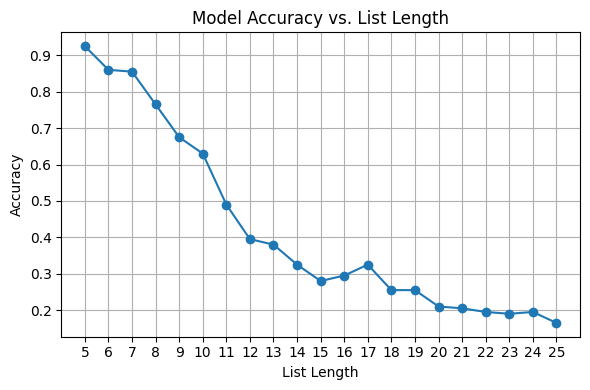

In [5]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Path to the dataset generated earlier
data_path = Path("index_probe_len5-25.jsonl")
print(data_path)

# Load rows
rows = []
with open(data_path, "r") as f:
    for line in f:
        rows.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(rows)

# Compute accuracy per list length
acc_df = (
    df.groupby("length")["correct"]
    .mean()
    .reset_index()
    .rename(columns={"correct": "accuracy"})
)

# Plot accuracy vs. length
plt.figure(figsize=(6, 4))
plt.plot(acc_df["length"], acc_df["accuracy"], marker="o")
plt.xlabel("List Length")
plt.ylabel("Accuracy")
plt.xticks(acc_df["length"])
plt.title("Model Accuracy vs. List Length")
plt.grid(True)
plt.tight_layout()
plt.show()


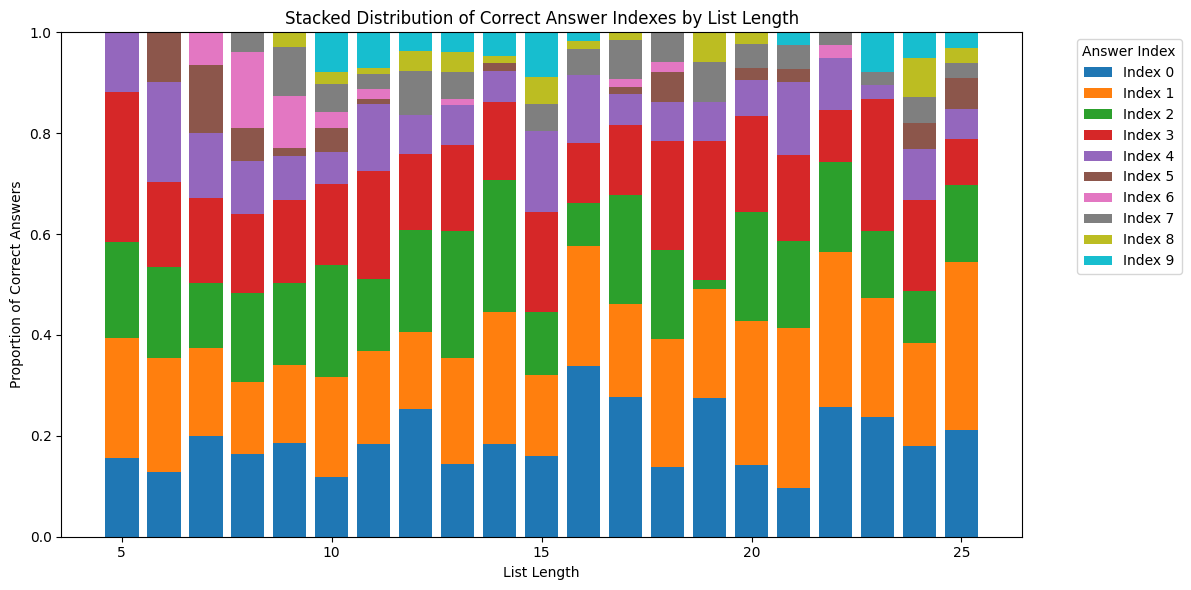

In [8]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

# Load file
data_path = Path("index_probe_len5-25.jsonl")
length_to_index_counts = defaultdict(lambda: defaultdict(int))

with open(data_path, "r") as f:
    for line in f:
        ex = json.loads(line)
        if not ex.get("correct", False):  # Only correct examples
            continue
        length = ex["length"]
        index = ex["answer_idx"]
        length_to_index_counts[length][index] += 1

# Prepare data
lengths = sorted(length_to_index_counts.keys())
max_idx = max(max(idx_counts) for idx_counts in length_to_index_counts.values())
all_indices = list(range(max_idx + 1))

# Normalize to get proportions per index at each length
proportions = {idx: [] for idx in all_indices}
for length in lengths:
    total = sum(length_to_index_counts[length].values())
    for idx in all_indices:
        count = length_to_index_counts[length].get(idx, 0)
        prop = count / total if total > 0 else 0
        proportions[idx].append(prop)

# Plot stacked bar
bottom = [0] * len(lengths)
plt.figure(figsize=(12, 6))
for idx in all_indices:
    plt.bar(lengths, proportions[idx], bottom=bottom, label=f"Index {idx}")
    bottom = [b + p for b, p in zip(bottom, proportions[idx])]

plt.xlabel("List Length")
plt.ylabel("Proportion of Correct Answers")
plt.title("Stacked Distribution of Correct Answer Indexes by List Length")
plt.legend(title="Answer Index", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/jw/6ndvyxwn0z13_8v9fm01bpc80000gn/T/ipykernel_28482/2337613788.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("RdYlBu")  # or "coolwarm", "RdYlBu", etc.


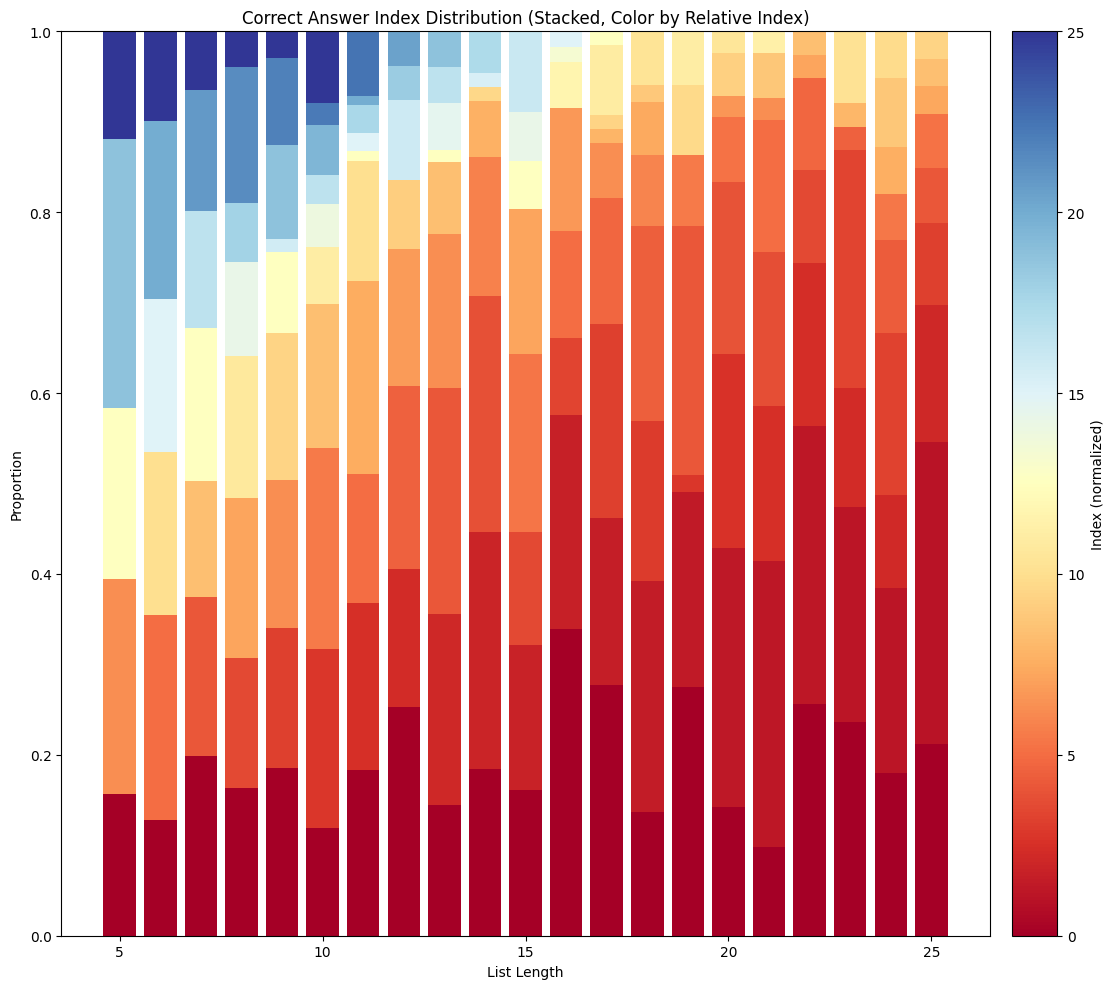

In [26]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

# Load file
data_path = Path("index_probe_len5-25.jsonl")
correct_counts = defaultdict(lambda: defaultdict(int))
incorrect_counts = defaultdict(lambda: defaultdict(int))

with open(data_path, "r") as f:
    for line in f:
        ex = json.loads(line)
        length = ex["length"]
        index = ex["answer_idx"]
        if ex.get("correct", False):
            correct_counts[length][index] += 1
        else:
            incorrect_counts[length][index] += 1

# Prepare
lengths = sorted(set(correct_counts.keys()) | set(incorrect_counts.keys()))
max_idx = max(max(d.keys()) for d in list(correct_counts.values()) + list(incorrect_counts.values()))
all_indices = list(range(max_idx + 1))

def compute_proportions(data_dict):
    proportions = {idx: [] for idx in all_indices}
    for length in lengths:
        total = sum(data_dict[length].values())
        for idx in all_indices:
            count = data_dict[length].get(idx, 0)
            prop = count / total if total > 0 else 0
            proportions[idx].append(prop)
    return proportions

# Compute
correct_props = compute_proportions(correct_counts)
incorrect_props = compute_proportions(incorrect_counts)

# Plot
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Setup a color map: one color for low indices, midpoint, and high indices
cmap = cm.get_cmap("RdYlBu")  # or "coolwarm", "RdYlBu", etc.

fig, ax = plt.subplots(figsize=(12, 10))

for i, length in enumerate(lengths):
    total = sum(correct_counts[length].values())
    bottom = 0
    for idx in range(length):  # only valid indices for this length
        count = correct_counts[length].get(idx, 0)
        prop = count / total if total > 0 else 0
        color = cmap(idx / (length - 1))  # normalize idx to [0,1] for current length
        ax.bar(length, prop, bottom=bottom, color=color, width=0.8)
        bottom += prop

# Colorbar as a legend
sm = cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=max(lengths)))
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Index (normalized)")

ax.set_xlabel("List Length")
ax.set_ylabel("Proportion")
ax.set_title("Correct Answer Index Distribution (Stacked, Color by Relative Index)")
plt.tight_layout()
plt.show()


/var/folders/jw/6ndvyxwn0z13_8v9fm01bpc80000gn/T/ipykernel_28482/1082405787.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/var/folders/jw/6ndvyxwn0z13_8v9fm01bpc80000gn/T/ipykernel_28482/1082405787.py:61: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()


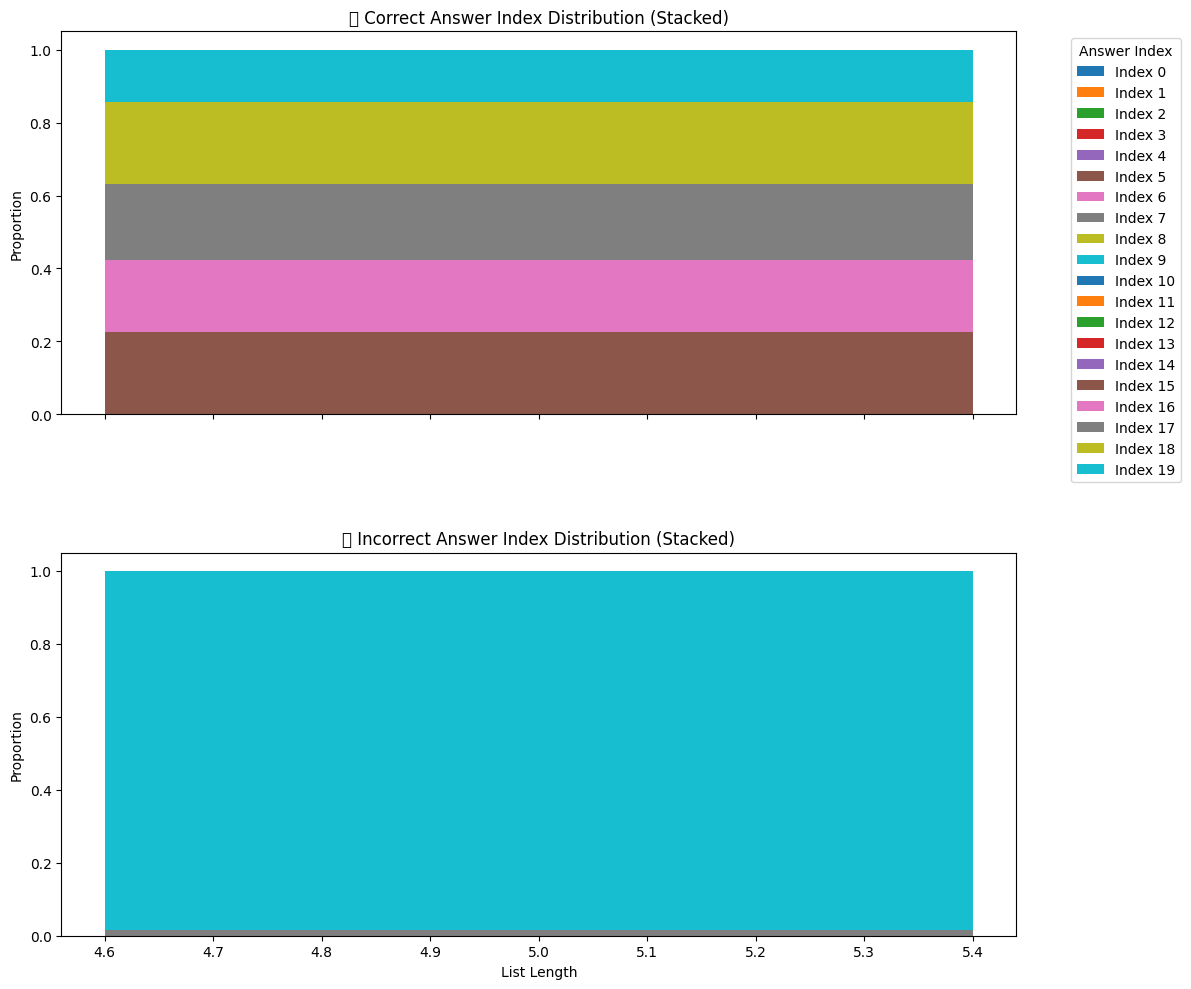

In [14]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from pathlib import Path

# Load file
data_path = Path("index_probe_dataset_random.jsonl")  # replace with your actual filename
correct_counts = defaultdict(lambda: defaultdict(int))
incorrect_counts = defaultdict(lambda: defaultdict(int))

with open(data_path, "r") as f:
    for line in f:
        ex = json.loads(line)
        length = len(ex["list"])
        index = ex["answer_idx"]
        if ex.get("correctness", False):  # <-- Updated key here
            correct_counts[length][index] += 1
        else:
            incorrect_counts[length][index] += 1

# Prepare
lengths = sorted(set(correct_counts.keys()) | set(incorrect_counts.keys()))
max_idx = max(max(d.keys()) for d in list(correct_counts.values()) + list(incorrect_counts.values()))
all_indices = list(range(max_idx + 1))

def compute_proportions(data_dict):
    proportions = {idx: [] for idx in all_indices}
    for length in lengths:
        total = sum(data_dict[length].values())
        for idx in all_indices:
            count = data_dict[length].get(idx, 0)
            prop = count / total if total > 0 else 0
            proportions[idx].append(prop)
    return proportions

# Compute
correct_props = compute_proportions(correct_counts)
incorrect_props = compute_proportions(incorrect_counts)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot correct
bottom = [0] * len(lengths)
for idx in all_indices:
    axs[0].bar(lengths, correct_props[idx], bottom=bottom, label=f"Index {idx}")
    bottom = [b + p for b, p in zip(bottom, correct_props[idx])]
axs[0].set_ylabel("Proportion")
axs[0].set_title("✅ Correct Answer Index Distribution (Stacked)")
axs[0].legend(title="Answer Index", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Plot incorrect
bottom = [0] * len(lengths)
for idx in all_indices:
    axs[1].bar(lengths, incorrect_props[idx], bottom=bottom, label=f"Index {idx}")
    bottom = [b + p for b, p in zip(bottom, incorrect_props[idx])]
axs[1].set_xlabel("List Length")
axs[1].set_ylabel("Proportion")
axs[1].set_title("❌ Incorrect Answer Index Distribution (Stacked)")

plt.tight_layout()
plt.show()
